In [2]:

# Importing the libraries
import numpy as np 
import pandas as pd
import datetime
import math
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import CSS4_COLORS, hsv_to_rgb
import matplotlib as mpl
import seaborn as sns
import ast 
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster
import plotly.express as px
from datetime import timedelta, datetime
import openai
import time 
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.manifold import TSNE
import hdbscan
from sklearn.preprocessing import StandardScaler
import os
import pickle
import re
from collections import Counter
from tqdm.auto import tqdm
from tqdm import tqdm
import json
from tqdm.notebook import tqdm
from sklearn.preprocessing import MinMaxScaler


# Show ALL columns
pd.set_option('display.max_columns', None)

# set openai api key
from dotenv import load_dotenv
load_dotenv()
openai.api_key = os.getenv("OPENAI_API_KEY")
MODEL = "gpt-4.1" 


In [3]:
#Load Dataset
sku_data = pd.read_pickle('sku_data.pkl')

#Inspect Datasets: Overview, Data Types, and Missing Values
def inspect_dataset(df):
    print(f"\n{df} Dataset Overview:")
    print("\nHEAD:\n", df.head())
    print("\nINFO:\n")
    print(df.info())
    print("\nMISSING VALUES:\n", df.isnull().sum())
    print("\n" + "-"*80 + "\n")

# Run inspections
inspect_dataset(sku_data)
sku_data


             sku                        name                id  \
0     AB10BBLK00    Abbey Blue-light Black 0  AB10BBLK00_20494   
1     AB10BBLK10    Abbey Blue-light Black 1  AB10BBLK10_20494   
2     AB10BBLK15  Abbey Blue-light Black 1.5  AB10BBLK15_20494   
3     AB10BBLK20    Abbey Blue-light Black 2  AB10BBLK20_20494   
4     AB10BBLK30    Abbey Blue-light Black 3  AB10BBLK30_20494   
...          ...                         ...               ...   
1262  WI80SBLK15         Wills Sun Black 1.5  WI80SBLK15_20494   
1263  WI80SBLK20           Wills Sun Black 2  WI80SBLK20_20494   
1264  WI80SBLK25         Wills Sun Black 2.5  WI80SBLK25_20494   
1265  WI80SNTP10      Wills Sun Navy Taupe 1  WI80SNTP10_20494   
1266  WI80SNTP20      Wills Sun Navy Taupe 2  WI80SNTP20_20494   

                  created_date  unit_quantity  awaiting  onhand  committed  \
0    2024-03-06 06:00:00+00:00            129         0     129          0   
1    2024-04-09 05:00:00+00:00              1     

sku                        name                id  \
0     AB10BBLK00    Abbey Blue-light Black 0  AB10BBLK00_20494   
1     AB10BBLK10    Abbey Blue-light Black 1  AB10BBLK10_20494   
2     AB10BBLK15  Abbey Blue-light Black 1.5  AB10BBLK15_20494   
3     AB10BBLK20    Abbey Blue-light Black 2  AB10BBLK20_20494   
4     AB10BBLK30    Abbey Blue-light Black 3  AB10BBLK30_20494   
...          ...                         ...               ...   
1262  WI80SBLK15         Wills Sun Black 1.5  WI80SBLK15_20494   
1263  WI80SBLK20           Wills Sun Black 2  WI80SBLK20_20494   
1264  WI80SBLK25         Wills Sun Black 2.5  WI80SBLK25_20494   
1265  WI80SNTP10      Wills Sun Navy Taupe 1  WI80SNTP10_20494   
1266  WI80SNTP20      Wills Sun Navy Taupe 2  WI80SNTP20_20494   

                  created_date  unit_quantity  awaiting  onhand  committed  \
0    2024-03-06 06:00:00+00:00            129         0     129          0   
1    2024-04-09 05:00:00+00:00              1         0       0          0   
2    2024-03-06 06:00:00+00:00              6         0       6          0   
3    2024-03-06 06:00:00+00:00             63         0      63          0   
4    2024-03-06 06:00:00+00:00             34         0      34          0   
...                        ...            ...       ...     ...        ...   
1262 2024-03-06 06:00:00+00:00              1         0       0          0   
1263 2024-03-06 06:00:00+00:00              1         0       0          0   
1264 2024-04-09 05:00:00+00:00              1         0       0          0   
1265 2024-03-06 06:00:00+00:00              1         0       0          0   
1266 2024-03-06 06:00:00+00:00              1         0       0          0   

      unfulfillable  fulfillable  unsellable  sellable  \
0                 0          129           0       129   
1                 0            0           0         0   
2                 0            6           0         6   
3                 0           63           0        63   
4                 0           34           0        34   
...             ...          ...         ...       ...   
1262              0            0           0         0   
1263              0            0           0         0   
1264              0            0           0         0   
1265              0            0           0         0   
1266              0            0           0         0   

      unit_quantity_matches_sellable  initial_inventory  inventory_3m_ago  \
0                               True              162.0             133.0   
1                              False                7.0               6.0   
2                               True               26.0              23.0   
3                               True               86.0              83.0   
4                               True               40.0              39.0   
...                              ...                ...               ...   
1262                           False               12.0               5.0   
1263                           False                6.0               1.0   
1264                           False                6.0               5.0   
1265                           False                2.0               2.0   
1266                           False                5.0               5.0   

      inventory_6m_ago  receipts_after  receipts_after_3m  receipts_after_6m  \
0                162.0             0.0                0.0                0.0   
1                  7.0             0.0                0.0                0.0   
2                 26.0             0.0                0.0                0.0   
3                 86.0             0.0                0.0                0.0   
4                 40.0             0.0                0.0                0.0   
...                ...             ...                ...                ...   
1262              12.0             0.0                0.0                0.0   
1263               6.

In [4]:
# Get text embeddings through OpenAI API

def get_embedding(text, model="text-embedding-ada-002"):
    try:
        response = openai.embeddings.create(
            input=text,
            model=model
        )
        return response.data[0].embedding
    except Exception as e:
        print(f"Error embedding '{text}': {e}")
        return [0.0] * 768  # fallback

# Check if embeddings file exists
embeddings_file = "sku_name_embeddings.pkl"
if not os.path.exists(embeddings_file):
    print("Generating text embeddings for SKU names...")
    sku_data["name_embedding"] = sku_data["name"].apply(lambda x: get_embedding(x))
    time.sleep(0.1)  # buffer to avoid rate limits
    
    # Save embeddings to file
    with open(embeddings_file, 'wb') as f:
        pickle.dump(sku_data["name_embedding"], f)
    print(f"Embeddings saved to {embeddings_file}")
else:
    print(f"Loading embeddings from {embeddings_file}")
    with open(embeddings_file, 'rb') as f:
        sku_data["name_embedding"] = pickle.load(f)
        
name_embeddings = sku_data["name_embedding"].tolist()

sku_data

Loading embeddings from sku_name_embeddings.pkl


sku                        name                id  \
0     AB10BBLK00    Abbey Blue-light Black 0  AB10BBLK00_20494   
1     AB10BBLK10    Abbey Blue-light Black 1  AB10BBLK10_20494   
2     AB10BBLK15  Abbey Blue-light Black 1.5  AB10BBLK15_20494   
3     AB10BBLK20    Abbey Blue-light Black 2  AB10BBLK20_20494   
4     AB10BBLK30    Abbey Blue-light Black 3  AB10BBLK30_20494   
...          ...                         ...               ...   
1262  WI80SBLK15         Wills Sun Black 1.5  WI80SBLK15_20494   
1263  WI80SBLK20           Wills Sun Black 2  WI80SBLK20_20494   
1264  WI80SBLK25         Wills Sun Black 2.5  WI80SBLK25_20494   
1265  WI80SNTP10      Wills Sun Navy Taupe 1  WI80SNTP10_20494   
1266  WI80SNTP20      Wills Sun Navy Taupe 2  WI80SNTP20_20494   

                  created_date  unit_quantity  awaiting  onhand  committed  \
0    2024-03-06 06:00:00+00:00            129         0     129          0   
1    2024-04-09 05:00:00+00:00              1         0       0          0   
2    2024-03-06 06:00:00+00:00              6         0       6          0   
3    2024-03-06 06:00:00+00:00             63         0      63          0   
4    2024-03-06 06:00:00+00:00             34         0      34          0   
...                        ...            ...       ...     ...        ...   
1262 2024-03-06 06:00:00+00:00              1         0       0          0   
1263 2024-03-06 06:00:00+00:00              1         0       0          0   
1264 2024-04-09 05:00:00+00:00              1         0       0          0   
1265 2024-03-06 06:00:00+00:00              1         0       0          0   
1266 2024-03-06 06:00:00+00:00              1         0       0          0   

      unfulfillable  fulfillable  unsellable  sellable  \
0                 0          129           0       129   
1                 0            0           0         0   
2                 0            6           0         6   
3                 0           63           0        63   
4                 0           34           0        34   
...             ...          ...         ...       ...   
1262              0            0           0         0   
1263              0            0           0         0   
1264              0            0           0         0   
1265              0            0           0         0   
1266              0            0           0         0   

      unit_quantity_matches_sellable  initial_inventory  inventory_3m_ago  \
0                               True              162.0             133.0   
1                              False                7.0               6.0   
2                               True               26.0              23.0   
3                               True               86.0              83.0   
4                               True               40.0              39.0   
...                              ...                ...               ...   
1262                           False               12.0               5.0   
1263                           False                6.0               1.0   
1264                           False                6.0               5.0   
1265                           False                2.0               2.0   
1266                           False                5.0               5.0   

      inventory_6m_ago  receipts_after  receipts_after_3m  receipts_after_6m  \
0                162.0             0.0                0.0                0.0   
1                  7.0             0.0                0.0                0.0   
2                 26.0             0.0                0.0                0.0   
3                 86.0             0.0                0.0                0.0   
4                 40.0             0.0                0.0                0.0   
...                ...             ...                ...                ...   
1262              12.0             0.0                0.0                0.0   
1263               6.

Now we will be grouping products by both semantic similarity (from SKU names) and numerical behavior (from sales metrics like average price and velocity).

In [5]:
# Extract the text embeddings and convert them into a NumPy array.
X_text = np.array(sku_data["name_embedding"].tolist())
print("Text embeddings shape:", X_text.shape)  # Expected shape: (1267, 1536)

Text embeddings shape: (1267, 1536)


In [6]:
# Extract the numeric features: average price, velocity_30d, velocity_90d, overall_velocity.
numeric_cols = ["avg_unit_price", "velocity_30d", "velocity_90d", "overall_velocity", "latest_velocity_30d", "latest_velocity_90d", "max_daily_sales", "min_daily_sales", "time_to_first_sale", "latest_sale_age"]
X_numeric = sku_data[numeric_cols].values
print("Numeric features shape:", X_numeric.shape)  # Expected shape: (1267, 10)

Numeric features shape: (1267, 10)


In [7]:
# Standardize the numeric features.
scaler = StandardScaler()
X_numeric_scaled = scaler.fit_transform(X_numeric)

X_numeric_scaled

array([[-8.03583450e-01,  4.47570858e-01, -9.31467395e-02, ...,
        -2.89327797e-02,  1.79897310e-03, -6.07374400e-01],
       [ 2.29457410e-03, -1.87190010e-01, -3.77826687e-01, ...,
        -2.89327797e-02, -6.08154259e-01, -9.65296790e-01],
       [-7.46146968e-01, -1.87190010e-01, -3.66439489e-01, ...,
        -2.89327797e-02, -1.26612234e-01, -5.35789922e-01],
       ...,
       [ 4.68855535e-01, -1.58337243e-01, -3.66439489e-01, ...,
        -2.89327797e-02, -3.19229044e-01, -1.40503001e+00],
       [ 4.68855535e-01, -2.16042776e-01, -4.23375478e-01, ...,
        -2.89327797e-02,  2.53792030e+00, -8.83485958e-01],
       [ 4.68855535e-01, -2.16042776e-01, -4.23375478e-01, ...,
        -2.89327797e-02,  2.08848108e+00, -9.24391374e-01]],
      shape=(1267, 10))

In [8]:
X_combined = np.concatenate([X_text, X_numeric_scaled], axis=1)
print("Combined features shape:", X_combined.shape)  # Expected shape: (1267, 1536+10) = (1267, 1546)

Combined features shape: (1267, 1546)


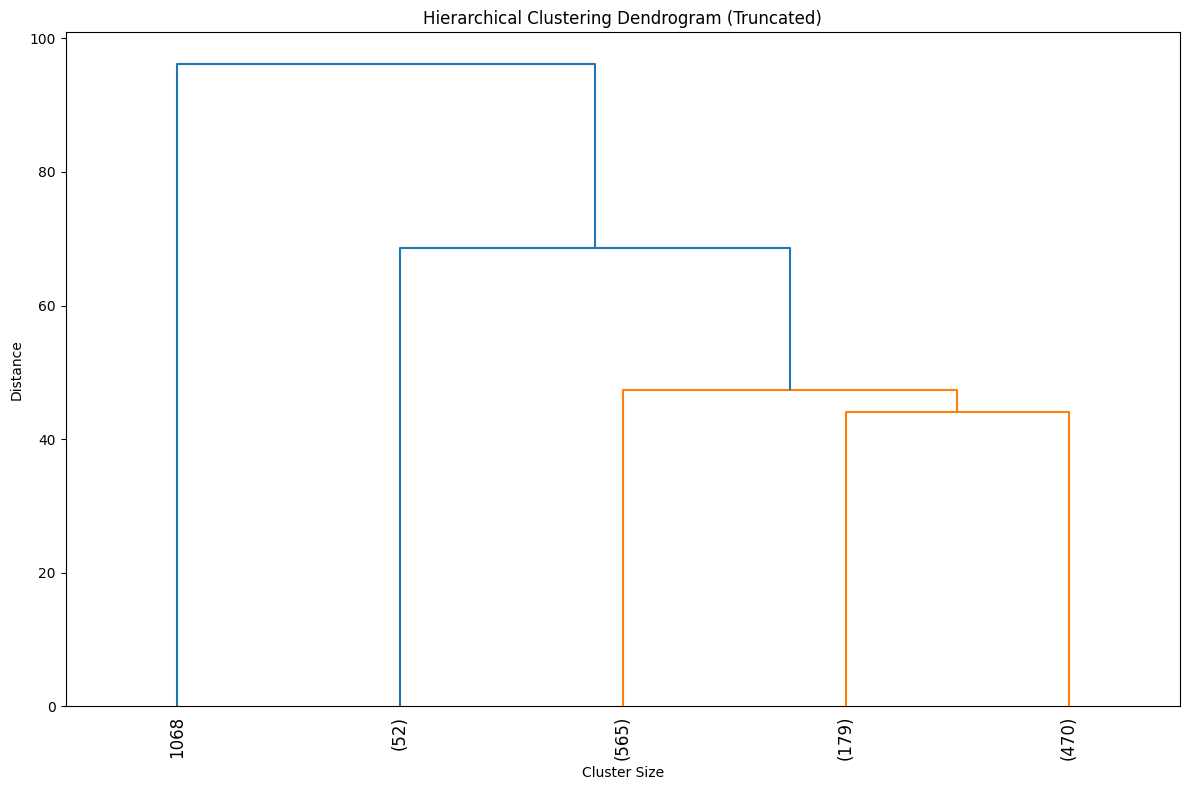

In [9]:
# Compute the linkage matrix using Ward's method.
Z = linkage(X_combined, method='ward')

cluster_number = 5 # Set the number of desired clusters

# Plot the dendrogram.
plt.figure(figsize=(12, 8))
dendrogram(Z, truncate_mode='lastp', p=cluster_number, leaf_rotation=90)
plt.title("Hierarchical Clustering Dendrogram (Truncated)")
plt.xlabel("Cluster Size")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()

# Cut the dendrogram to form clusters
cluster_labels = fcluster(Z, t=cluster_number, criterion='maxclust')
sku_data["cluster"] = cluster_labels


   cluster  max_monthly_velocity
0        1              8.350000
1        2              0.266667
2        3              0.300000
3        4              1.000000
4        5             33.333333


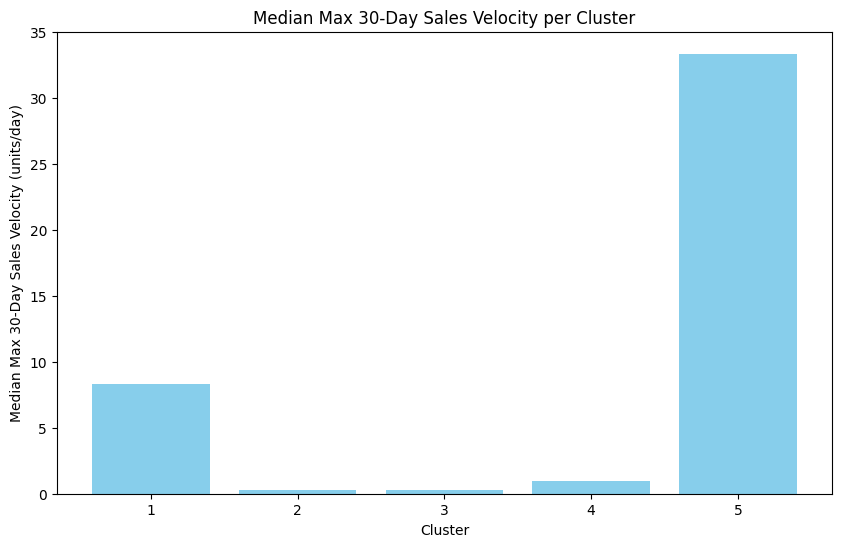

Cluster 1: AC01CCMLT (Cleaning Cloth (x3)), CO70BLK15 (Cosmo Readers Black 1.5), CO70CHA15 (Cosmo Readers Champagne 1.5), CO70CHA20 (Cosmo Readers Champagne 2), CO70LKB15 (Cosmo Readers Lake Blue 1.5), CO70LKB20 (Cosmo Readers Lake Blue 2), CO70PBLK15 (Cosmo Progressives Black 1.5), CO70PBLK20 (Cosmo Progressives Black 2), CO70PCHA15 (Cosmo Progressives Champagne 1.5), CO70PCHA20 (Cosmo Progressives Champagne 2), CO70PCHA25 (Cosmo Progressives Champagne 2.5), CO70PGRY15 (Cosmo Progressives Grey 1.5), CO70PLKB10 (Cosmo Progressives Lake Blue 1), CO70PLKB15 (Cosmo Progressives Lake Blue 1.5), CO70PLKB20 (Cosmo Progressives Lake Blue 2), CO70PLKB25 (Cosmo Progressives Lake Blue 2.5), CO70PTOR10 (Cosmo Progressives Tortoise 1), CO70PTOR15 (Cosmo Progressives Tortoise 1.5), CO70PTOR20 (Cosmo Progressives Tortoise 2), CO70PTOR25 (Cosmo Progressives Tortoise 2.5), CO70PTPE10 (Cosmo Progressives Taupe 1), CO70PTPE15 (Cosmo Progressives Taupe 1.5), CO70PTPE20 (Cosmo Progressives Taupe 2), CO70P

In [10]:
# Get cluster summary
cluster_summary = sku_data.groupby("cluster")["max_monthly_velocity"].median().reset_index()
print(cluster_summary)

# Plot a Bar Chart of the Median Max 30-Day Sales Velocity per Cluster
plt.figure(figsize=(10, 6))
plt.bar(cluster_summary["cluster"].astype(str), cluster_summary["max_monthly_velocity"], color='skyblue')
plt.xlabel("Cluster")
plt.ylabel("Median Max 30-Day Sales Velocity (units/day)")
plt.title("Median Max 30-Day Sales Velocity per Cluster")
plt.show()

# Print SKUs and product names for each cluster on a single line
for cl in sorted(sku_data["cluster"].unique()):
    cluster_subset = sku_data[sku_data["cluster"] == cl]
    sku_list = [f"{row['sku']} ({row['name']})" for _, row in cluster_subset.iterrows()]
    joined_skus = ", ".join(sku_list)
    print(f"Cluster {cl}: {joined_skus}")



In [11]:
# Can easily be modified to show other features
plt.figure(figsize=(12, 6))
sns.boxplot(data=sku_data, x='cluster', y='max_monthly_velocity')
plt.title("Distribution of Max Monthly Velocity by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Max Monthly Velocity")
plt.show()

In [12]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=sku_data, x='cluster', y='overall_velocity')
plt.title("Distribution of Overall Velocity by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Overall Velocity")
plt.show()

In [13]:
inspect_dataset(sku_data)


             sku                        name                id  \
0     AB10BBLK00    Abbey Blue-light Black 0  AB10BBLK00_20494   
1     AB10BBLK10    Abbey Blue-light Black 1  AB10BBLK10_20494   
2     AB10BBLK15  Abbey Blue-light Black 1.5  AB10BBLK15_20494   
3     AB10BBLK20    Abbey Blue-light Black 2  AB10BBLK20_20494   
4     AB10BBLK30    Abbey Blue-light Black 3  AB10BBLK30_20494   
...          ...                         ...               ...   
1262  WI80SBLK15         Wills Sun Black 1.5  WI80SBLK15_20494   
1263  WI80SBLK20           Wills Sun Black 2  WI80SBLK20_20494   
1264  WI80SBLK25         Wills Sun Black 2.5  WI80SBLK25_20494   
1265  WI80SNTP10      Wills Sun Navy Taupe 1  WI80SNTP10_20494   
1266  WI80SNTP20      Wills Sun Navy Taupe 2  WI80SNTP20_20494   

                  created_date  unit_quantity  awaiting  onhand  committed  \
0    2024-03-06 06:00:00+00:00            129         0     129          0   
1    2024-04-09 05:00:00+00:00              1     

In [14]:
# Aggregate per cluster
cluster_agg = (
    sku_data
    .groupby("cluster")
    .agg(total_sales=("total_quantity_sold", "sum"),
         avg_velocity=("overall_velocity",    "mean"))
    .reset_index()
    .sort_values("cluster")            # ensures x‑axis in order 0,1,2…
)

# Choose a colour for each bar (colormap makes it easy)
cmap   = mpl.cm.get_cmap("Set2", cluster_agg.shape[0])  # as many colours as clusters
barcol = [cmap(i) for i in range(cluster_agg.shape[0])]

# 3) Plot
fig, ax  = plt.subplots(figsize=(8, 5))
ax.bar(cluster_agg["cluster"], cluster_agg["total_sales"],
       color=barcol, alpha=0.8)
ax.set_xlabel("Cluster")
ax.set_ylabel("Total units sold")
ax.set_title("Sales & Avg Velocity by Cluster")

# secondary axis for velocity
ax2 = ax.twinx()
ax2.plot(cluster_agg["cluster"], cluster_agg["avg_velocity"],
         color="black", marker="o", linestyle="-",
         label="Avg daily velocity")
ax2.set_ylabel("Avg daily velocity")
ax2.legend(loc="upper right")

plt.tight_layout()
plt.show()


/var/folders/_j/5gy7sssx29n0hjwrrtf9w0zh0000gn/T/ipykernel_1550/2851223018.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap   = mpl.cm.get_cmap("Set2", cluster_agg.shape[0])  # as many colours as clusters


In [15]:
inspect_dataset(sku_data)


             sku                        name                id  \
0     AB10BBLK00    Abbey Blue-light Black 0  AB10BBLK00_20494   
1     AB10BBLK10    Abbey Blue-light Black 1  AB10BBLK10_20494   
2     AB10BBLK15  Abbey Blue-light Black 1.5  AB10BBLK15_20494   
3     AB10BBLK20    Abbey Blue-light Black 2  AB10BBLK20_20494   
4     AB10BBLK30    Abbey Blue-light Black 3  AB10BBLK30_20494   
...          ...                         ...               ...   
1262  WI80SBLK15         Wills Sun Black 1.5  WI80SBLK15_20494   
1263  WI80SBLK20           Wills Sun Black 2  WI80SBLK20_20494   
1264  WI80SBLK25         Wills Sun Black 2.5  WI80SBLK25_20494   
1265  WI80SNTP10      Wills Sun Navy Taupe 1  WI80SNTP10_20494   
1266  WI80SNTP20      Wills Sun Navy Taupe 2  WI80SNTP20_20494   

                  created_date  unit_quantity  awaiting  onhand  committed  \
0    2024-03-06 06:00:00+00:00            129         0     129          0   
1    2024-04-09 05:00:00+00:00              1     

/var/folders/_j/5gy7sssx29n0hjwrrtf9w0zh0000gn/T/ipykernel_1550/2992475372.py:65: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  plt.plot(df.index, df["TOTAL"], color="black",


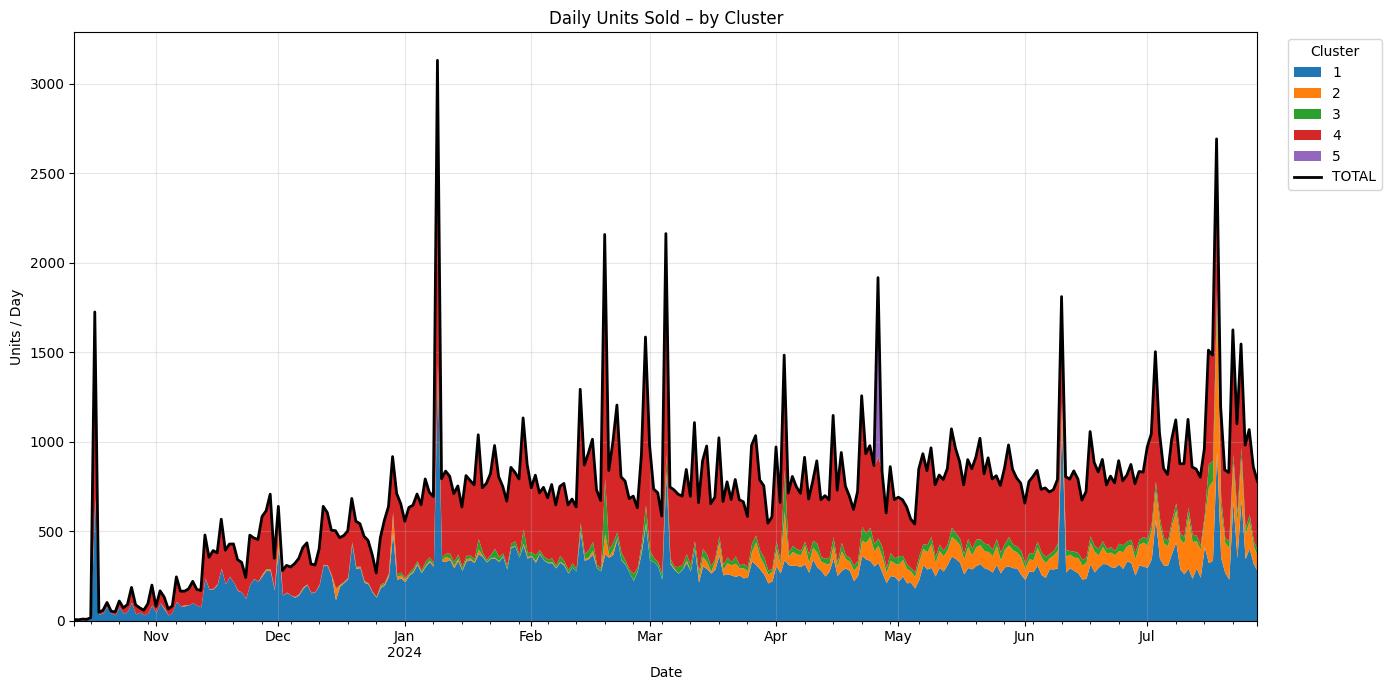

/var/folders/_j/5gy7sssx29n0hjwrrtf9w0zh0000gn/T/ipykernel_1550/2992475372.py:65: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  plt.plot(df.index, df["TOTAL"], color="black",


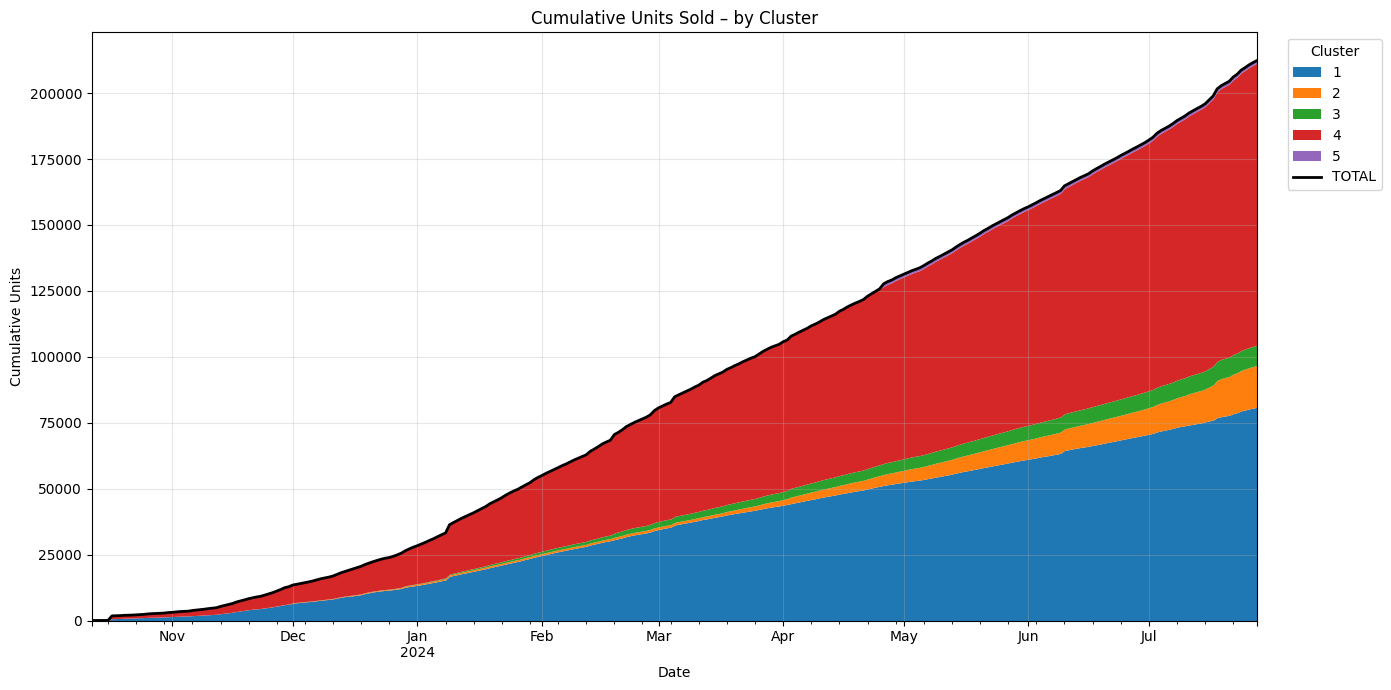

/var/folders/_j/5gy7sssx29n0hjwrrtf9w0zh0000gn/T/ipykernel_1550/2992475372.py:65: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  plt.plot(df.index, df["TOTAL"], color="black",


/var/folders/_j/5gy7sssx29n0hjwrrtf9w0zh0000gn/T/ipykernel_1550/2992475372.py:65: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  plt.plot(df.index, df["TOTAL"], color="black",


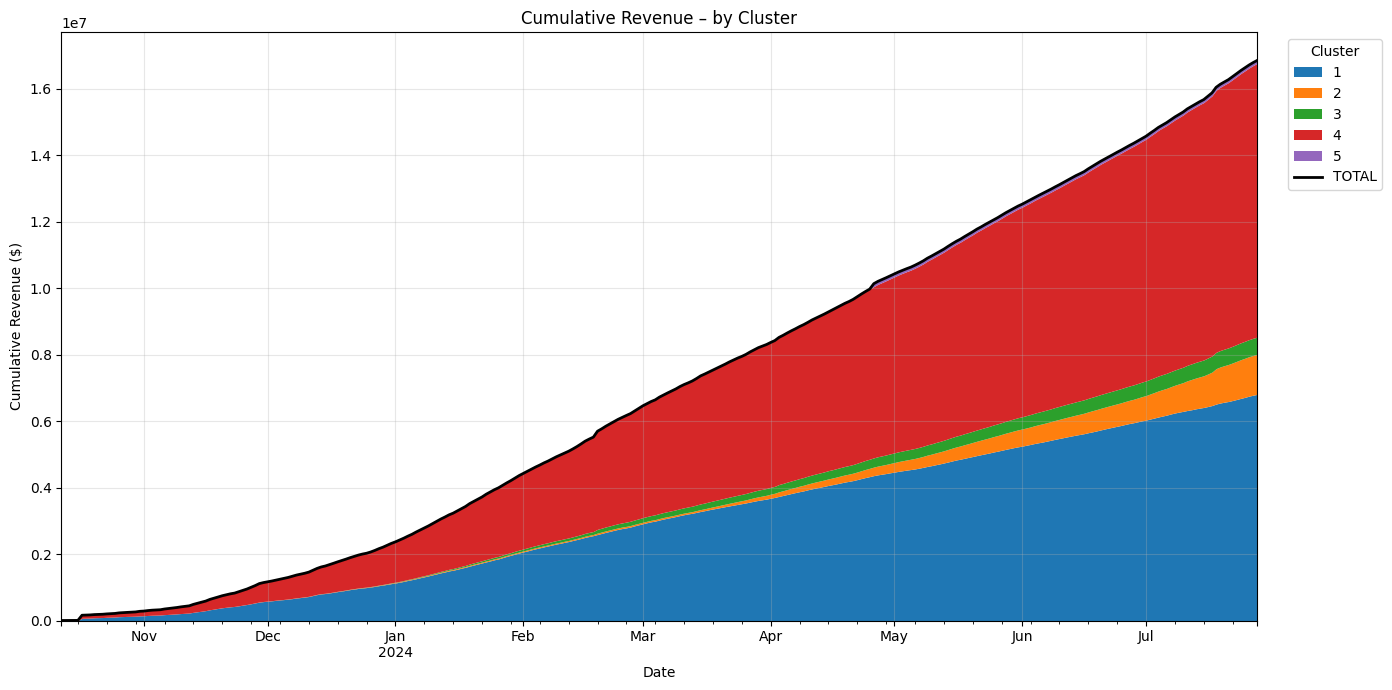

In [16]:
# Daily & cumulative sales / revenue, colour‑segmented by
# cluster, using *actual* unit_price from order_history

# explode order_history → long table: date, cluster, sku, qty, revenue

def parse_order_history(oh):
    if oh == "No Sales":
        return []
    
    if isinstance(oh, str):
        try:
            return ast.literal_eval(oh)
        except Exception as e:
            print(f"Error parsing order_history: {e}")
            return []
    
    return oh

records = []
for _, r in sku_data.iterrows():
    cl, sku = r["cluster"], r["sku"]
    for entry in parse_order_history(r["order_history"]):
        dt, qty, price = entry[:3]
        if isinstance(dt, str):
            dt = datetime.fromisoformat(dt.replace("Z", "+00:00"))
        price = float(price) if pd.notnull(price) else 0.0
        records.append({
            "date":   dt.date(),
            "cluster": cl,
            "sku":     sku,
            "qty":     qty,
            "revenue": qty * price        # unit‑true revenue
        })

sales_long = pd.DataFrame(records)

if not sales_long.empty:
    # pivot to daily wide tables (one column per cluster)
    daily_qty = (sales_long.groupby(["date", "cluster"])["qty"]
                 .sum().unstack(fill_value=0).sort_index())
    daily_rev = (sales_long.groupby(["date", "cluster"])["revenue"]
                 .sum().unstack(fill_value=0).sort_index())

    # full calendar index
    idx = pd.date_range(daily_qty.index.min(),
                        daily_qty.index.max(), freq="D")
    daily_qty = daily_qty.reindex(idx, fill_value=0)
    daily_rev = daily_rev.reindex(idx, fill_value=0)

    # TOTAL columns
    daily_qty["TOTAL"] = daily_qty.sum(axis=1)
    daily_rev["TOTAL"] = daily_rev.sum(axis=1)

    # cumulative versions
    cum_qty = daily_qty.cumsum()
    cum_rev = daily_rev.cumsum()

    # helper – stacked if all ≥0, else line plot
    def plot_cluster_timeseries(df, title, ylabel):
        data = df.drop(columns="TOTAL")
        stacked = (data.min().ge(0).all() or data.max().le(0).all())
        plt.figure(figsize=(14, 7))
        (data.plot.area if stacked else data.plot)(
            ax=plt.gca(), linewidth=0 if stacked else 1)
        plt.plot(df.index, df["TOTAL"], color="black",
                 linewidth=2, label="TOTAL")
        plt.title(title)
        plt.xlabel("Date")
        plt.ylabel(ylabel)
        plt.legend(title="Cluster", bbox_to_anchor=(1.02, 1),
                   loc="upper left")
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()

    # plots
    plot_cluster_timeseries(daily_qty, "Daily Units Sold – by Cluster",
                            "Units / Day")
    plot_cluster_timeseries(cum_qty, "Cumulative Units Sold – by Cluster",
                            "Cumulative Units")
    plot_cluster_timeseries(daily_rev, "Daily Revenue – by Cluster",
                            "Revenue ($)")
    plot_cluster_timeseries(cum_rev, "Cumulative Revenue – by Cluster",
                            "Cumulative Revenue ($)")
else:
    print("No sales found – nothing to plot")


In [17]:
# Plot cumulative sales vs. days since launch for each cluster

#unique_clusters = sorted(sku_data["cluster"].unique())

#for cl in unique_clusters:
#    # Select SKUs for the current cluster.
#    cluster_subset = sku_data[sku_data["cluster"] == cl]
    
#    plt.figure(figsize=(10, 6))
   
#    for idx, row in cluster_subset.iterrows():
#        days, cumulative = get_cumulative_sales(row)
#        if len(days) == 0:
#            continue
        # Use the SKU name (or id) as the label.
#        plt.plot(days, cumulative, label=row["name"], alpha=0.8)
    
#    plt.title(f"Cumulative Sales vs. Days Since Launch - Cluster {cl}")
#    plt.xlabel("Days Since Launch")
#    plt.ylabel("Cumulative Sales")
#    plt.legend(fontsize=8, loc="upper left", bbox_to_anchor=(1, 1))
#    plt.show()


# Use LLM to Summarize SKU Names per Cluster
#def summarize_cluster_skus(sku_names, cluster_label):
#    prompt = (
#        f"Below is a list of product SKU names for cluster {cluster_label}. "
#        "Based on these names, please provide a concise summary of the common characteristics "
#        "(for example, color, style, lens type, or product category) that define this cluster:\n\n"
#        + "\n".join(sku_names)
#    )
#    try:
#        response = openai.chat.completions.create(
#            model="gpt-4",  # or "gpt-3.5-turbo"
#            messages=[
#                {"role": "system", "content": "You are an expert in product analysis."},
#                {"role": "user", "content": prompt}
#            ],
#            temperature=0.5,
#        )
#        summary = response.choices[0].message.content.strip()
#        return summary
#    except Exception as e:
#        print(f"Error summarizing cluster {cluster_label}: {e}")
#        return "Summary not available."

# For each cluster, gather SKU names and get a summary from the LLM.
#cluster_summaries = {}
#for cl in unique_clusters:
#    cluster_subset = sku_data[sku_data["cluster"] == cl]
#    sku_names_cluster = cluster_subset["name"].tolist()
    # Optionally, sample the names if there are too many:
#    sku_names_sample = sku_names_cluster[:50]
#    summary = summarize_cluster_skus(sku_names_sample, cl)
#    cluster_summaries[cl] = summary
#    print(f"\nCluster {cl} Summary:\n{summary}\n")



In [18]:
inspect_dataset(sku_data)


             sku                        name                id  \
0     AB10BBLK00    Abbey Blue-light Black 0  AB10BBLK00_20494   
1     AB10BBLK10    Abbey Blue-light Black 1  AB10BBLK10_20494   
2     AB10BBLK15  Abbey Blue-light Black 1.5  AB10BBLK15_20494   
3     AB10BBLK20    Abbey Blue-light Black 2  AB10BBLK20_20494   
4     AB10BBLK30    Abbey Blue-light Black 3  AB10BBLK30_20494   
...          ...                         ...               ...   
1262  WI80SBLK15         Wills Sun Black 1.5  WI80SBLK15_20494   
1263  WI80SBLK20           Wills Sun Black 2  WI80SBLK20_20494   
1264  WI80SBLK25         Wills Sun Black 2.5  WI80SBLK25_20494   
1265  WI80SNTP10      Wills Sun Navy Taupe 1  WI80SNTP10_20494   
1266  WI80SNTP20      Wills Sun Navy Taupe 2  WI80SNTP20_20494   

                  created_date  unit_quantity  awaiting  onhand  committed  \
0    2024-03-06 06:00:00+00:00            129         0     129          0   
1    2024-04-09 05:00:00+00:00              1     

In [19]:

# 1) FEATURE FLAGS
prescription_terms = {
    "progressive":   r"Progressive",
    "sun":           r"\bSun\b",
    "blue_light":    r"Blue[\s-]?light",
}

for feat, pat in prescription_terms.items():
    sku_data[f"is_{feat}"] = sku_data["name"].str.contains(pat, case=False, regex=True)
    
sku_data["is_glasses"] = sku_data["name"].str.contains(r"\b(Readers|Progressives|Blue[\s-]?light|Sun)\b", flags=re.IGNORECASE, regex=True)

# 2) PRESCRIPTION STRENGTH
#    grab the first standalone number (e.g. "1.5", "2", "0") in the name
sku_data["strength"] = (
    sku_data["name"]
      .str.extract(r"(\d+(?:\.\d+)?)\b", expand=False)
      .astype(float)
)

# 3) COLOR
colors = [
    "Black", "Champagne", "Chestnut", "Gold", "Grey", "Gunmetal", "Navy", "Aqua", "Bone", "Green", "Cinnamon", "Espresso", "Jade", "Maroon", "Pink", "Rose", "Tortoise", "Silver", "Taupe", "Clear", "Crimson", "Honey", "Marine", "Brown", "Purple", "Mint", "Blue"
]

color_pat = r"\b(?!Blue[\s-]?light\b)(" + "|".join([c.replace(" ", r"\s+") for c in colors]) + r"|Tort)\b"
sku_data["color"] = (
    sku_data["name"]
      .str.extract(color_pat, flags=re.IGNORECASE, expand=False)
      .replace({"Tort(?!oise)": "Tortoise"}, regex=True)  # Replace 'Tort' with 'Tortoise' only if not followed by 'oise'
      .str.title()
)

# QUICKLY INSPECT TOP WORDS TO SPOT ANY MISSING FEATURES
tokens = sku_data["name"].str.findall(r"[A-Za-z]+")
word_counts = Counter(tokens.explode())
print("Top 25 most common name‑tokens:\n", word_counts.most_common(25))

sku_data.loc[~sku_data["is_glasses"], ["is_progressive", "is_sun", "is_blue_light"]] = False
sku_data.loc[~sku_data["is_glasses"], ["strength", "color"]] = np.nan

inspect_dataset(sku_data)



Top 25 most common name‑tokens:
 [('Readers', 513), ('Blue', 436), ('light', 335), ('Progressives', 266), ('Tortoise', 251), ('Cosmo', 218), ('Black', 193), ('Laurel', 172), ('Sun', 166), ('Taupe', 164), ('Shiny', 128), ('Sullivan', 103), ('Abbey', 99), ('Tint', 85), ('Navy', 77), ('Clear', 71), ('Grey', 70), ('Muse', 68), ('Gold', 66), ('Bond', 65), ('Chestnut', 62), ('Liam', 61), ('Champagne', 59), ('Cooper', 59), ('Silver', 50)]

             sku                        name                id  \
0     AB10BBLK00    Abbey Blue-light Black 0  AB10BBLK00_20494   
1     AB10BBLK10    Abbey Blue-light Black 1  AB10BBLK10_20494   
2     AB10BBLK15  Abbey Blue-light Black 1.5  AB10BBLK15_20494   
3     AB10BBLK20    Abbey Blue-light Black 2  AB10BBLK20_20494   
4     AB10BBLK30    Abbey Blue-light Black 3  AB10BBLK30_20494   
...          ...                         ...               ...   
1262  WI80SBLK15         Wills Sun Black 1.5  WI80SBLK15_20494   
1263  WI80SBLK20           Wills Su

/var/folders/_j/5gy7sssx29n0hjwrrtf9w0zh0000gn/T/ipykernel_1550/2261741673.py:11: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  sku_data["is_glasses"] = sku_data["name"].str.contains(r"\b(Readers|Progressives|Blue[\s-]?light|Sun)\b", flags=re.IGNORECASE, regex=True)


In [20]:
missing_strength = sku_data[sku_data["strength"].isna()]["name"]
missing_color = sku_data[sku_data["color"].isna()]["name"]

print("SKUs with missing strength:")
print(missing_strength.tolist())

print("\nSKUs with missing color:")
print(missing_color.tolist())


SKUs with missing strength:
['Cleaning Cloth (x3)', 'Rhys Chain Gold', 'Charlie Chain Black', 'Charlie Chain Brown', 'Margot Chain Gold', 'Kiki Chain Gold', 'Magnetic Display Logo Block (1 Pack)', 'Magnetic Display Blocks (3 Pack)', 'Tabletop Tower Display', 'Tabletop Tower Display - Left', 'Table Top Tower Display - 6 pc - Left', 'Tabletop Tower Display - Right', 'Table Top Tower Display - 6 pc - Right', 'Tabletop 6pc Tower w Mirror & Hooks (L)', 'Tabletop 6pc Tower w Mirror & Hooks (R)', 'Large Box 3 pc', 'Lois Progressives Shiny Vintage Tortoise', 'Lois Progressives Shiny Vintage Tortoise', 'Lois Progressives Shiny Vintage Tortoise', 'Lois Progressives Shiny Vintage Tortoise', 'Lois Progressives Shiny Vintage Tortoise', 'Lois Sun Progressives Shiny Vintage Tort', 'Lois Sun Progressives Shiny Vintage Tort', 'Lois Sun Progressives Shiny Vintage Tort', 'Lois Sun Progressives Shiny Vintage Tort', 'Medium Box 2 pc', 'FW24 Catalogue', 'FW24 Campaign Images', 'Muse Readers Gold - Green Gra

“Cooper Sun Gunmetal – Blue Grey Lenses 1” appears twice (516 & 517).
• Five identical “Lois Progressives Shiny Vintage Tortoise” rows (912-916).
• Four “Lois Sun Progressives Shiny Vintage Tort…” (943-946).
• Six “Muse Readers Gold – Green Gradient Tint” (1012-1017).
• Rows 629 & 631: “Cin Blue Tint” / “Cinna Blue Tint”.
• Rows 355 & 357: “P Tint” vs “Pink Tint”.
• Rows 516 & 517 are the same 


In [21]:
missing_skus = sku_data[sku_data["strength"].isna() | sku_data["color"].isna()][["sku", "name", "strength", "color"]]
print("SKUs with missing strength or color:")
print(missing_skus)

SKUs with missing strength or color:
                        sku                                      name  \
99                AC01CCMLT                       Cleaning Cloth (x3)   
252               CH01RHGLD                           Rhys Chain Gold   
253               CH02CHBLK                       Charlie Chain Black   
254               CH02CHBRW                       Charlie Chain Brown   
255               CH03MGGLD                         Margot Chain Gold   
256               CH04KKGLD                           Kiki Chain Gold   
534               DI55MAG01      Magnetic Display Logo Block (1 Pack)   
535               DI55MAG03          Magnetic Display Blocks (3 Pack)   
536               DI55TBT01                    Tabletop Tower Display   
537               DI55TBTL1             Tabletop Tower Display - Left   
538               DI55TBTL6     Table Top Tower Display - 6 pc - Left   
539               DI55TBTR1            Tabletop Tower Display - Right   
540           

In [22]:
inspect_dataset(sku_data)


             sku                        name                id  \
0     AB10BBLK00    Abbey Blue-light Black 0  AB10BBLK00_20494   
1     AB10BBLK10    Abbey Blue-light Black 1  AB10BBLK10_20494   
2     AB10BBLK15  Abbey Blue-light Black 1.5  AB10BBLK15_20494   
3     AB10BBLK20    Abbey Blue-light Black 2  AB10BBLK20_20494   
4     AB10BBLK30    Abbey Blue-light Black 3  AB10BBLK30_20494   
...          ...                         ...               ...   
1262  WI80SBLK15         Wills Sun Black 1.5  WI80SBLK15_20494   
1263  WI80SBLK20           Wills Sun Black 2  WI80SBLK20_20494   
1264  WI80SBLK25         Wills Sun Black 2.5  WI80SBLK25_20494   
1265  WI80SNTP10      Wills Sun Navy Taupe 1  WI80SNTP10_20494   
1266  WI80SNTP20      Wills Sun Navy Taupe 2  WI80SNTP20_20494   

                  created_date  unit_quantity  awaiting  onhand  committed  \
0    2024-03-06 06:00:00+00:00            129         0     129          0   
1    2024-04-09 05:00:00+00:00              1     

In [26]:
def make_summary(df, group_col):
    summary = (df.groupby(group_col, dropna=False)
               .agg(sku_count=("sku", "nunique"),
                    total_quantity_sold=("total_quantity_sold", "sum")))
    # Add a helper column to flag rows where the group key is null
    summary["_null"] = summary.index.to_series().apply(lambda x: pd.isna(x))
    # Sort by: non-null groups first (i.e. _null=False) and then by total_quantity_sold descending
    summary = summary.sort_values(by=["_null", "total_quantity_sold"], ascending=[True, False])
    return summary.drop(columns=["_null"])
# 1. Define exactly the attributes you want to summarize:
attributes = [
    "is_progressive",
    "is_sun",
    "is_blue_light",
    "is_glasses",
    "strength",
    "color",
]

# 2. Loop over them and call make_summary():
for col in attributes:
    print(f"\n── {col.upper()} ─────────────────────────────────────")
    summary = make_summary(sku_data, col)
    display(summary)   # or print(summary) if you prefer plain text



── IS_PROGRESSIVE ─────────────────────────────────────


sku_count  total_quantity_sold
is_progressive                                
True                  266             106759.0
False                1001             105677.0


── IS_SUN ─────────────────────────────────────


sku_count  total_quantity_sold
is_sun                                
False        1101             202142.0
True          166              10294.0


── IS_BLUE_LIGHT ─────────────────────────────────────


sku_count  total_quantity_sold
is_blue_light                                
False                930             204460.0
True                 337               7976.0


── IS_GLASSES ─────────────────────────────────────


sku_count  total_quantity_sold
is_glasses                                
True             1245             207372.0
False              22               5064.0


── STRENGTH ─────────────────────────────────────


sku_count  total_quantity_sold
strength                                
1.5             250              70877.0
2.0             227              55602.0
2.5             216              36977.0
1.0             256              26964.0
3.0             191              12839.0
0.0              90               1829.0
NaN              37               7348.0


── COLOR ─────────────────────────────────────


sku_count  total_quantity_sold
color                                    
Tortoise         250              44626.0
Taupe            162              34018.0
Champagne         59              24214.0
Gold              63              23915.0
Black            191              23652.0
Navy              77              16126.0
Blue              43              12601.0
Grey              59               7417.0
Silver            50               5307.0
Chestnut          62               2588.0
Clear             46               2454.0
Crimson           33               2413.0
Jade              20               2338.0
Green             39               1718.0
Honey             24               1169.0
Gunmetal          14               1003.0
Cinnamon          24                842.0
Marine             7                450.0
Espresso           8                355.0
Purple             8                 86.0
Rose               5                 77.0
Mint               1                  3.0
NaN               22               5064.0

Creating individual feature analysis plots...
Creating plot for: is_progressive


----------------------------------------
Creating plot for: is_sun


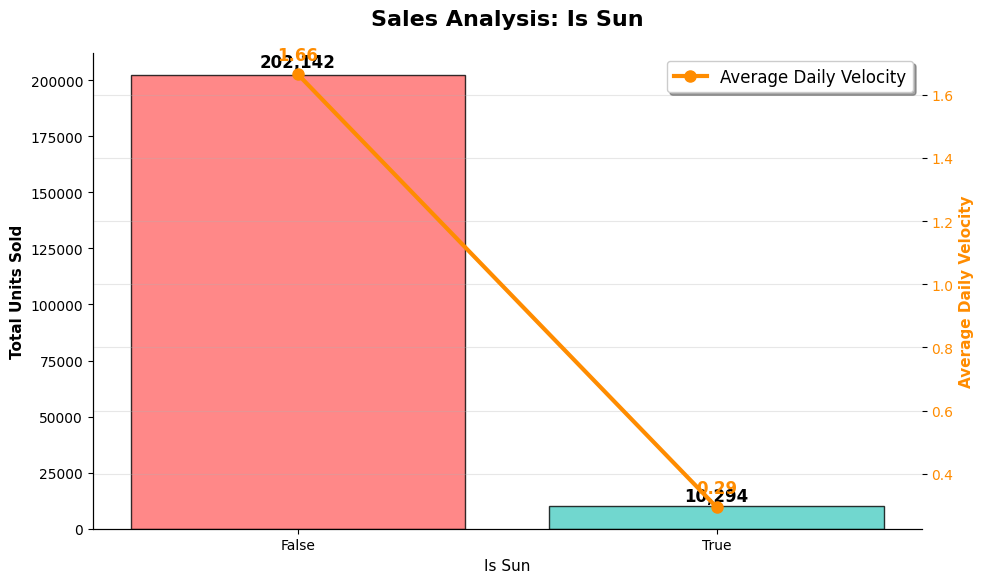

----------------------------------------
Creating plot for: is_blue_light


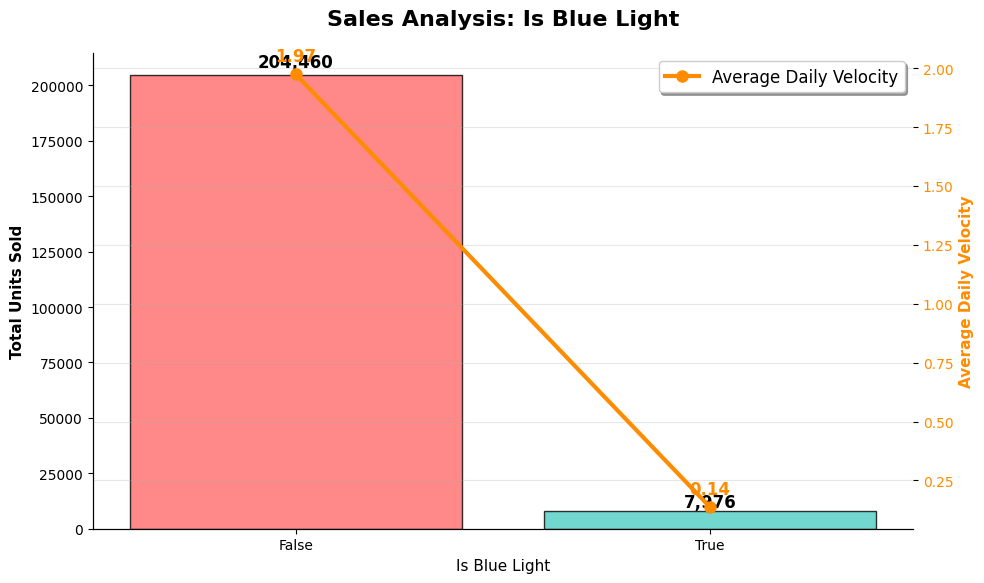

----------------------------------------
Creating plot for: is_glasses


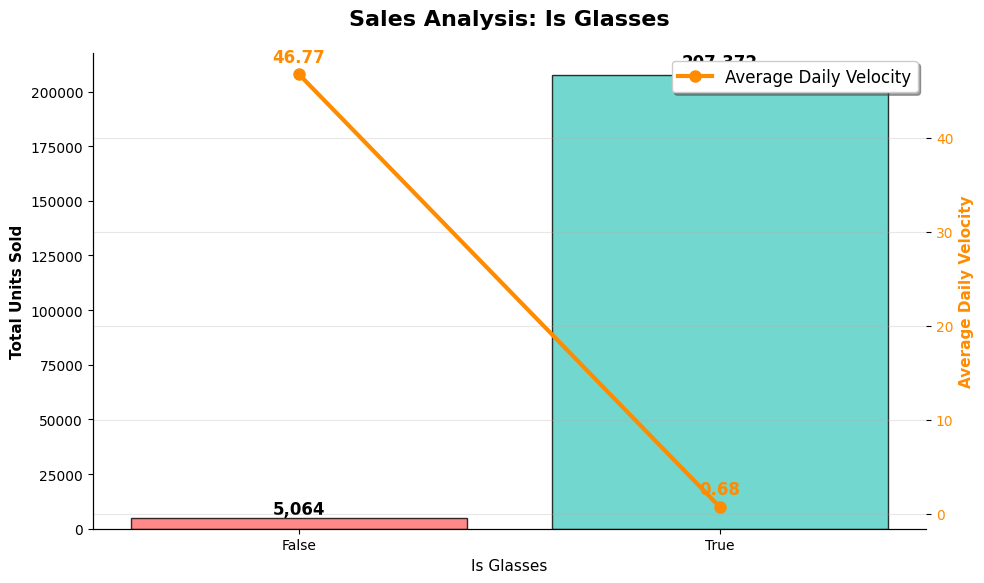

----------------------------------------
Creating plot for: strength


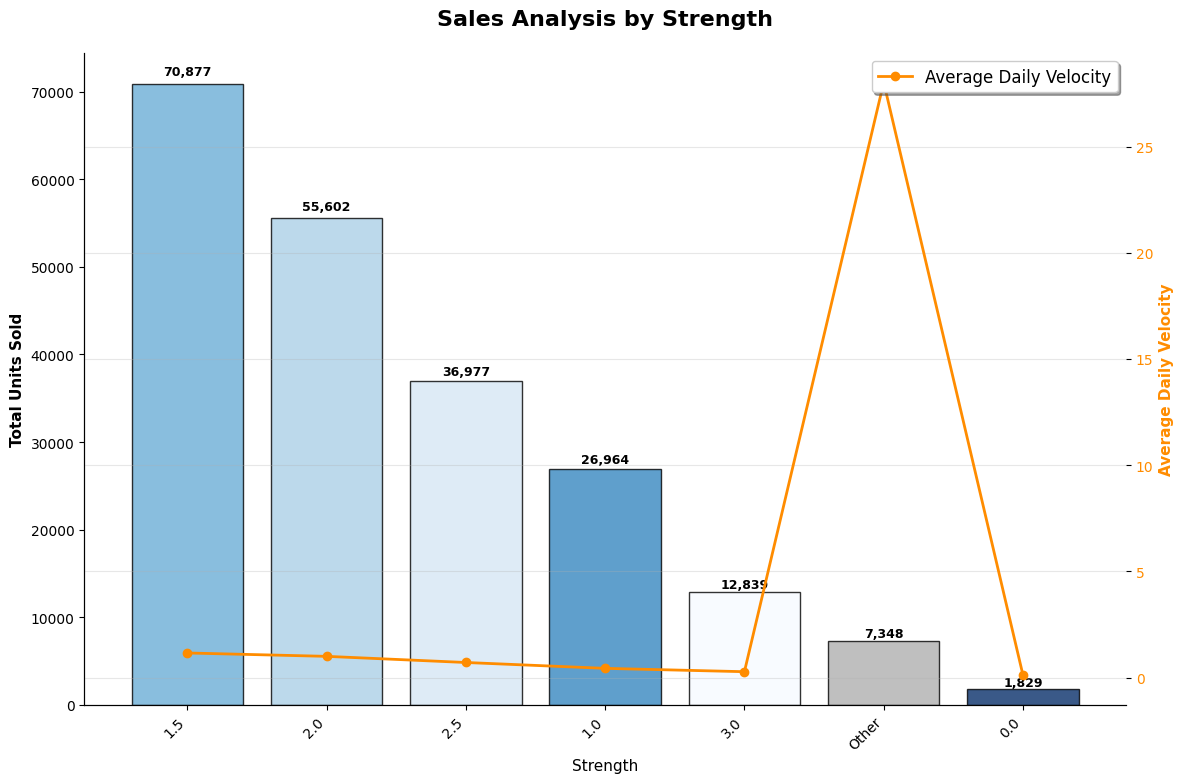

----------------------------------------
Creating plot for: color


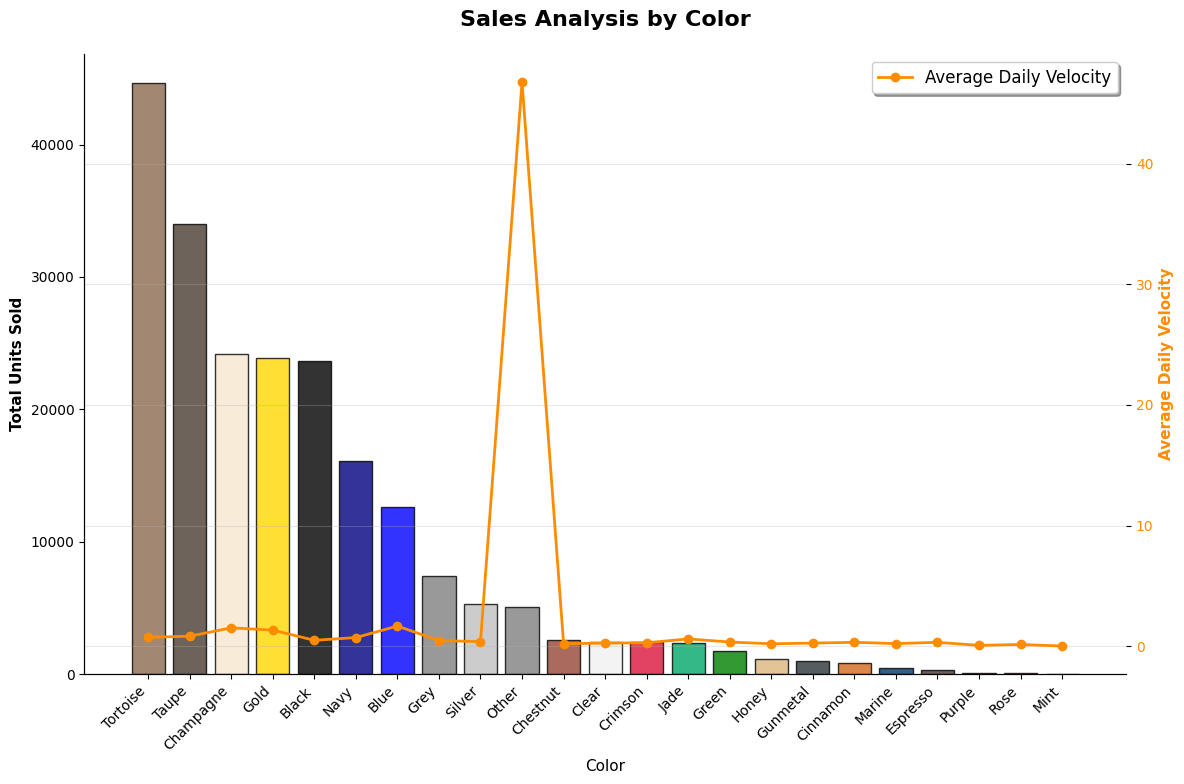

----------------------------------------
All plots created successfully!


In [51]:
# ═══════════════════════════════════════════════════════════════════════════════
# MATPLOTLIB STYLING CONFIGURATION
# ═══════════════════════════════════════════════════════════════════════════════
# Set up clean, professional styling for all plots
mpl.rcParams.update({
    "font.size": 12,
    "figure.facecolor": "white",
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.titleweight": "bold",
    "axes.titlesize": 14,
    "axes.labelsize": 11,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
})

# ═══════════════════════════════════════════════════════════════════════════════
# DATA PREPARATION AND AGGREGATION
# ═══════════════════════════════════════════════════════════════════════════════

# Define the boolean feature columns to analyze
bool_cols = ["is_progressive", "is_sun", "is_blue_light", "is_glasses"]

def prepare_boolean_data(data, bool_columns):
    """
    Aggregate sales data by boolean features.
    
    For each boolean feature, calculate:
    - Total sales (sum of quantities sold)
    - Average velocity (mean daily sales rate)
    
    Returns consolidated DataFrame for all boolean features.
    """
    frames = []
    for flag in bool_columns:
        # Group by boolean flag and calculate metrics
        temp_df = (data
                   .groupby(flag)
                   .agg(total_sales=("total_quantity_sold", "sum"),
                        avg_velocity=("overall_velocity", "mean"))
                   .reset_index()
                   .assign(category=flag, 
                          level=lambda d: d[flag].astype(str)))
        frames.append(temp_df)
    
    return pd.concat(frames, ignore_index=True)

def prepare_categorical_data(data, categorical_columns):
    """
    Aggregate sales data by categorical features (strength, color).
    
    Handles missing values by filling with 'Other' category.
    Returns consolidated DataFrame for all categorical features.
    """
    # Create copy to avoid modifying original data
    temp_data = data.copy()
    
    # Fill missing values with 'Other' for better visualization
    for col in categorical_columns:
        temp_data[col] = temp_data[col].fillna("Other")
    
    frames = []
    for col in categorical_columns:
        # Group by category and calculate metrics
        temp_df = (temp_data
                   .groupby(col, dropna=False)
                   .agg(total_sales=("total_quantity_sold", "sum"),
                        avg_velocity=("overall_velocity", "mean"))
                   .reset_index()
                   .assign(category=col, 
                          level=lambda d: d[col].astype(str)))
        frames.append(temp_df)
    
    return pd.concat(frames, ignore_index=True)

# Prepare aggregated data
bool_agg = prepare_boolean_data(sku_data, bool_cols)
cat_agg = prepare_categorical_data(sku_data, ["strength", "color"])

# ═══════════════════════════════════════════════════════════════════════════════
# COLOR MAPPING FUNCTIONS
# ═══════════════════════════════════════════════════════════════════════════════

def get_strength_colors(levels):
    """
    Generate colors for strength values using a blue gradient.
    
    Numeric strengths get colors from light to dark blue.
    Non-numeric values get a neutral gray color.
    """
    cmap = mpl.cm.Blues_r  # Reverse for better contrast
    
    # Convert to numeric, keeping NaN for non-numeric values
    numeric_vals = pd.to_numeric(levels, errors="coerce")
    
    # Only normalize if we have valid numeric values
    if numeric_vals.notna().any():
        valid_vals = numeric_vals[numeric_vals.notna()]
        norm = mpl.colors.Normalize(vmin=valid_vals.min(), vmax=valid_vals.max())
        colors = []
        for val in numeric_vals:
            if pd.notna(val):
                colors.append(cmap(norm(val)))
            else:
                colors.append("#B0B0B0")  # Gray for non-numeric
        return colors
    else:
        # All non-numeric, return gray for all
        return ["#B0B0B0"] * len(levels)

# Manual color mapping for frame colors (based on actual eyewear colors)
FRAME_COLOR_MAP = {
    "Champagne": "#F7E7CE",
    "Gunmetal": "#2A3439", 
    "Espresso": "#4B3832",
    "Tortoise": "#8B6A4F",
    "Crystal": "#E5E8ED",
    "Honey": "#DDB67D",
    "Chestnut": "#954535",
    "Cinnamon": "#D2691E",
    "Clear": "#F0F0F0",  # Light gray instead of white for visibility
    "Jade": "#00A86B",
    "Marine": "#01386A", 
    "Mint": "#AAF0D1",
    "Rose": "#FF007F",
    "Taupe": "#483C32",
    "Other": "#808080",  # Medium gray for 'Other'
}

def get_color_hex(color_name):
    """
    Convert color name to hex code.
    
    Priority order:
    1. Manual frame color mapping (eyewear-specific colors)
    2. CSS4 standard colors
    3. Fallback to gray
    """
    # Check manual mapping first (case-sensitive for exact matches)
    if color_name in FRAME_COLOR_MAP:
        return FRAME_COLOR_MAP[color_name]
    
    # Check CSS4 colors (case-insensitive)
    css_color = CSS4_COLORS.get(color_name.lower())
    if css_color:
        return css_color
    
    # Fallback to gray
    return "#B0B0B0"

# ═══════════════════════════════════════════════════════════════════════════════
# INDIVIDUAL PLOTTING FUNCTIONS
# ═══════════════════════════════════════════════════════════════════════════════

def create_boolean_feature_plot(data, feature_name, figsize=(10, 6)):
    """
    Create a dual-axis plot for a single boolean feature.
    
    Shows total sales as bars and average velocity as a line.
    Uses intuitive red/green coloring for False/True values.
    """
    # Filter data for this specific feature
    feature_data = data[data["category"] == feature_name].copy()
    
    if feature_data.empty:
        print(f"No data found for feature: {feature_name}")
        return None
    
    # Sort by level for consistent ordering (False before True)
    feature_data = feature_data.sort_values("level")
    
    # Create figure and primary axis
    fig, ax1 = plt.subplots(figsize=figsize)
    
    # Color mapping for boolean values
    color_map = {"False": "#FF6B6B", "True": "#4ECDC4"}  # Red for False, Teal for True
    bar_colors = [color_map.get(level, "#B0B0B0") for level in feature_data["level"]]
    
    # Create bar chart for total sales
    bars = ax1.bar(feature_data["level"], feature_data["total_sales"],
                   color=bar_colors, alpha=0.8, edgecolor="black", linewidth=1)
    
    # Customize primary axis
    ax1.set_xlabel(f"{feature_name.replace('_', ' ').title()}")
    ax1.set_ylabel("Total Units Sold", color="black", fontweight="bold")
    ax1.tick_params(axis="y", labelcolor="black")
    
    # Add value labels on bars
    for bar, value in zip(bars, feature_data["total_sales"]):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                f'{int(value):,}', ha='center', va='bottom', fontweight='bold')
    
    # Create secondary axis for velocity
    ax2 = ax1.twinx()
    line = ax2.plot(feature_data["level"], feature_data["avg_velocity"],
                    color="#FF8C00", marker="o", markersize=8, linewidth=3,
                    label="Average Daily Velocity")
    
    ax2.set_ylabel("Average Daily Velocity", color="#FF8C00", fontweight="bold")
    ax2.tick_params(axis="y", labelcolor="#FF8C00")
    
    # Add value labels for velocity
    for x, y in zip(feature_data["level"], feature_data["avg_velocity"]):
        ax2.text(x, y + max(feature_data["avg_velocity"])*0.02,
                f'{y:.2f}', ha='center', va='bottom', 
                color="#FF8C00", fontweight='bold')
    
    # Set title and improve layout
    plt.title(f"Sales Analysis: {feature_name.replace('_', ' ').title()}", 
              fontsize=16, fontweight="bold", pad=20)
    
    # Add legend
    ax2.legend(loc="upper right", frameon=True, fancybox=True, shadow=True)
    
    # Improve layout
    plt.tight_layout()
    plt.grid(True, alpha=0.3, axis='y')
    
    return fig

def create_categorical_feature_plot(data, feature_name, figsize=(12, 8)):
    """
    Create a dual-axis plot for categorical features (strength, color).
    
    Uses appropriate color schemes based on the feature type.
    """
    # Filter data for this specific feature
    feature_data = data[data["category"] == feature_name].copy()
    
    if feature_data.empty:
        print(f"No data found for feature: {feature_name}")
        return None
    
    # Sort by total sales for better visualization
    feature_data = feature_data.sort_values("total_sales", ascending=False)
    
    # Create figure with larger size for categorical data
    fig, ax1 = plt.subplots(figsize=figsize)
    
    # Determine colors based on feature type
    if feature_name == "strength":
        bar_colors = get_strength_colors(feature_data["level"])
    elif feature_name == "color":
        bar_colors = [get_color_hex(color) for color in feature_data["level"]]
        # Debug: Print any colors that fell back to gray
        gray_colors = [color for color in feature_data["level"] 
                      if get_color_hex(color) == "#B0B0B0"]
        if gray_colors:
            print(f"Colors mapped to gray (consider adding to manual map): {gray_colors}")
    else:
        bar_colors = ["#4ECDC4"] * len(feature_data)
    
    # Create bar chart
    bars = ax1.bar(range(len(feature_data)), feature_data["total_sales"],
                   color=bar_colors, alpha=0.8, edgecolor="black", linewidth=1)
    
    # Customize primary axis
    ax1.set_xlabel(f"{feature_name.title()}")
    ax1.set_ylabel("Total Units Sold", color="black", fontweight="bold")
    ax1.set_xticks(range(len(feature_data)))
    ax1.set_xticklabels(feature_data["level"], rotation=45, ha='right')
    ax1.tick_params(axis="y", labelcolor="black")
    
    # Add value labels on bars (only if not too many bars)
    if len(feature_data) <= 15:
        for i, (bar, value) in enumerate(zip(bars, feature_data["total_sales"])):
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                    f'{int(value):,}', ha='center', va='bottom', 
                    fontweight='bold', fontsize=9)
    
    # Create secondary axis for velocity
    ax2 = ax1.twinx()
    line = ax2.plot(range(len(feature_data)), feature_data["avg_velocity"],
                    color="#FF8C00", marker="o", markersize=6, linewidth=2,
                    label="Average Daily Velocity")
    
    ax2.set_ylabel("Average Daily Velocity", color="#FF8C00", fontweight="bold")
    ax2.tick_params(axis="y", labelcolor="#FF8C00")
    
    # Set title
    plt.title(f"Sales Analysis by {feature_name.title()}", 
              fontsize=16, fontweight="bold", pad=20)
    
    # Add legend
    ax2.legend(loc="upper right", frameon=True, fancybox=True, shadow=True)
    
    # Improve layout
    plt.tight_layout()
    plt.grid(True, alpha=0.3, axis='y')
    
    return fig

# ═══════════════════════════════════════════════════════════════════════════════
# MAIN EXECUTION: CREATE ALL PLOTS
# ═══════════════════════════════════════════════════════════════════════════════

print("Creating individual feature analysis plots...")
print("=" * 60)

# Create individual plots for each boolean feature
boolean_features = ["is_progressive", "is_sun", "is_blue_light", "is_glasses"]

for feature in boolean_features:
    print(f"Creating plot for: {feature}")
    fig = create_boolean_feature_plot(bool_agg, feature)
    if fig:
        plt.show()
        plt.close()  # Free memory
    print("-" * 40)

# Create individual plots for categorical features
categorical_features = ["strength", "color"]

for feature in categorical_features:
    print(f"Creating plot for: {feature}")
    fig = create_categorical_feature_plot(cat_agg, feature)
    if fig:
        plt.show()
        plt.close()  # Free memory
    print("-" * 40)

print("All plots created successfully!")

# ═══════════════════════════════════════════════════════════════════════════════
# SUMMARY STATISTICS
# ═══════════════════════════════════════════════════════════════════════════════

def print_summary_stats():
    """Print summary statistics for all features."""
    print("\n" + "=" * 60)
    print("SUMMARY STATISTICS")
    print("=" * 60)
    
    # Boolean features summary
    print("\nBOOLEAN FEATURES:")
    for feature in boolean_features:
        feature_data = bool_agg[bool_agg["category"] == feature]
        if not feature_data.empty:
            true_sales = feature_data[feature_data["level"] == "True"]["total_sales"].iloc[0] if len(feature_data[feature_data["level"] == "True"]) > 0 else 0
            false_sales = feature_data[feature_data["level"] == "False"]["total_sales"].iloc[0] if len(feature_data[feature_data["level"] == "False"]) > 0 else 0
            print(f"  {feature}: True={true_sales:,} units, False={false_sales:,} units")
    
    # Categorical features summary
    print("\nCATEGORICAL FEATURES:")
    for feature in categorical_features:
        feature_data = cat_agg[cat_agg["category"] == feature]
        if not feature_data.empty:
            top_seller = feature_data.loc[feature_data["total_sales"].idxmax()]
            print(f"  {feature}: Top seller is '{top_seller['level']}' with {int(top_seller['total_sales']):,} units")

# Uncomment the line below to see summary statistics
# print_summary_stats()

In [52]:
inspect_dataset(sku_data)


             sku                        name                id  \
0     AB10BBLK00    Abbey Blue-light Black 0  AB10BBLK00_20494   
1     AB10BBLK10    Abbey Blue-light Black 1  AB10BBLK10_20494   
2     AB10BBLK15  Abbey Blue-light Black 1.5  AB10BBLK15_20494   
3     AB10BBLK20    Abbey Blue-light Black 2  AB10BBLK20_20494   
4     AB10BBLK30    Abbey Blue-light Black 3  AB10BBLK30_20494   
...          ...                         ...               ...   
1262  WI80SBLK15         Wills Sun Black 1.5  WI80SBLK15_20494   
1263  WI80SBLK20           Wills Sun Black 2  WI80SBLK20_20494   
1264  WI80SBLK25         Wills Sun Black 2.5  WI80SBLK25_20494   
1265  WI80SNTP10      Wills Sun Navy Taupe 1  WI80SNTP10_20494   
1266  WI80SNTP20      Wills Sun Navy Taupe 2  WI80SNTP20_20494   

                  created_date  unit_quantity  awaiting  onhand  committed  \
0    2024-03-06 06:00:00+00:00            129         0     129          0   
1    2024-04-09 05:00:00+00:00              1     

SKU SALES TIMELINE ANALYSIS

1. EXTRACTING SALES DATA...
----------------------------------------
Extracting daily sales data from order history...
Extracted 192616 daily sales records from 1267 SKUs
📊 Sales data extracted successfully:
   • Date range: 2023-10-12 to 2024-07-28
   • Total transactions: 192,616
   • Total units sold: 212,436
   • Unique SKUs with sales: 1,221

2. CREATING BOOLEAN FEATURE TIMELINES...
----------------------------------------
Creating timeline plot for: is_progressive
  Total sales: 212,436 units
  is_progressive=True: 106,759 units (50.3%)
  is_progressive=False: 105,677 units (49.7%)



Creating timeline plot for: is_sun
  Total sales: 212,436 units
  is_sun=True: 10,294 units (4.8%)
  is_sun=False: 202,142 units (95.2%)


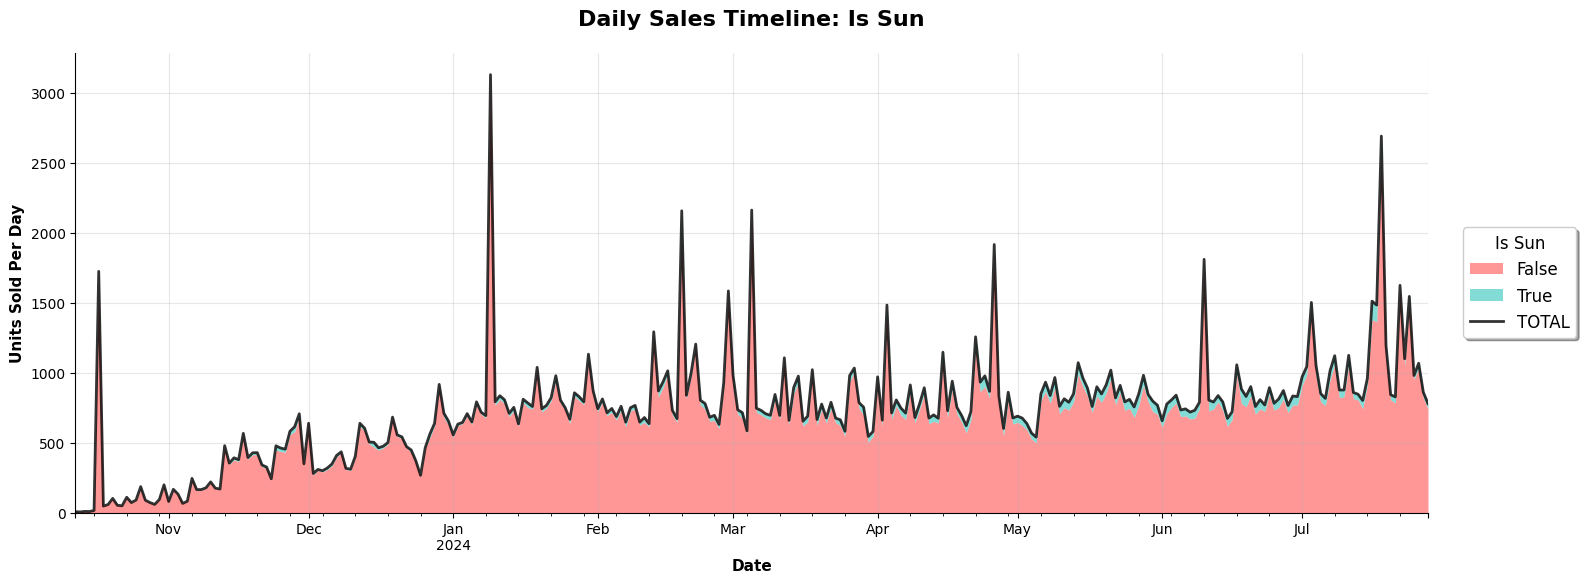


Creating timeline plot for: is_blue_light
  Total sales: 212,436 units
  is_blue_light=True: 7,976 units (3.8%)
  is_blue_light=False: 204,460 units (96.2%)


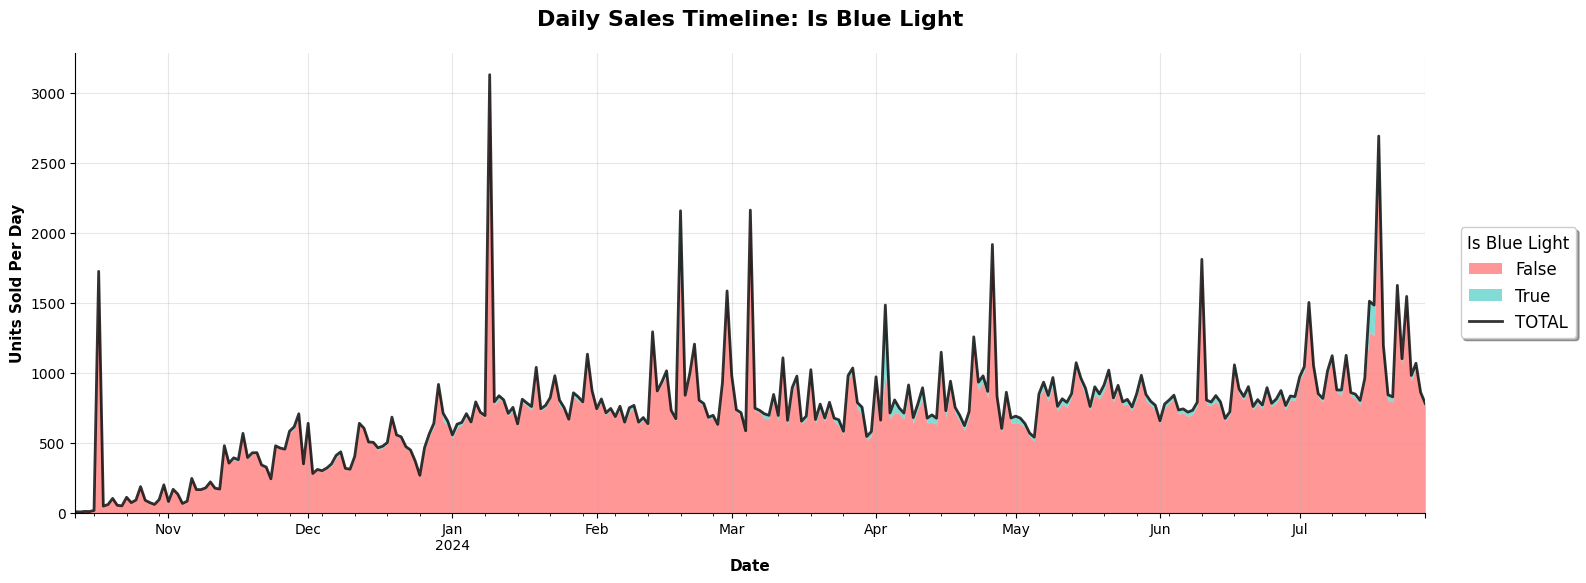


Creating timeline plot for: is_glasses
  Total sales: 212,436 units
  is_glasses=True: 207,372 units (97.6%)
  is_glasses=False: 5,064 units (2.4%)


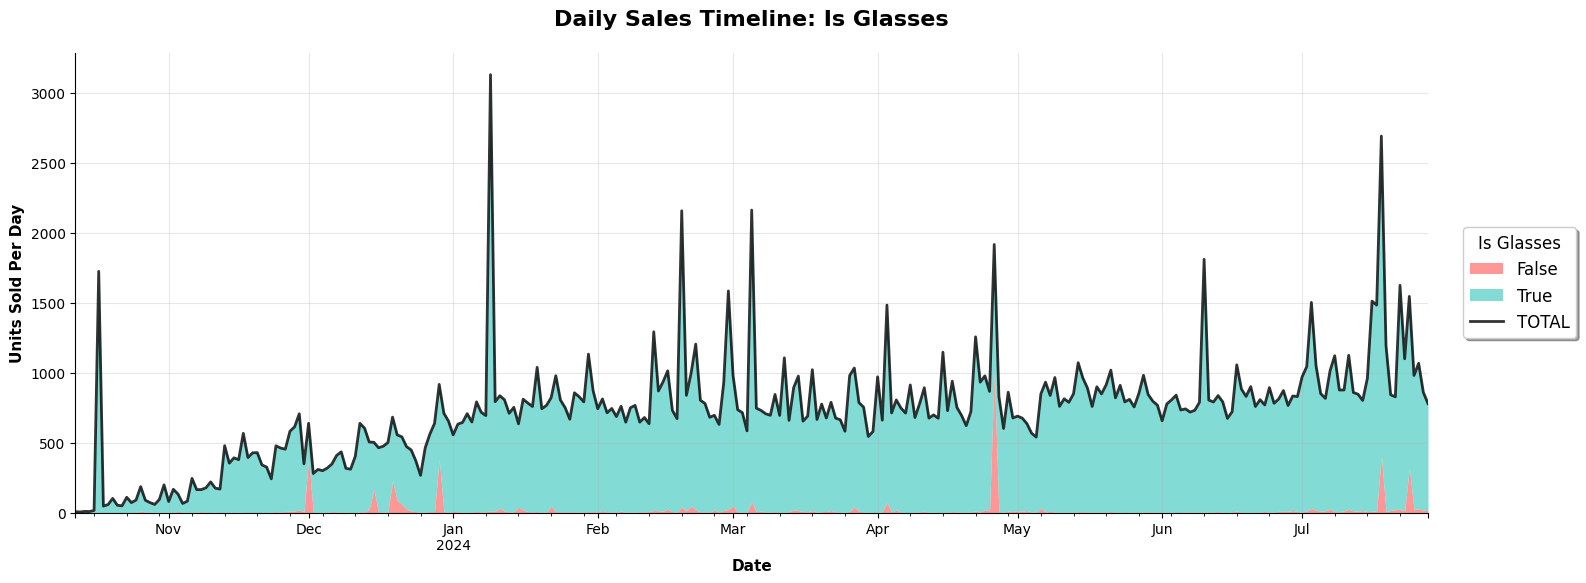



3. CREATING CATEGORICAL FEATURE TIMELINES...
----------------------------------------
Creating timeline plot for: strength
  Total sales: 212,436 units
  Top strength categories:
    1. 1.5: 70,877 units (33.4%)
    2. 2.0: 55,602 units (26.2%)
    3. 2.5: 36,977 units (17.4%)
    4. 1.0: 26,964 units (12.7%)
    5. 3.0: 12,839 units (6.0%)


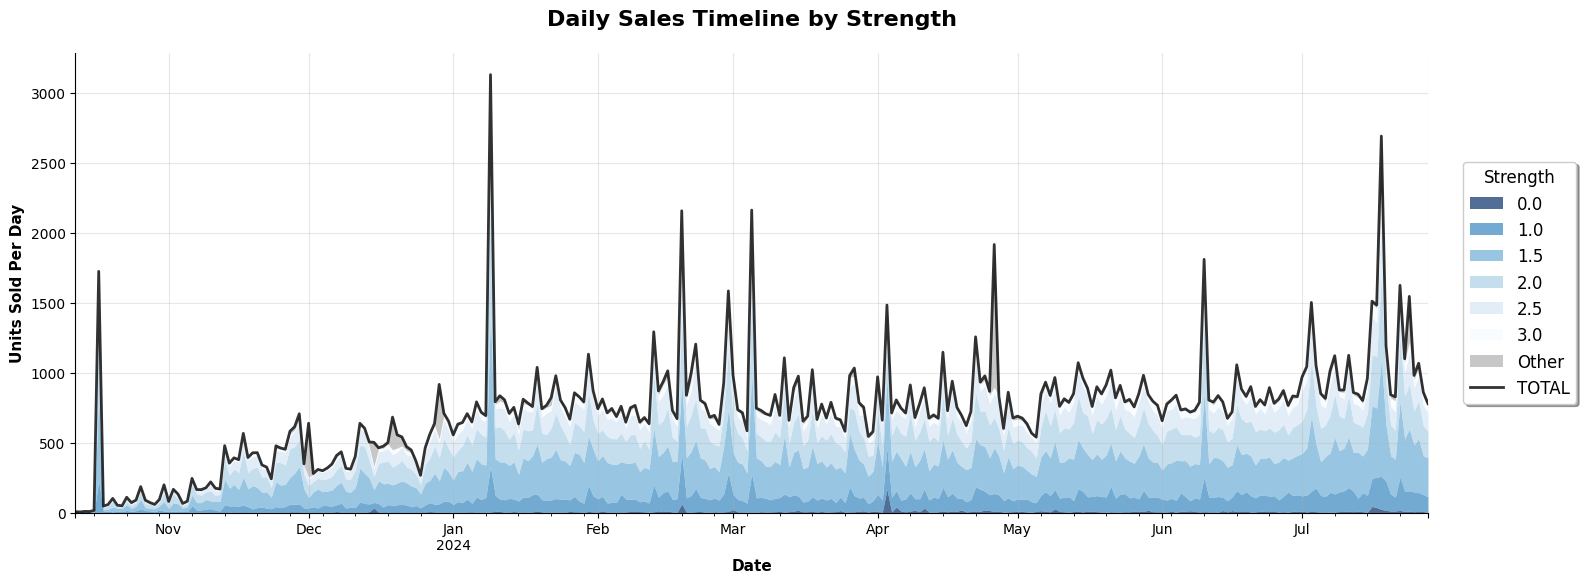


Creating timeline plot for: color
  Total sales: 212,436 units
  Top color categories:
    1. Tortoise: 44,626 units (21.0%)
    2. Taupe: 34,018 units (16.0%)
    3. Champagne: 24,214 units (11.4%)
    4. Gold: 23,915 units (11.3%)
    5. Black: 23,652 units (11.1%)



✅ Sales timeline analysis completed!


In [53]:
# ═══════════════════════════════════════════════════════════════════════════════
# MATPLOTLIB STYLING CONFIGURATION
# ═══════════════════════════════════════════════════════════════════════════════
mpl.rcParams.update({
    "font.size": 12,
    "figure.facecolor": "white",
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.titleweight": "bold",
    "axes.titlesize": 14,
    "axes.labelsize": 11,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
})

# ═══════════════════════════════════════════════════════════════════════════════
# DATA PARSING AND PREPARATION FUNCTIONS
# ═══════════════════════════════════════════════════════════════════════════════

def parse_order_history(oh):
    if oh == "No Sales":
        return []
    
    if isinstance(oh, str):
        try:
            return ast.literal_eval(oh)
        except Exception as e:
            print(f"Error parsing order_history: {e}")
            return []
    
    return oh

def extract_daily_sales_data(sku_data):
    """
    Extract daily sales data from order_history column.
    
    Converts the order_history column (which contains sales transactions)
    into a structured DataFrame with daily sales by SKU.
    
    Returns:
        DataFrame with columns: ['date', 'sku', 'quantity', 'price'] + feature columns
    """
    print("Extracting daily sales data from order history...")
    
    # Parse all order histories and create expanded sales records
    sales_records = []
    
    for idx, row in sku_data.iterrows():
        sku = row['sku']
        order_history = parse_order_history(row['order_history'])
        
        # Extract feature columns for this SKU
        features = {
            'is_progressive': row['is_progressive'],
            'is_sun': row['is_sun'], 
            'is_blue_light': row['is_blue_light'],
            'is_glasses': row['is_glasses'],
            'strength': row.get('strength', 'Other'),
            'color': row.get('color', 'Other')
        }
        
        # Process each sale transaction
        for transaction in order_history:
            if len(transaction) >= 3:  # Ensure we have timestamp, quantity, price
                timestamp_str = transaction[0]
                quantity = transaction[1]
                price = transaction[2]
                
                # Parse timestamp and extract date
                try:
                    if isinstance(timestamp_str, str):
                        # Handle timezone-aware timestamps
                        timestamp = pd.to_datetime(timestamp_str)
                    else:
                        timestamp = timestamp_str
                    
                    date = timestamp.date()
                    
                    # Create sales record
                    record = {
                        'date': date,
                        'sku': sku,
                        'quantity': quantity,
                        'price': price,
                        **features  # Add all feature columns
                    }
                    sales_records.append(record)
                    
                except Exception as e:
                    print(f"Error parsing timestamp for SKU {sku}: {e}")
                    continue
    
    # Convert to DataFrame
    if sales_records:
        sales_df = pd.DataFrame(sales_records)
        sales_df['date'] = pd.to_datetime(sales_df['date'])
        
        # Fill missing values
        sales_df['strength'] = sales_df['strength'].fillna('Other')
        sales_df['color'] = sales_df['color'].fillna('Other')
        
        print(f"Extracted {len(sales_df)} daily sales records from {len(sku_data)} SKUs")
        return sales_df
    else:
        print("No sales data found in order_history")
        return pd.DataFrame()

# ═══════════════════════════════════════════════════════════════════════════════
# COLOR MAPPING FUNCTIONS (REUSED FROM PREVIOUS CODE)
# ═══════════════════════════════════════════════════════════════════════════════


# Manual color mapping for frame colors
FRAME_COLOR_MAP = {
    "Champagne": "#F7E7CE",
    "Gunmetal": "#2A3439", 
    "Espresso": "#4B3832",
    "Tortoise": "#8B6A4F",
    "Crystal": "#E5E8ED",
    "Honey": "#DDB67D",
    "Chestnut": "#954535",
    "Cinnamon": "#D2691E",
    "Clear": "#F0F0F0",
    "Jade": "#00A86B",
    "Marine": "#01386A", 
    "Mint": "#AAF0D1",
    "Rose": "#FF007F",
    "Taupe": "#483C32",
    "Navy": "#000080",
    "Black": "#000000",
    "Other": "#808080",
}

def color_name_to_hex(color_name):
    """Convert color name to hex code with fallback logic."""
    if pd.isna(color_name):
        return "#808080"
    
    # Check manual mapping first
    if color_name in FRAME_COLOR_MAP:
        return FRAME_COLOR_MAP[color_name]
    
    # Check CSS4 colors
    css_color = CSS4_COLORS.get(str(color_name).lower())
    if css_color:
        return css_color
    
    # Fallback to gray
    return "#B0B0B0"

# ═══════════════════════════════════════════════════════════════════════════════
# PLOTTING FUNCTIONS FOR TIME SERIES ANALYSIS
# ═══════════════════════════════════════════════════════════════════════════════

def create_boolean_timeline_plot(sales_data, feature_name, figsize=(16, 6)):
    """
    Create a stacked area chart showing daily sales over time for a boolean feature.
    
    Args:
        sales_data: DataFrame with daily sales data
        feature_name: Name of the boolean feature to analyze
        figsize: Figure size tuple
    """
    if sales_data.empty:
        print(f"No sales data available for {feature_name}")
        return None
    
    print(f"Creating timeline plot for: {feature_name}")
    
    # Aggregate daily sales by feature value
    daily_agg = (sales_data
                 .groupby(['date', feature_name])['quantity']
                 .sum()
                 .unstack(fill_value=0)
                 .sort_index())
    
    # Ensure both False and True columns exist
    for val in [False, True]:
        if val not in daily_agg.columns:
            daily_agg[val] = 0
    
    # Create the plot
    fig, ax = plt.subplots(figsize=figsize)
    
    # Color mapping for boolean values
    color_mapping = {False: "#FF6B6B", True: "#4ECDC4"}  # Red for False, Teal for True
    
    # Create stacked area plot
    daily_agg.plot.area(
        ax=ax,
        color=[color_mapping[col] for col in daily_agg.columns],
        alpha=0.7,
        linewidth=0
    )
    
    # Add total line overlay
    total_daily = daily_agg.sum(axis=1)
    total_daily.plot(
        ax=ax,
        color="black",
        linewidth=2,
        label="TOTAL",
        alpha=0.8
    )
    
    # Customize the plot
    ax.set_title(f"Daily Sales Timeline: {feature_name.replace('_', ' ').title()}", 
                fontsize=16, fontweight="bold", pad=20)
    ax.set_ylabel("Units Sold Per Day", fontweight="bold")
    ax.set_xlabel("Date", fontweight="bold")
    
    # Improve legend
    ax.legend(title=feature_name.replace('_', ' ').title(), 
             loc="center left", 
             bbox_to_anchor=(1.02, 0.5),
             frameon=True, 
             fancybox=True, 
             shadow=True)
    
    # Add grid and improve layout
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    
    # Print summary statistics
    total_sales = daily_agg.sum().sum()
    true_sales = daily_agg[True].sum() if True in daily_agg.columns else 0
    false_sales = daily_agg[False].sum() if False in daily_agg.columns else 0
    
    print(f"  Total sales: {total_sales:,} units")
    print(f"  {feature_name}=True: {true_sales:,} units ({true_sales/total_sales*100:.1f}%)")
    print(f"  {feature_name}=False: {false_sales:,} units ({false_sales/total_sales*100:.1f}%)")
    
    return fig

def create_categorical_timeline_plot(sales_data, feature_name, figsize=(16, 6)):
    """
    Create a stacked area chart for categorical features (strength, color).
    
    Args:
        sales_data: DataFrame with daily sales data
        feature_name: Name of the categorical feature ('strength' or 'color')
        figsize: Figure size tuple
    """
    if sales_data.empty:
        print(f"No sales data available for {feature_name}")
        return None
    
    print(f"Creating timeline plot for: {feature_name}")
    
    # Aggregate daily sales by feature value
    daily_agg = (sales_data
                 .groupby(['date', feature_name])['quantity']
                 .sum()
                 .unstack(fill_value=0)
                 .sort_index())
    
    # Ensure 'Other' column exists and place it at the end
    if 'Other' not in daily_agg.columns:
        daily_agg['Other'] = 0
    
    # Reorder columns to put 'Other' last
    cols = [c for c in daily_agg.columns if c != 'Other'] + ['Other']
    daily_agg = daily_agg[cols]
    
    # Generate appropriate colors
    if feature_name == 'color':
        area_colors = {val: color_name_to_hex(val) for val in daily_agg.columns}
    else:  # strength
        color_list = get_strength_colors(daily_agg.columns)
        area_colors = {val: color for val, color in zip(daily_agg.columns, color_list)}
    
    # Create the plot
    fig, ax = plt.subplots(figsize=figsize)
    
    # Create stacked area plot
    daily_agg.plot.area(
        ax=ax,
        color=[area_colors[col] for col in daily_agg.columns],
        alpha=0.7,
        linewidth=0
    )
    
    # Add total line overlay
    total_daily = daily_agg.sum(axis=1)
    total_daily.plot(
        ax=ax,
        color="black",
        linewidth=2,
        label="TOTAL",
        alpha=0.8
    )
    
    # Customize the plot
    ax.set_title(f"Daily Sales Timeline by {feature_name.title()}", 
                fontsize=16, fontweight="bold", pad=20)
    ax.set_ylabel("Units Sold Per Day", fontweight="bold")
    ax.set_xlabel("Date", fontweight="bold")
    
    # Improve legend
    ax.legend(title=feature_name.title(), 
             loc="center left", 
             bbox_to_anchor=(1.02, 0.5),
             frameon=True, 
             fancybox=True, 
             shadow=True,
             ncol=1 if len(daily_agg.columns) <= 10 else 2)
    
    # Add grid and improve layout
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    
    # Print summary statistics
    total_sales = daily_agg.sum().sum()
    print(f"  Total sales: {total_sales:,} units")
    
    # Show top categories
    category_totals = daily_agg.sum().sort_values(ascending=False)
    print(f"  Top {feature_name} categories:")
    for i, (category, sales) in enumerate(category_totals.head(5).items()):
        print(f"    {i+1}. {category}: {sales:,} units ({sales/total_sales*100:.1f}%)")
    
    return fig

# ═══════════════════════════════════════════════════════════════════════════════
# MAIN EXECUTION PIPELINE
# ═══════════════════════════════════════════════════════════════════════════════

def analyze_sales_timeline(sku_data):
    """
    Main function to analyze sales timeline across all features.
    
    Args:
        sku_data: DataFrame containing SKU data with order_history column
    """
    print("=" * 80)
    print("SKU SALES TIMELINE ANALYSIS")
    print("=" * 80)
    
    # Step 1: Extract daily sales data from order_history
    print("\n1. EXTRACTING SALES DATA...")
    print("-" * 40)
    
    sales_data = extract_daily_sales_data(sku_data)
    
    if sales_data.empty:
        print("❌ No sales data could be extracted. Please check the order_history format.")
        return
    
    # Print data summary
    date_range = sales_data['date'].agg(['min', 'max'])
    print(f"📊 Sales data extracted successfully:")
    print(f"   • Date range: {date_range['min'].strftime('%Y-%m-%d')} to {date_range['max'].strftime('%Y-%m-%d')}")
    print(f"   • Total transactions: {len(sales_data):,}")
    print(f"   • Total units sold: {sales_data['quantity'].sum():,}")
    print(f"   • Unique SKUs with sales: {sales_data['sku'].nunique():,}")
    
    # Step 2: Create timeline plots for boolean features
    print("\n2. CREATING BOOLEAN FEATURE TIMELINES...")
    print("-" * 40)
    
    boolean_features = ['is_progressive', 'is_sun', 'is_blue_light', 'is_glasses']
    
    for feature in boolean_features:
        fig = create_boolean_timeline_plot(sales_data, feature)
        if fig:
            plt.show()
            plt.close(fig)
        print()
    
    # Step 3: Create timeline plots for categorical features  
    print("\n3. CREATING CATEGORICAL FEATURE TIMELINES...")
    print("-" * 40)
    
    categorical_features = ['strength', 'color']
    
    for feature in categorical_features:
        fig = create_categorical_timeline_plot(sales_data, feature)
        if fig:
            plt.show()
            plt.close(fig)
        print()
    
    print("✅ Sales timeline analysis completed!")
    
    return sales_data

# ═══════════════════════════════════════════════════════════════════════════════
# USAGE EXAMPLE
# ═══════════════════════════════════════════════════════════════════════════════

# Run the complete analysis
# Assuming your data is loaded as 'sku_data'
if 'sku_data' in locals() or 'sku_data' in globals():
    sales_timeline_data = analyze_sales_timeline(sku_data)
else:
    print("⚠️  Please ensure 'sku_data' DataFrame is loaded before running this analysis.")
    print("   Example: sku_data = pd.read_csv('your_sku_data.csv')")

# ═══════════════════════════════════════════════════════════════════════════════
# OPTIONAL: ADDITIONAL ANALYSIS FUNCTIONS
# ═══════════════════════════════════════════════════════════════════════════════

def create_monthly_summary(sales_data):
    """Create a monthly summary of sales by feature."""
    if sales_data.empty:
        return
    
    print("\n4. MONTHLY SALES SUMMARY")
    print("-" * 40)
    
    # Create monthly aggregation
    sales_data['month'] = sales_data['date'].dt.to_period('M')
    monthly_summary = sales_data.groupby('month')['quantity'].sum()
    
    # Plot monthly trend
    fig, ax = plt.subplots(figsize=(12, 6))
    monthly_summary.plot(kind='bar', ax=ax, color='#4ECDC4', alpha=0.8)
    ax.set_title('Monthly Sales Trend', fontsize=16, fontweight='bold')
    ax.set_ylabel('Total Units Sold', fontweight='bold')
    ax.set_xlabel('Month', fontweight='bold')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print(f"📈 Monthly sales trend created")
    print(f"   • Highest month: {monthly_summary.idxmax()} ({monthly_summary.max():,} units)")
    print(f"   • Lowest month: {monthly_summary.idxmin()} ({monthly_summary.min():,} units)")

# Uncomment to run monthly summary
# if 'sales_timeline_data' in locals():
#     create_monthly_summary(sales_timeline_data)


ANALYSIS FOR: IS_PROGRESSIVE
📊 Found 2 categories in 'is_progressive':
   • False: 1,001 records
   • True: 266 records

1. Creating heatmap with raw values...


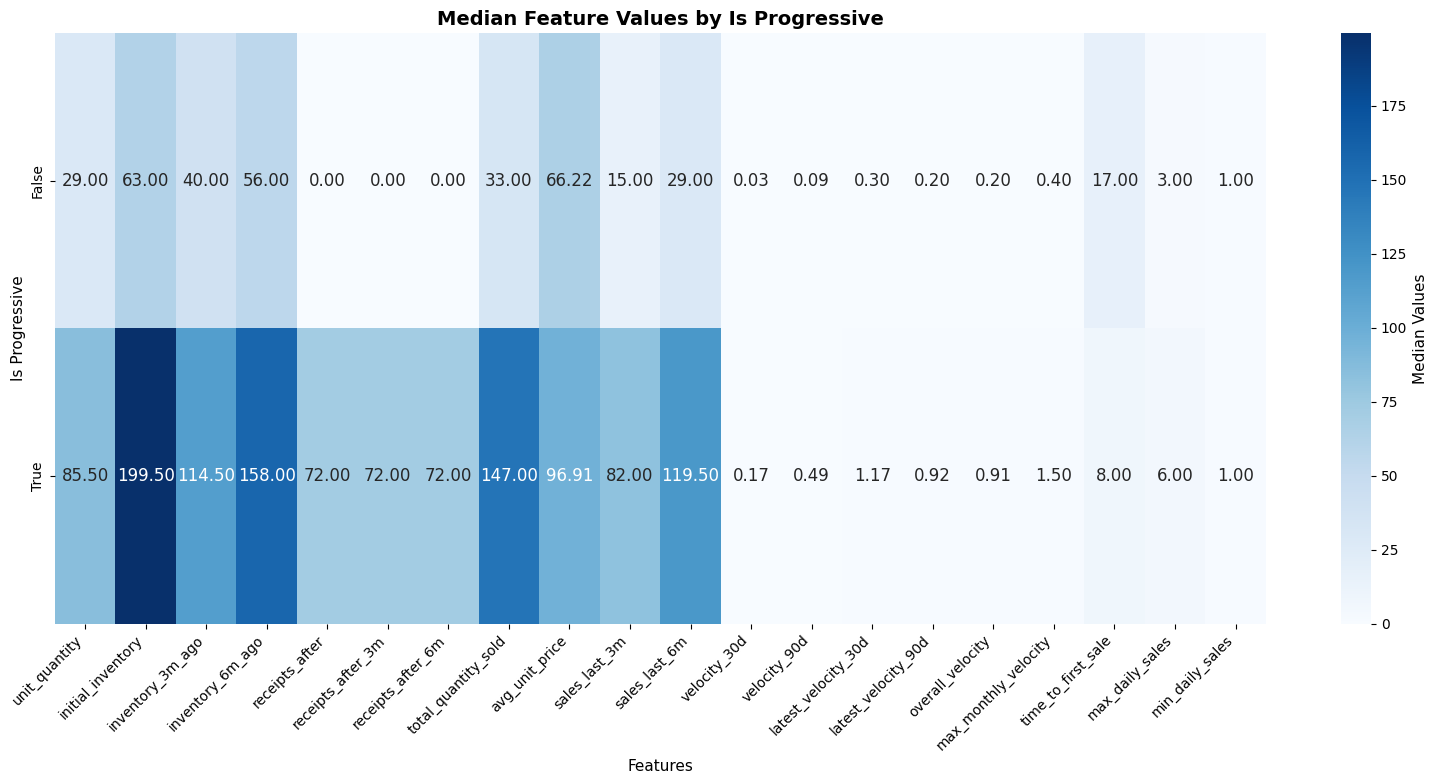


2. Creating radar charts with proportional normalization...


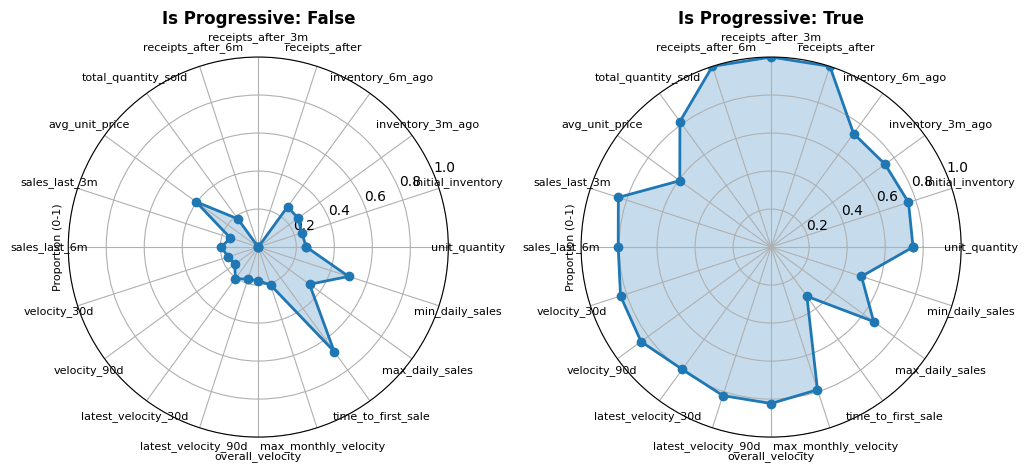


3. Creating parallel coordinates with raw values...


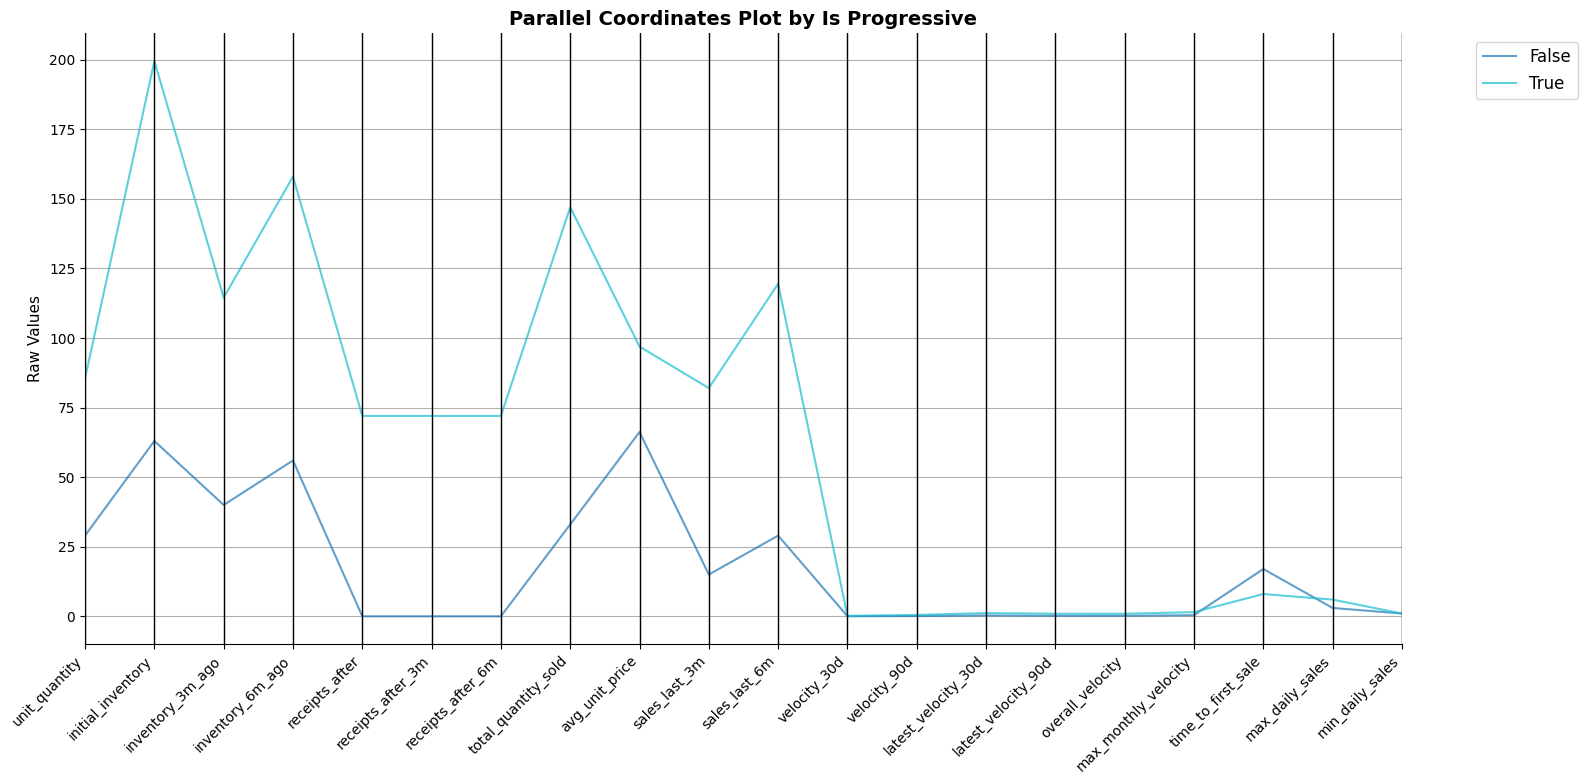


4. Creating clustered bar charts with raw values...


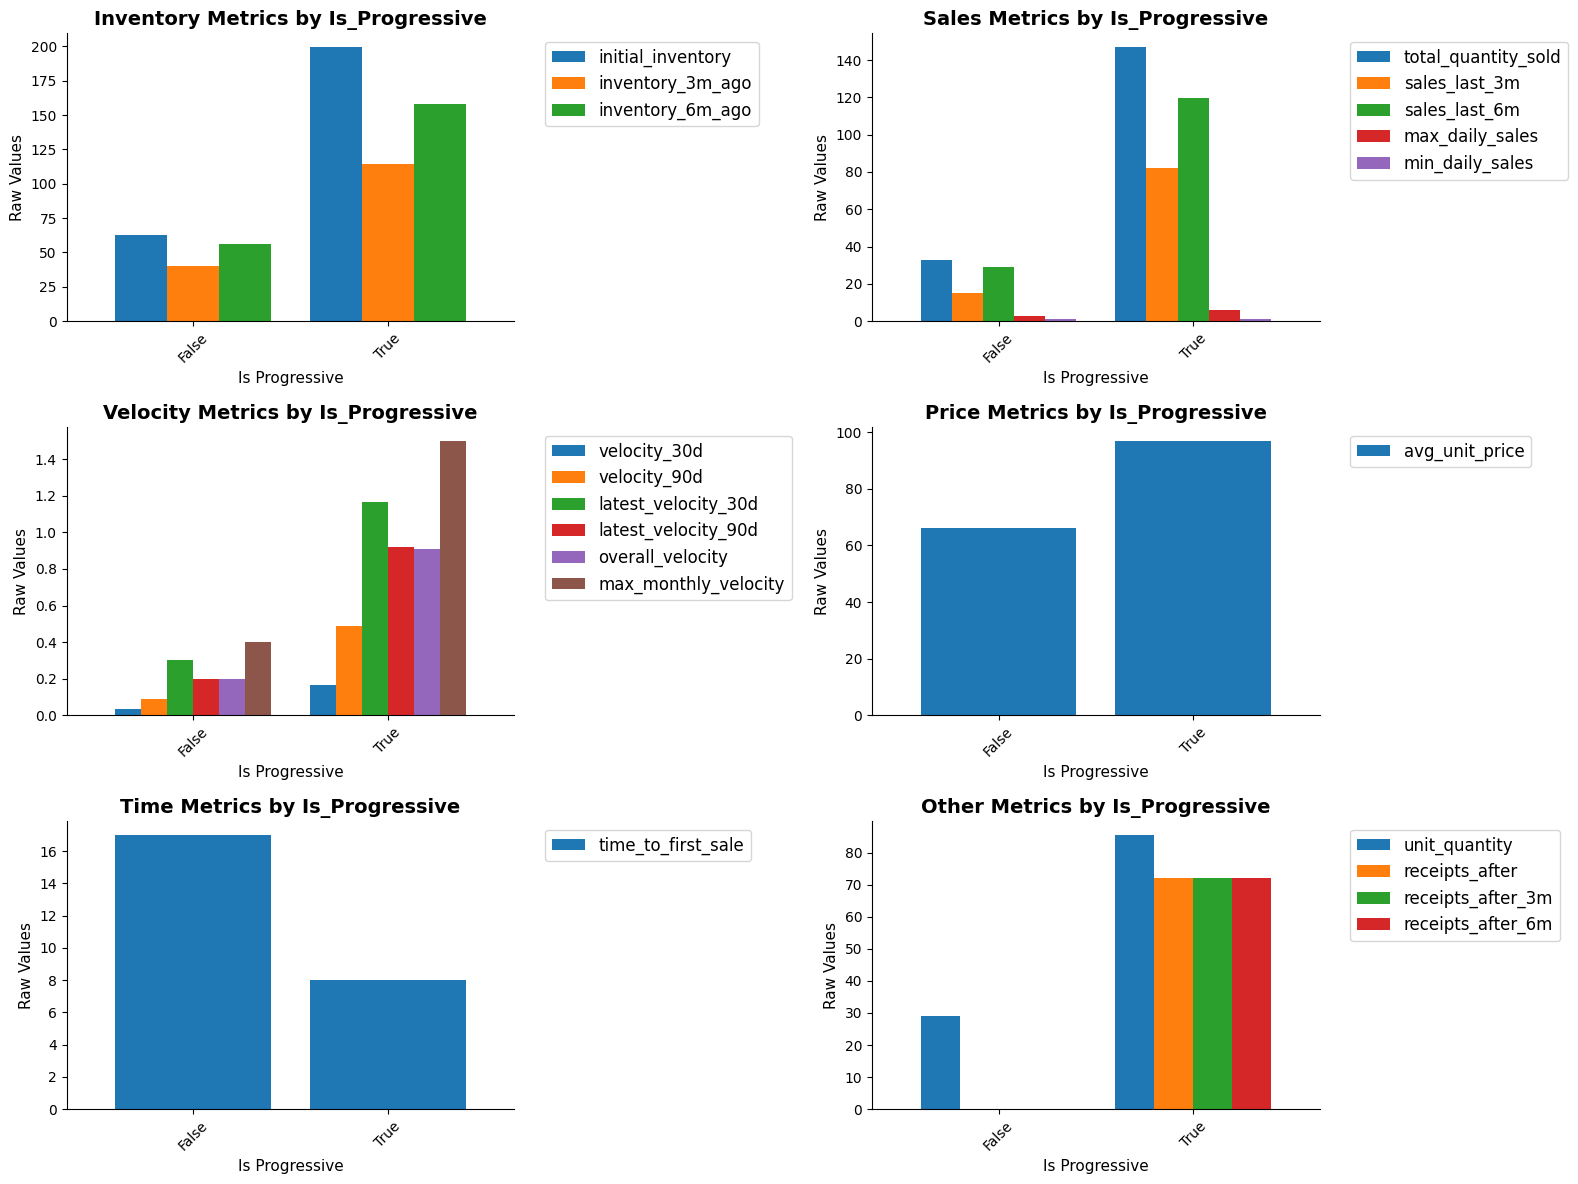


5. Creating summary table...
Is Progressive Summary:
 Is_Progressive  Count  Avg_Sales  Avg_Velocity  Avg_Inventory                                             Top_Features
          False   1001       33.0      0.202979      53.000000      avg_unit_price, initial_inventory, inventory_6m_ago
           True    266      147.0      0.859245     157.333333 initial_inventory, inventory_6m_ago, total_quantity_sold

✅ Analysis for 'is_progressive' completed!

ANALYSIS FOR: IS_SUN
📊 Found 2 categories in 'is_sun':
   • False: 1,101 records
   • True: 166 records

1. Creating heatmap with raw values...



2. Creating radar charts with proportional normalization...


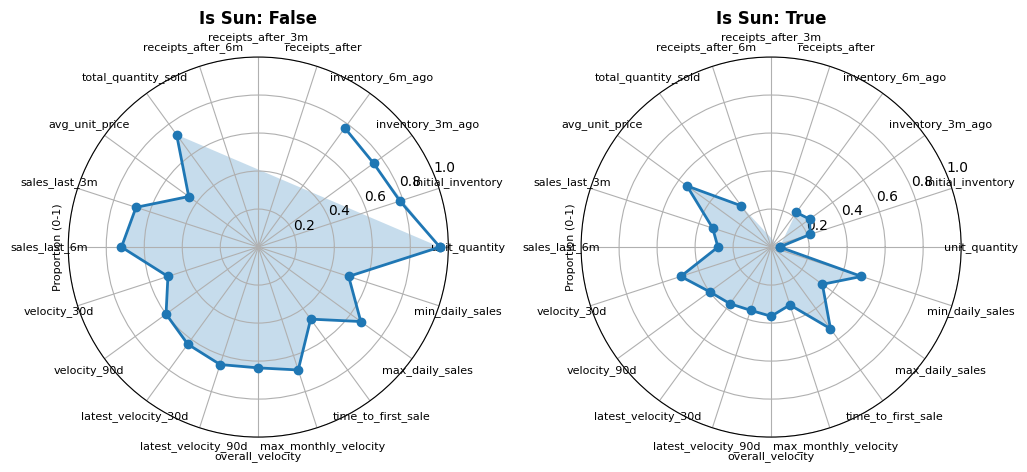


3. Creating parallel coordinates with raw values...



4. Creating clustered bar charts with raw values...


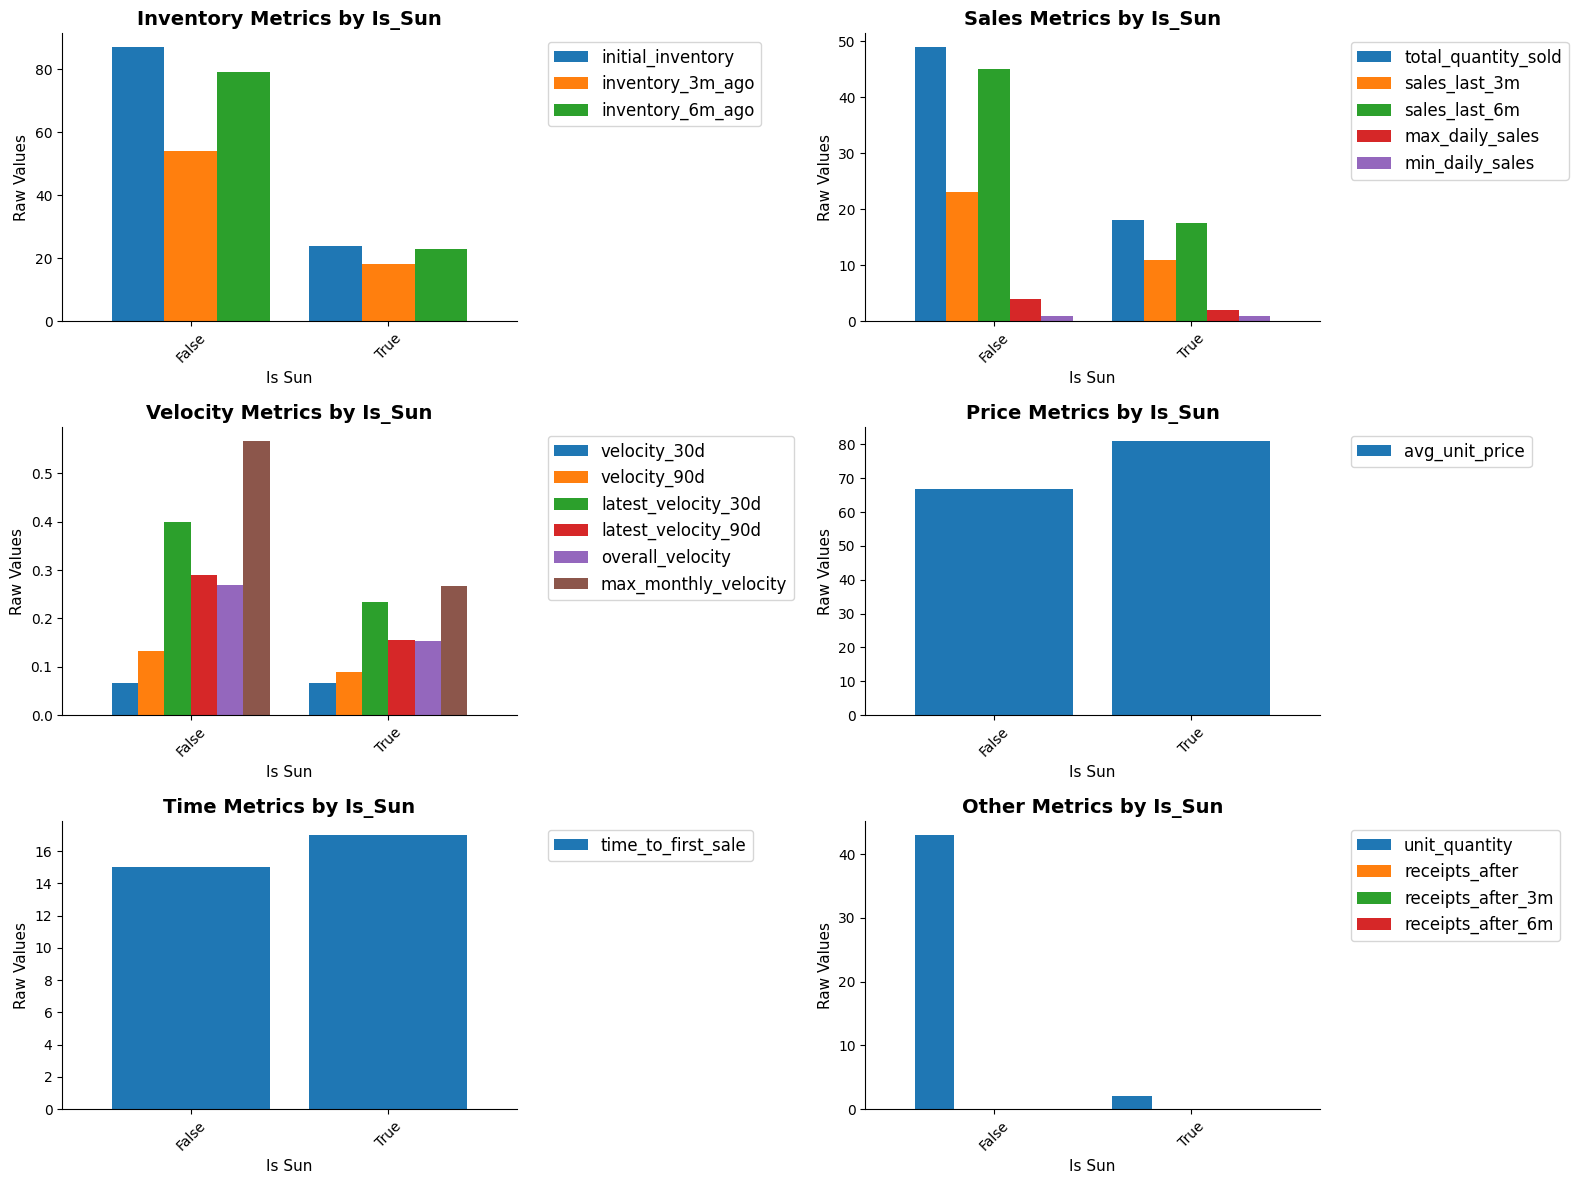


5. Creating summary table...
Is Sun Summary:
 Is_Sun  Count  Avg_Sales  Avg_Velocity  Avg_Inventory                                        Top_Features
  False   1101       49.0      0.287266      73.333333 initial_inventory, inventory_6m_ago, avg_unit_price
   True    166       18.0      0.160775      21.666667 avg_unit_price, initial_inventory, inventory_6m_ago

✅ Analysis for 'is_sun' completed!

ANALYSIS FOR: IS_BLUE_LIGHT
📊 Found 2 categories in 'is_blue_light':
   • False: 930 records
   • True: 337 records

1. Creating heatmap with raw values...


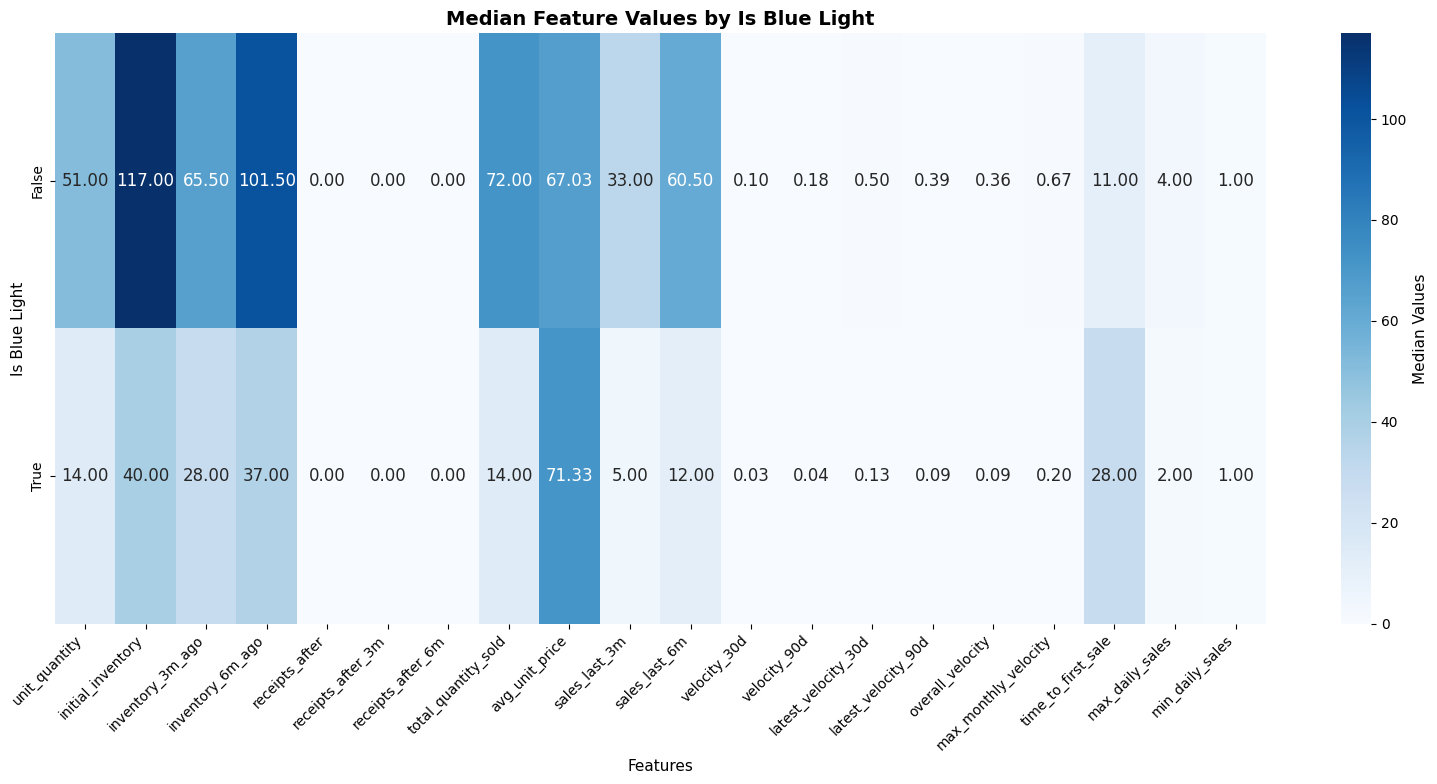


2. Creating radar charts with proportional normalization...


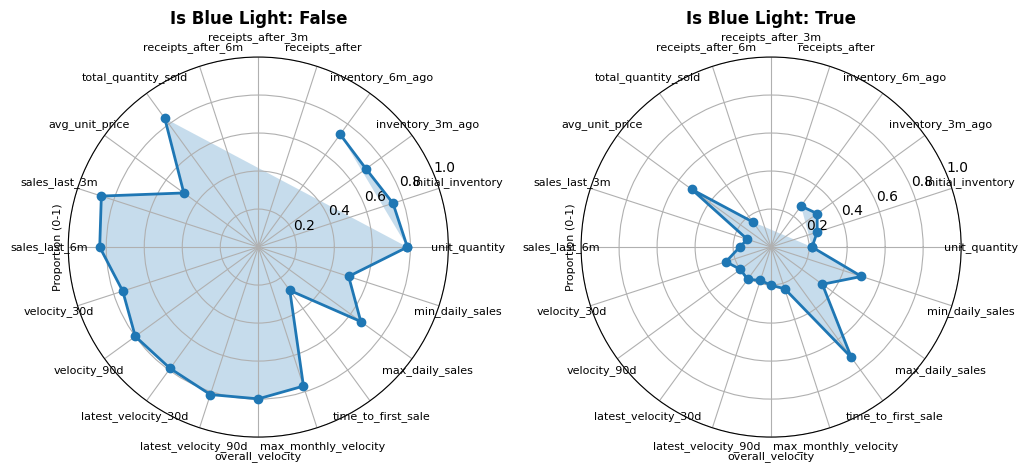


3. Creating parallel coordinates with raw values...


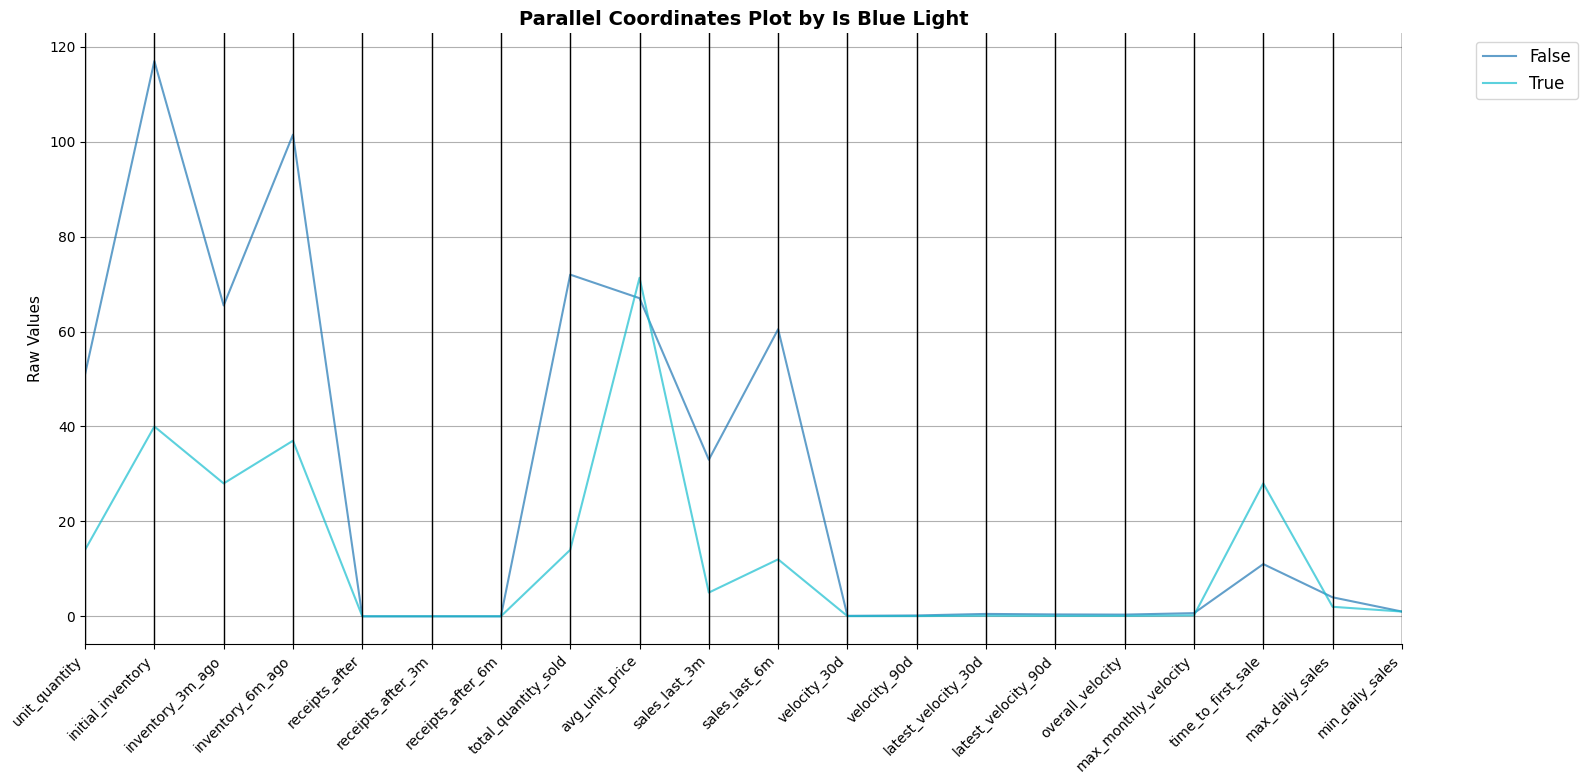


4. Creating clustered bar charts with raw values...



5. Creating summary table...
Is Blue Light Summary:
 Is_Blue_Light  Count  Avg_Sales  Avg_Velocity  Avg_Inventory                                             Top_Features
         False    930       72.0      0.366170      94.666667 initial_inventory, inventory_6m_ago, total_quantity_sold
          True    337       14.0      0.098371      35.000000      avg_unit_price, initial_inventory, inventory_6m_ago

✅ Analysis for 'is_blue_light' completed!

ANALYSIS FOR: IS_GLASSES
📊 Found 2 categories in 'is_glasses':
   • True: 1,245 records
   • False: 22 records

1. Creating heatmap with raw values...


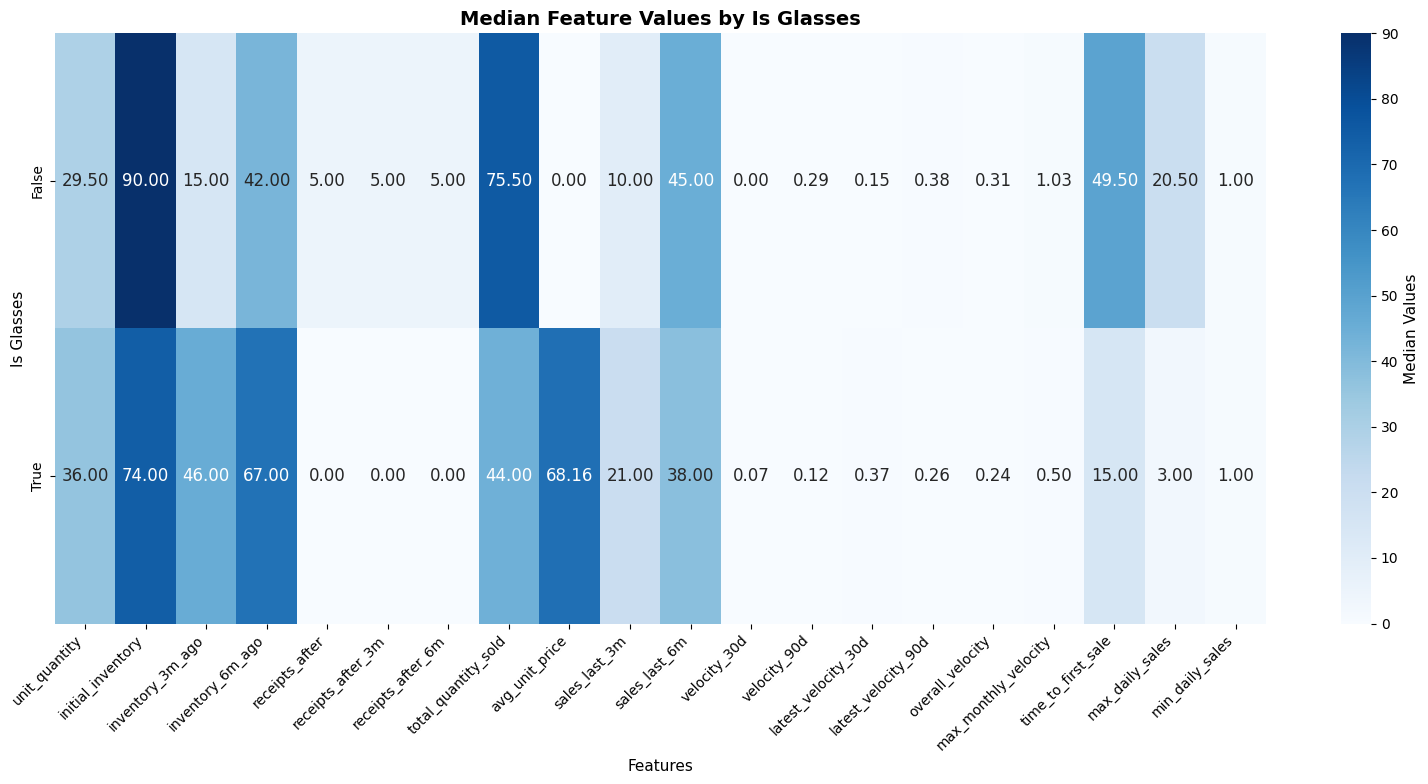


2. Creating radar charts with proportional normalization...


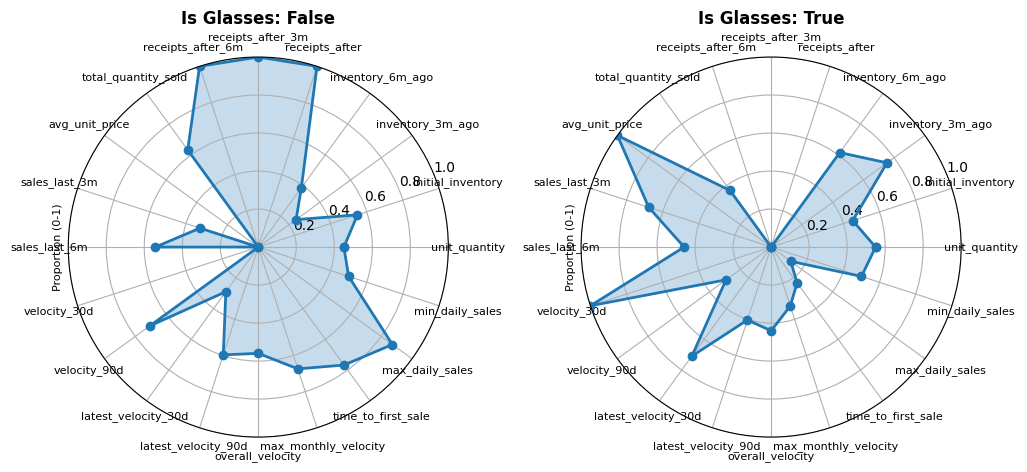


3. Creating parallel coordinates with raw values...


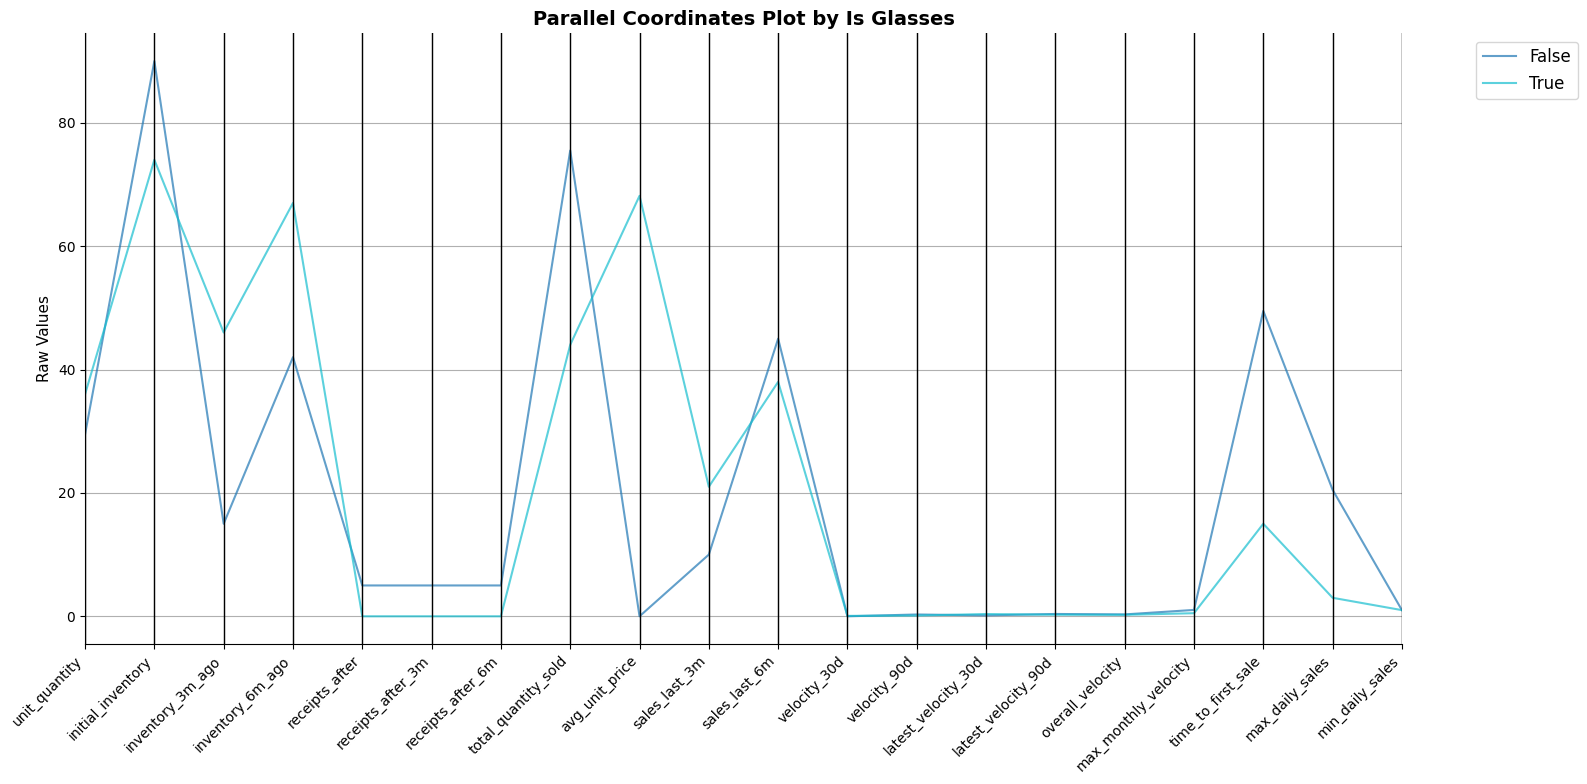


4. Creating clustered bar charts with raw values...


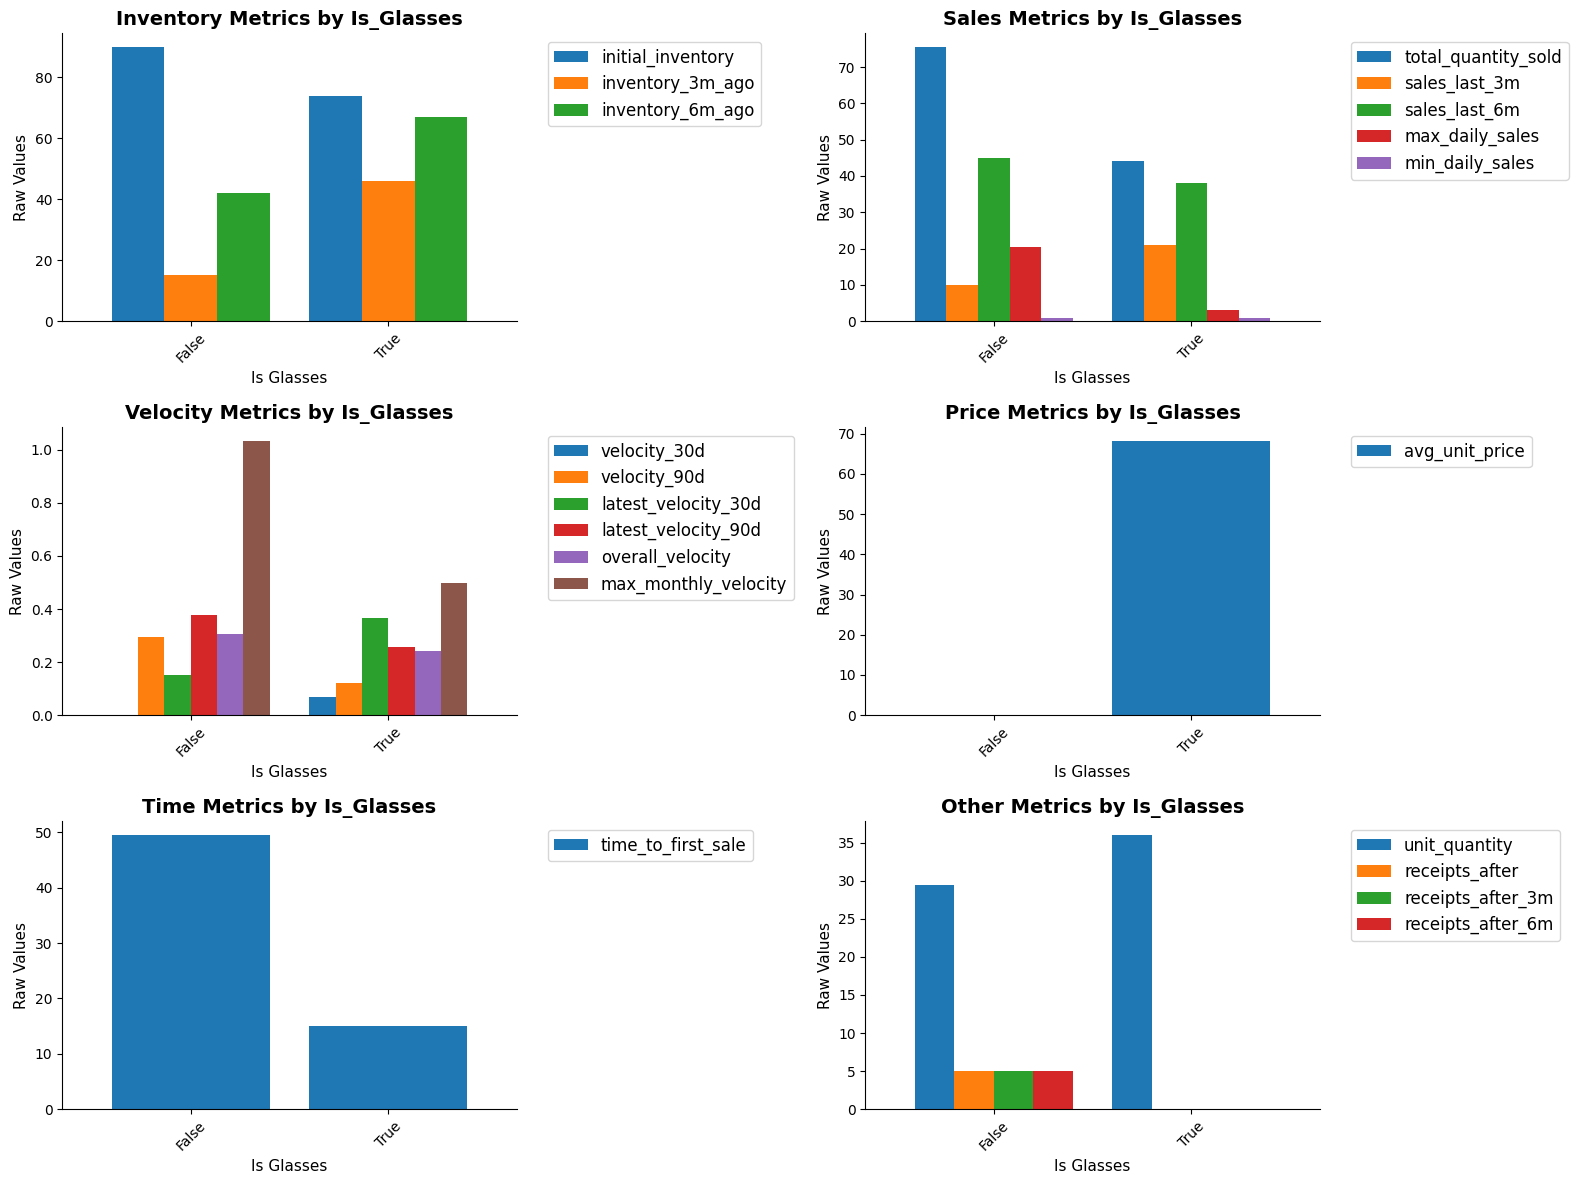


5. Creating summary table...
Is Glasses Summary:
 Is_Glasses  Count  Avg_Sales  Avg_Velocity  Avg_Inventory                                               Top_Features
      False     22       75.5      0.360272      49.000000 initial_inventory, total_quantity_sold, time_to_first_sale
       True   1245       44.0      0.258708      62.333333        initial_inventory, avg_unit_price, inventory_6m_ago

✅ Analysis for 'is_glasses' completed!

ANALYSIS FOR: STRENGTH
📊 Found 6 categories in 'strength':
   • 1.0: 256 records
   • 1.5: 250 records
   • 2.0: 227 records
   • 2.5: 216 records
   • 3.0: 191 records
   • 0.0: 90 records

1. Creating heatmap with raw values...


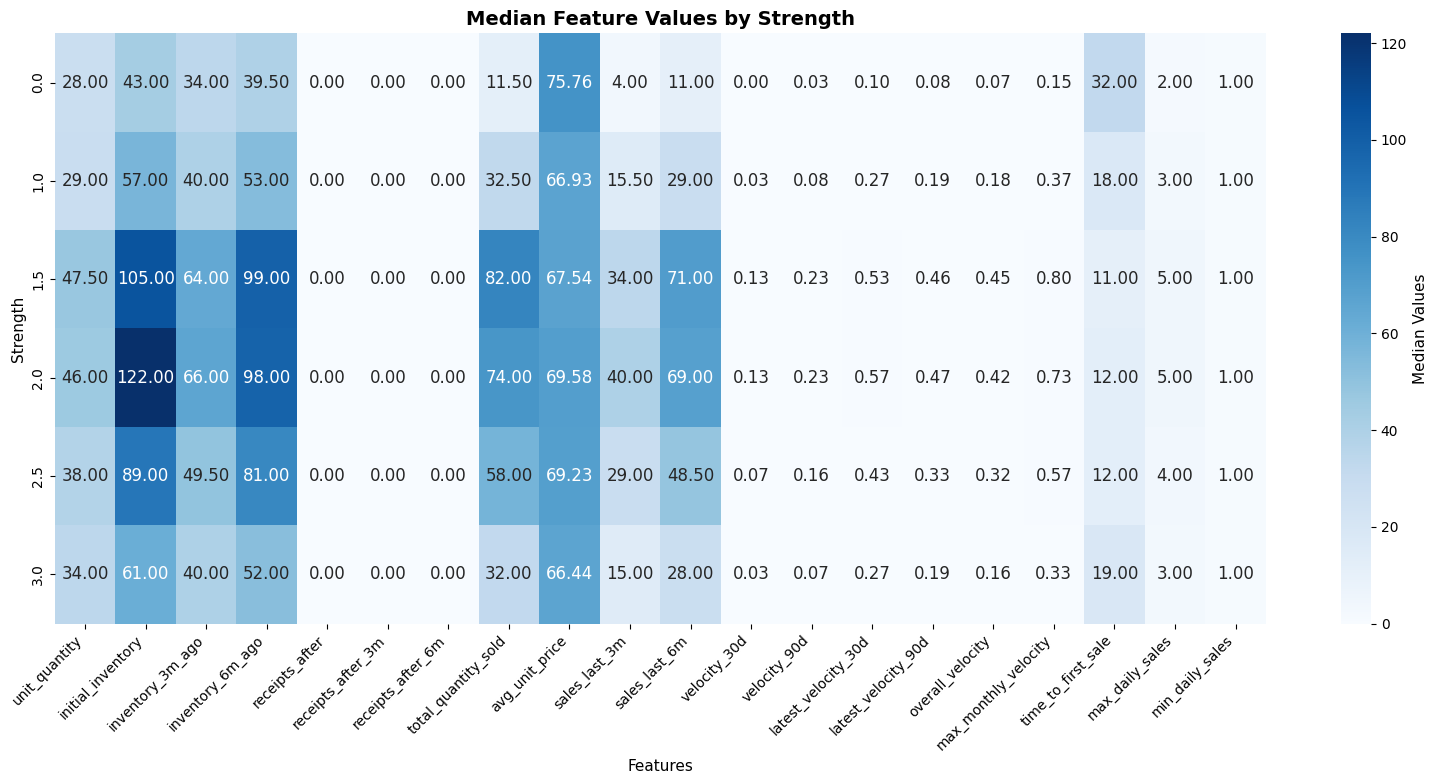


2. Creating radar charts with proportional normalization...


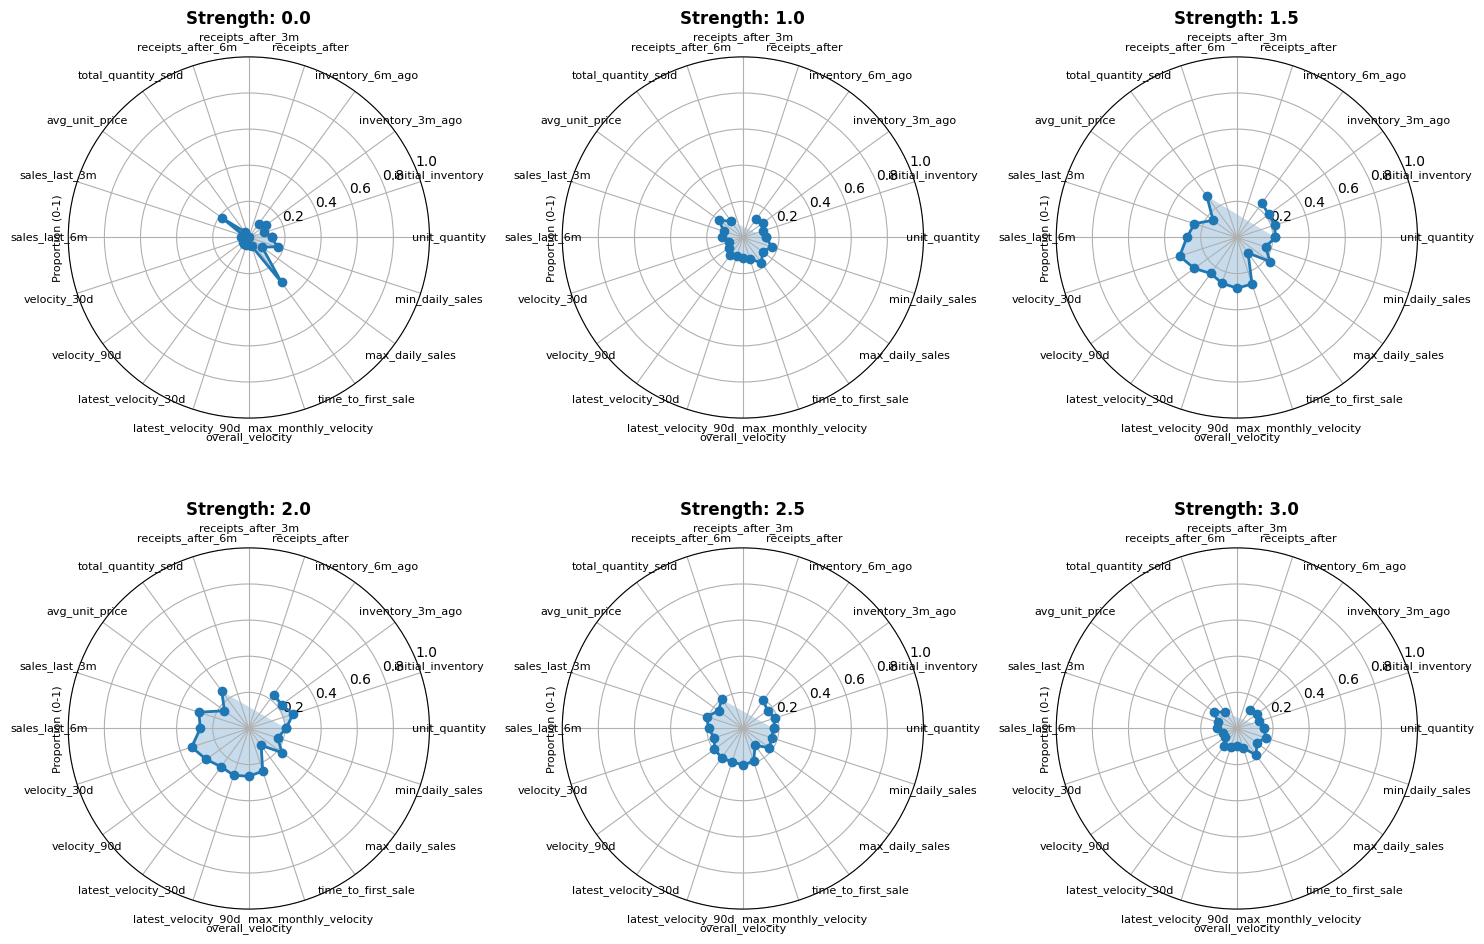


3. Creating parallel coordinates with raw values...


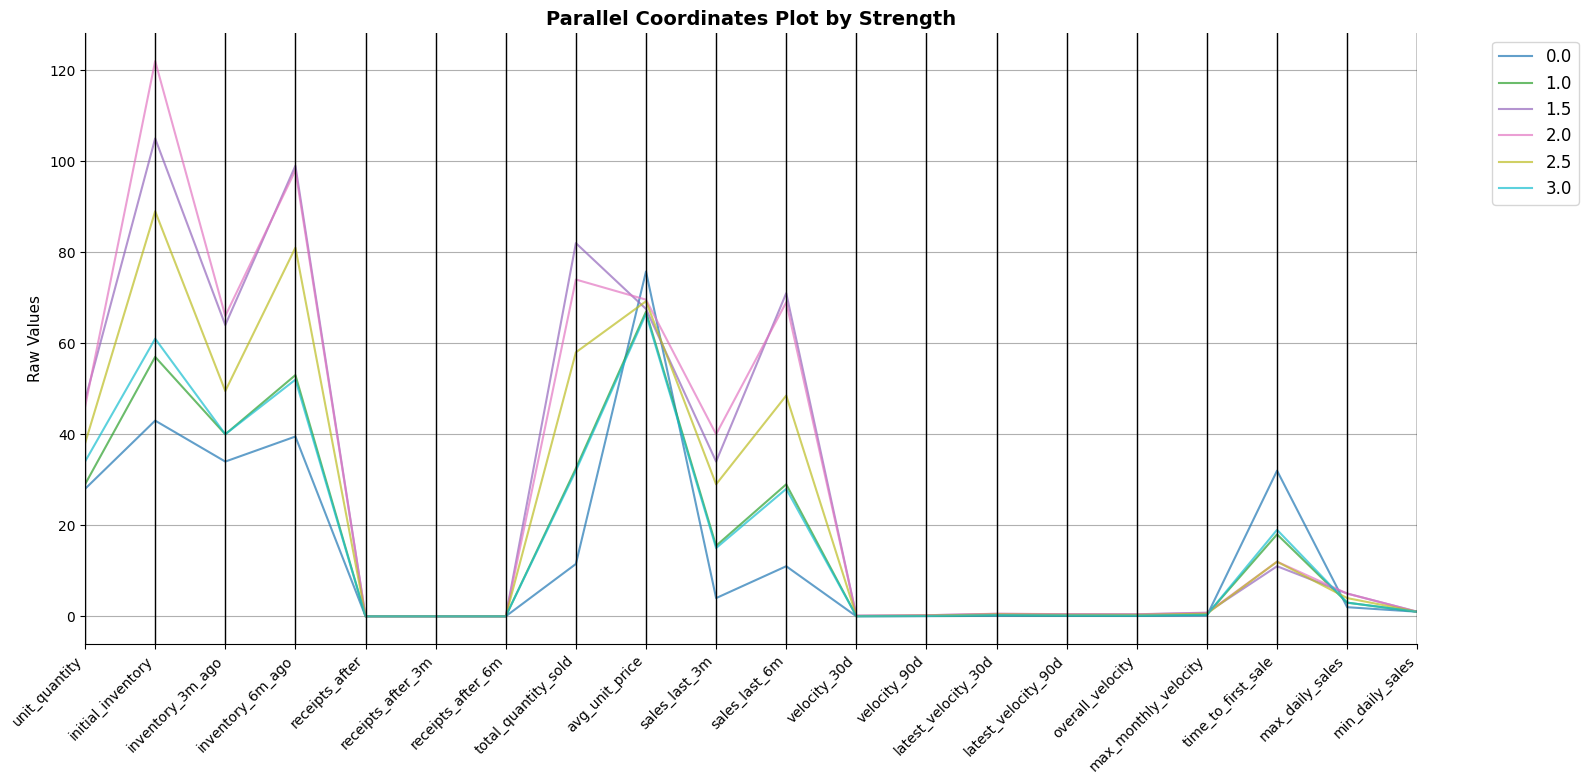


4. Creating clustered bar charts with raw values...


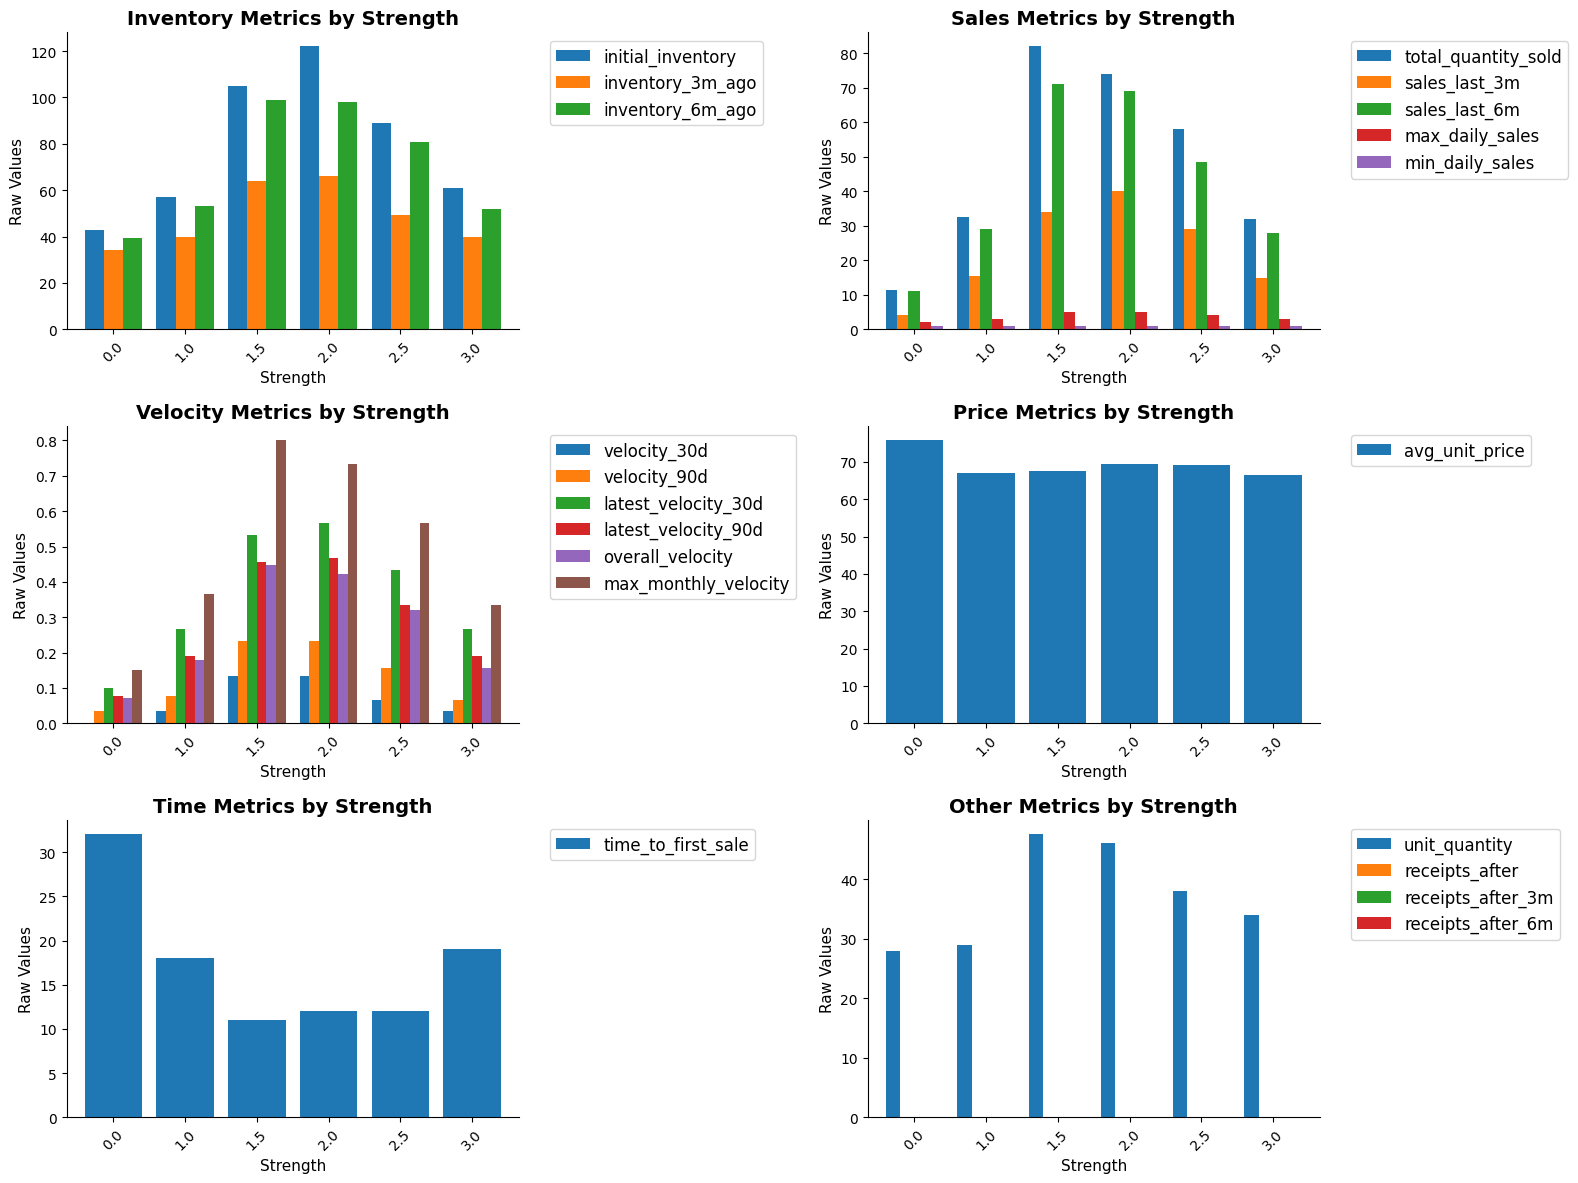


5. Creating summary table...
Strength Summary:
 Strength  Count  Avg_Sales  Avg_Velocity  Avg_Inventory                                             Top_Features
      0.0     90       11.5      0.071981      38.833333      avg_unit_price, initial_inventory, inventory_6m_ago
      1.0    256       32.5      0.185329      50.000000      avg_unit_price, initial_inventory, inventory_6m_ago
      1.5    250       82.0      0.433874      89.333333 initial_inventory, inventory_6m_ago, total_quantity_sold
      2.0    227       74.0      0.425850      95.333333 initial_inventory, inventory_6m_ago, total_quantity_sold
      2.5    216       58.0      0.312650      73.166667      initial_inventory, inventory_6m_ago, avg_unit_price
      3.0    191       32.0      0.174245      51.000000      avg_unit_price, initial_inventory, inventory_6m_ago

✅ Analysis for 'strength' completed!

ANALYSIS FOR: COLOR
📊 Found 22 categories in 'color':
   • Tortoise: 250 records
   • Black: 191 records
   • Taupe

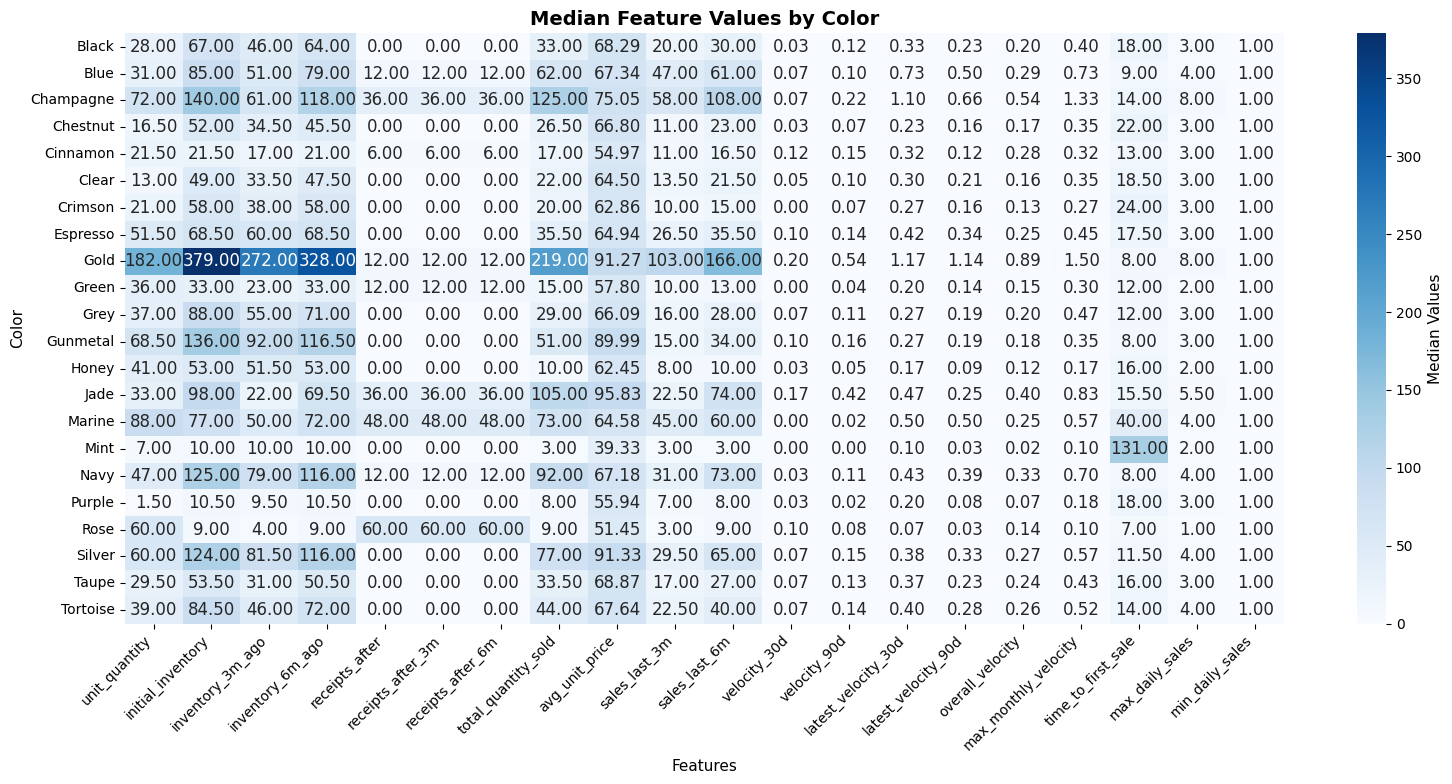


2. Creating radar charts with proportional normalization...


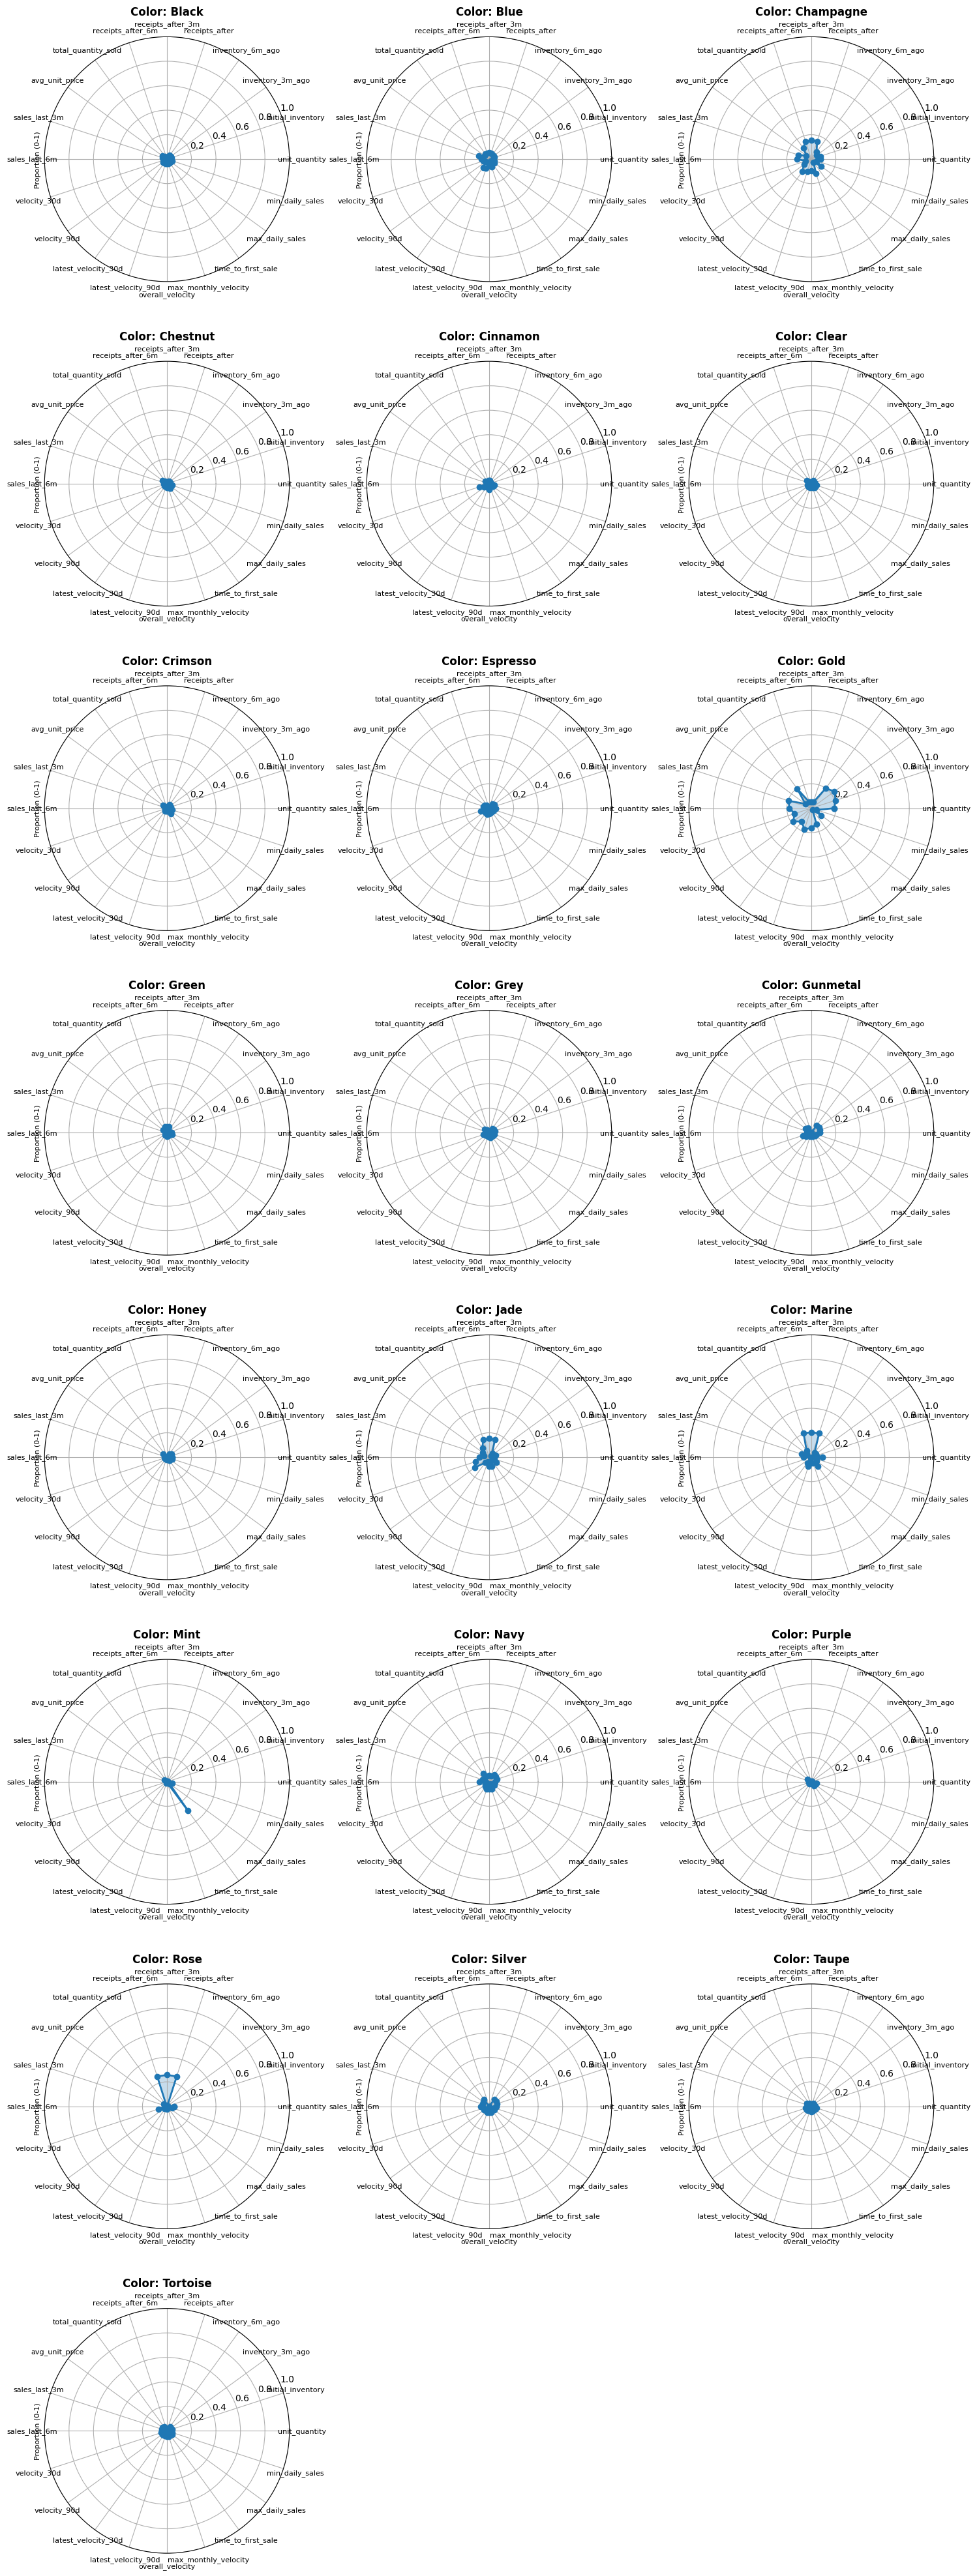


3. Creating parallel coordinates with raw values...


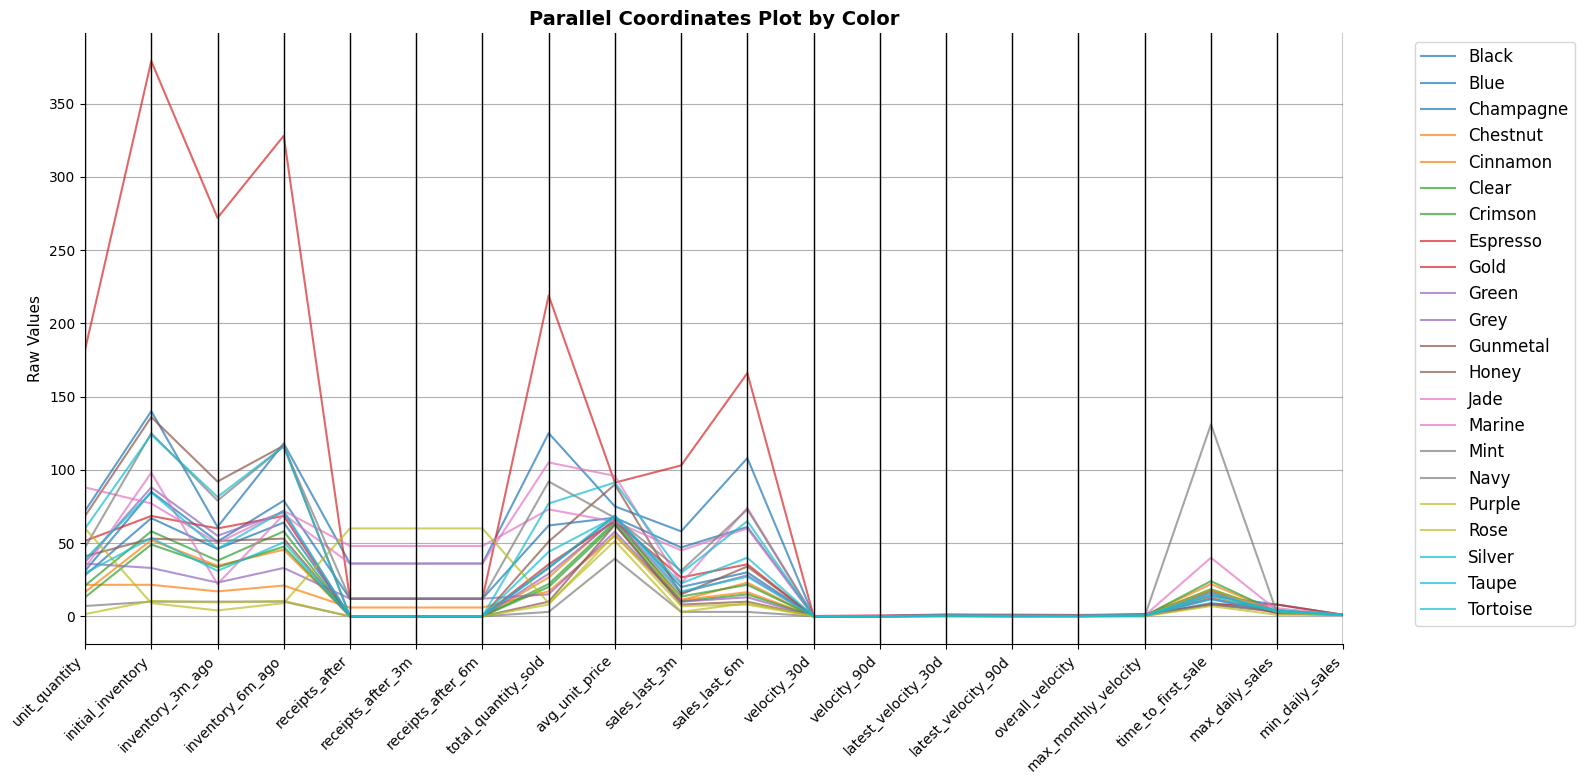


4. Creating clustered bar charts with raw values...


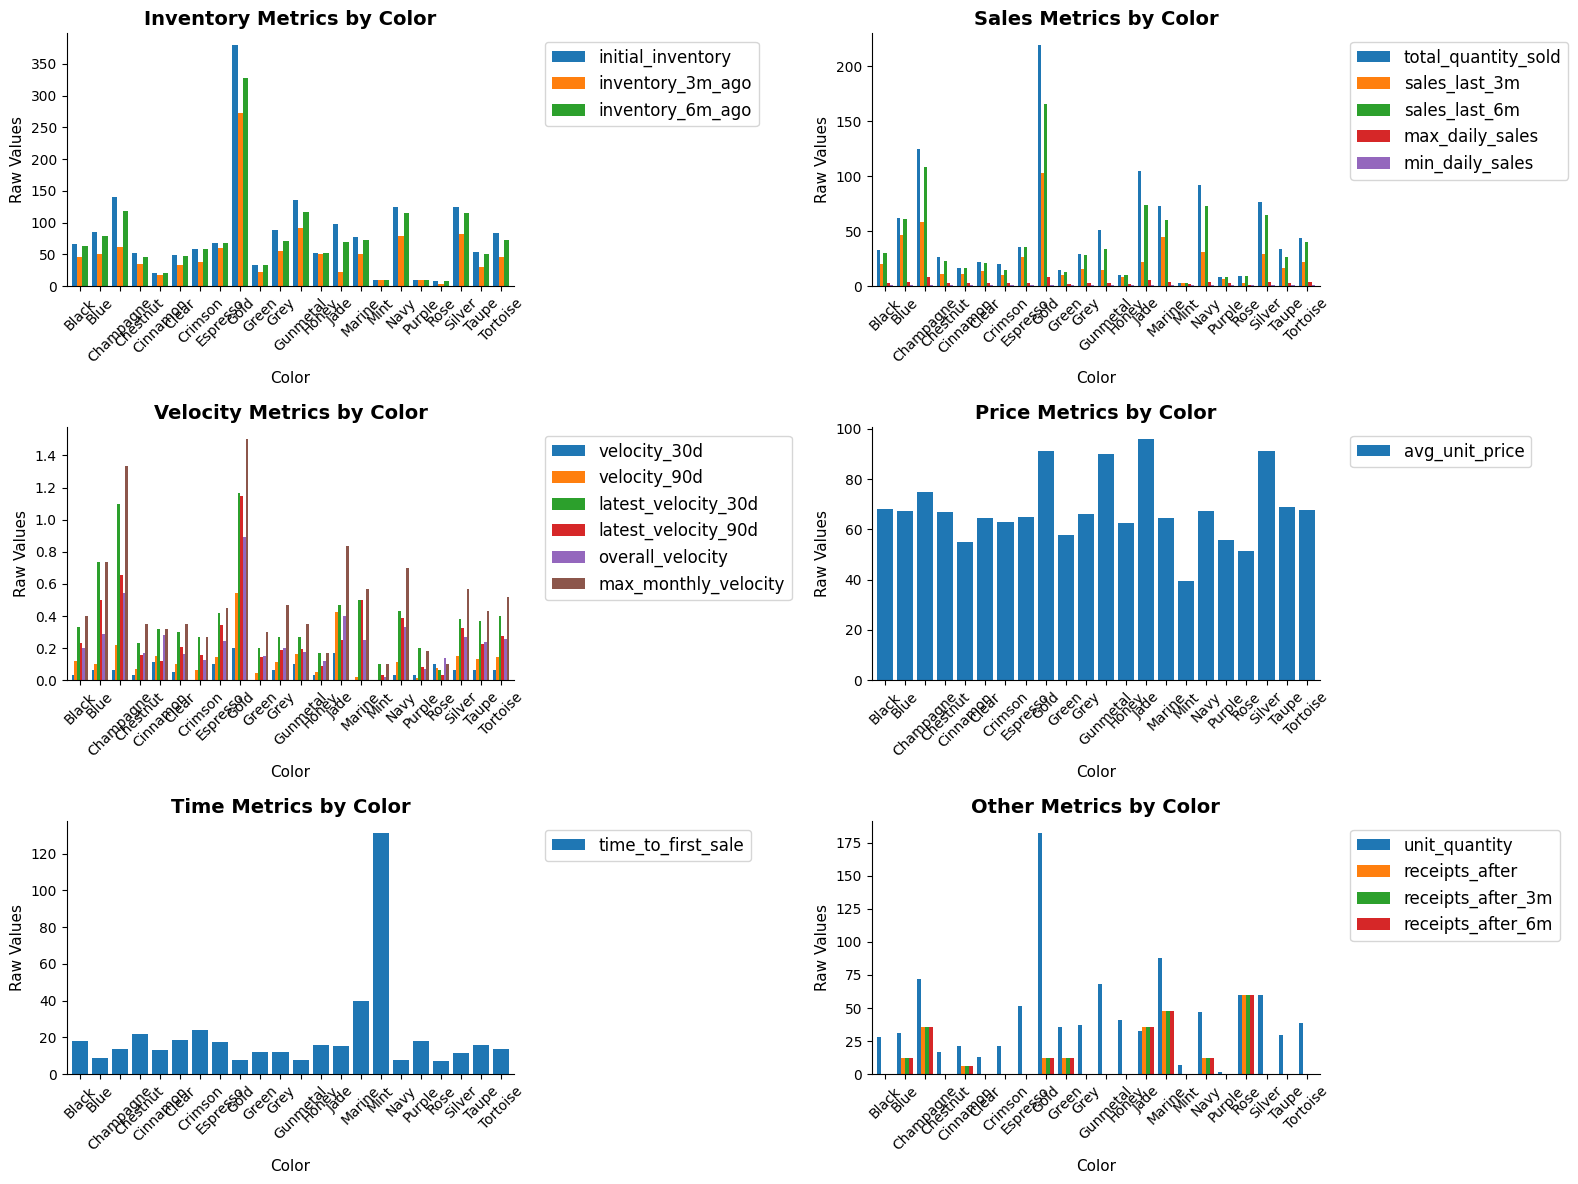


5. Creating summary table...
Color Summary:
    Color  Count  Avg_Sales  Avg_Velocity  Avg_Inventory                                             Top_Features
    Black    191       33.0      0.220619      59.000000      avg_unit_price, initial_inventory, inventory_6m_ago
     Blue     43       62.0      0.403175      71.666667      initial_inventory, inventory_6m_ago, avg_unit_price
Champagne     59      125.0      0.653099     106.333333 initial_inventory, total_quantity_sold, inventory_6m_ago
 Chestnut     62       26.5      0.169336      44.000000      avg_unit_price, initial_inventory, inventory_6m_ago
 Cinnamon     24       17.0      0.217848      19.833333         avg_unit_price, unit_quantity, initial_inventory
    Clear     46       22.0      0.194854      43.333333      avg_unit_price, initial_inventory, inventory_6m_ago
  Crimson     33       20.0      0.147138      51.333333      avg_unit_price, initial_inventory, inventory_6m_ago
 Espresso      8       35.5      0.283725  

In [54]:
# Generic visualization functions for categorical analysis
def create_normalized_heatmap_generic(data, features, groupby_column, figsize=(16, 8)):
    """
    Create a heatmap with raw median values (no normalization).
    
    Args:
        data: DataFrame containing the data
        features: List of feature columns to analyze
        groupby_column: Column name to group by
        figsize: Figure size tuple
    """
    # Group data and calculate median values - NO NORMALIZATION
    grouped_data = data.groupby(groupby_column)[features].median()
    
    plt.figure(figsize=figsize)
    sns.heatmap(grouped_data, 
                annot=True, 
                fmt=".2f", 
                cmap="Blues",
                cbar_kws={'label': 'Median Values'})
    plt.title(f"Median Feature Values by {groupby_column.replace('_', ' ').title()}")
    plt.xlabel("Features")
    plt.ylabel(groupby_column.replace('_', ' ').title())
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

def create_radar_charts_generic(data, features, groupby_column, figsize_per_row=5):
    """
    Create radar/spider charts with proportional normalization (percentages that sum to 1).
    
    Args:
        data: DataFrame containing the data
        features: List of feature columns to analyze
        groupby_column: Column name to group by
        figsize_per_row: Height per row of subplots
    """
    # Group data and calculate median values
    grouped_data = data.groupby(groupby_column)[features].median()
    
    # Proportional normalization: each feature's values sum to 1 across categories
    normalized_data = grouped_data.div(grouped_data.sum(axis=0), axis=1)
    
    n_categories = len(normalized_data)
    n_cols = 3
    n_rows = (n_categories + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, figsize_per_row*n_rows), 
                            subplot_kw=dict(projection='polar'))
    if n_categories == 1:
        axes = [axes]
    else:
        axes = axes.flatten() if n_categories > 1 else [axes]
    
    angles = np.linspace(0, 2*np.pi, len(normalized_data.columns), endpoint=False)
    angles = np.concatenate((angles, [angles[0]]))
    
    for i, (category, row) in enumerate(normalized_data.iterrows()):
        values = row.values
        values = np.concatenate((values, [values[0]]))
        
        ax = axes[i]
        ax.plot(angles, values, 'o-', linewidth=2, label=f'{groupby_column}: {category}')
        ax.fill(angles, values, alpha=0.25)
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(normalized_data.columns, fontsize=8)
        ax.set_ylim(0, 1)
        ax.set_title(f'{groupby_column.replace("_", " ").title()}: {category}', fontsize=12, fontweight='bold')
        ax.grid(True)
        
        # Add percentage labels
        ax.set_ylabel('Proportion (0-1)', fontsize=8)
    
    # Hide unused subplots
    for i in range(n_categories, len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()

def create_parallel_coordinates_generic(data, features, groupby_column, figsize=(16, 8)):
    """
    Create parallel coordinates plot with raw values (no normalization).
    
    Args:
        data: DataFrame containing the data
        features: List of feature columns to analyze
        groupby_column: Column name to group by
        figsize: Figure size tuple
    """
    # Group data and calculate median values - NO NORMALIZATION
    grouped_data = data.groupby(groupby_column)[features].median()
    
    # Reset index to make grouping column a regular column
    plot_data = grouped_data.reset_index()
    
    plt.figure(figsize=figsize)
    pd.plotting.parallel_coordinates(plot_data, groupby_column, 
                                   colormap='tab10', alpha=0.7)
    plt.title(f"Parallel Coordinates Plot by {groupby_column.replace('_', ' ').title()}")
    plt.xticks(rotation=45, ha='right')
    plt.ylabel("Raw Values")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# REMOVED create_feature_importance_plot_generic function entirely

def create_clustered_bar_charts_generic(
    data, features, groupby_column, feature_groups=None, figsize=(16, 12)
):
    """
    Create clustered bar charts with raw values (no normalization).
    """
    # 1) Group & median
    grouped_data = data.groupby(groupby_column)[features].median()

    # 2) Auto–group features if not supplied
    if feature_groups is None:
        inventory_feats = [f for f in features if 'inventory' in f.lower()]
        sales_feats     = [f for f in features if 'sales' in f.lower() or 'sold' in f.lower()]
        velocity_feats  = [f for f in features if 'velocity' in f.lower()]
        price_feats     = [f for f in features if 'price' in f.lower()]
        time_feats      = [f for f in features if 'time' in f.lower() or 'age' in f.lower()]

        feature_groups = {}
        if inventory_feats: feature_groups['Inventory Metrics'] = inventory_feats
        if sales_feats:     feature_groups['Sales Metrics']     = sales_feats
        if velocity_feats:  feature_groups['Velocity Metrics']  = velocity_feats
        if price_feats:     feature_groups['Price Metrics']     = price_feats
        if time_feats:      feature_groups['Time Metrics']      = time_feats

        # any leftover features
        used = set().union(*feature_groups.values())
        other = [f for f in features if f not in used]
        if other:
            feature_groups['Other Metrics'] = other

    # 3) Prep subplots
    n = len(feature_groups)
    cols = 2
    rows = (n + cols - 1)//cols
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = axes.flatten()

    # 4) For each feature-group, use raw values (NO NORMALIZATION)
    for i, (group_name, group_feats) in enumerate(feature_groups.items()):
        subset = grouped_data[group_feats].copy()
        if subset.shape[1] == 0:
            axes[i].set_visible(False)
            continue

        # Use raw values directly
        subset.plot(kind='bar', ax=axes[i], width=0.8)
        axes[i].set_title(f'{group_name} by {groupby_column.title()}')
        axes[i].set_xlabel(groupby_column.replace('_',' ').title())
        axes[i].set_ylabel('Raw Values')
        axes[i].legend(bbox_to_anchor=(1.05,1), loc='upper left')
        axes[i].tick_params(axis='x', rotation=45)

    # 5) hide any unused axes
    for ax in axes[len(feature_groups):]:
        ax.set_visible(False)

    plt.tight_layout()
    plt.show()

def create_summary_table_generic(data, features, groupby_column, top_n=5):
    """
    Create a statistical summary table for the grouping column.
    
    Args:
        data: DataFrame containing the data
        features: List of feature columns to analyze
        groupby_column: Column name to group by
        top_n: Number of top features to show per category
    """
    # Group data and calculate median values
    grouped_data = data.groupby(groupby_column)[features].median()
    
    # Create a more readable summary
    summary_stats = []
    
    for category in grouped_data.index:
        category_data = grouped_data.loc[category]
        
        # Identify top features for this category
        top_features = category_data.nlargest(top_n)
        
        # Calculate some summary metrics (adjust based on your specific features)
        summary_stats.append({
            groupby_column.title(): category,
            'Count': len(data[data[groupby_column] == category]),
            'Avg_Sales': category_data.get('total_quantity_sold', 0),
            'Avg_Velocity': category_data[[c for c in category_data.index if 'velocity' in c]].mean() if any('velocity' in c for c in category_data.index) else 0,
            'Avg_Inventory': category_data[[c for c in category_data.index if 'inventory' in c]].mean() if any('inventory' in c for c in category_data.index) else 0,
            'Top_Features': ', '.join(top_features.index[:3])
        })
    
    summary_df = pd.DataFrame(summary_stats)
    print(f"{groupby_column.replace('_', ' ').title()} Summary:")
    print(summary_df.to_string(index=False))
    
    return summary_df

# Comprehensive analysis function (updated to remove feature importance)
def analyze_categorical_feature(data, features, groupby_column):
    """
    Run complete analysis for any categorical feature.
    
    Args:
        data: DataFrame containing the data
        features: List of feature columns to analyze
        groupby_column: Column name to group by
    """
    print(f"\n{'='*80}")
    print(f"ANALYSIS FOR: {groupby_column.upper()}")
    print(f"{'='*80}")
    
    # Check if column exists and has valid data
    if groupby_column not in data.columns:
        print(f"❌ Column '{groupby_column}' not found in data")
        return
    
    # Remove rows with missing values in the groupby column
    clean_data = data.dropna(subset=[groupby_column])
    n_categories = clean_data[groupby_column].nunique()
    
    print(f"📊 Found {n_categories} categories in '{groupby_column}':")
    value_counts = clean_data[groupby_column].value_counts()
    for category, count in value_counts.items():
        print(f"   • {category}: {count:,} records")
    
    if n_categories < 2:
        print(f"❌ Need at least 2 categories for analysis")
        return
    
    # Run all visualizations (removed feature importance)
    print(f"\n1. Creating heatmap with raw values...")
    create_normalized_heatmap_generic(clean_data, features, groupby_column)
    
    print(f"\n2. Creating radar charts with proportional normalization...")
    create_radar_charts_generic(clean_data, features, groupby_column)
    
    print(f"\n3. Creating parallel coordinates with raw values...")
    create_parallel_coordinates_generic(clean_data, features, groupby_column)
    
    print(f"\n4. Creating clustered bar charts with raw values...")
    create_clustered_bar_charts_generic(clean_data, features, groupby_column)
    
    print(f"\n5. Creating summary table...")
    summary_df = create_summary_table_generic(clean_data, features, groupby_column)
    
    print(f"\n✅ Analysis for '{groupby_column}' completed!")
    return summary_df

# Usage example with your data:
# Define your features list
features = [
    'unit_quantity', 'initial_inventory', 'inventory_3m_ago', 'inventory_6m_ago',
    'receipts_after', 'receipts_after_3m', 'receipts_after_6m', 'total_quantity_sold',
    'avg_unit_price', 'sales_last_3m', 'sales_last_6m', 'velocity_30d', 
    'velocity_90d', 'latest_velocity_30d', 'latest_velocity_90d', 
    'overall_velocity', 'max_monthly_velocity', 'time_to_first_sale', 'max_daily_sales', 'min_daily_sales'
]

# Analyze different categorical features
categorical_columns = ['is_progressive', 'is_sun', 'is_blue_light', 'is_glasses', 'strength', 'color']

for column in categorical_columns:
    if column in sku_data.columns:
        analyze_categorical_feature(sku_data, features, column)


In [55]:
inspect_dataset(sku_data)


             sku                        name                id  \
0     AB10BBLK00    Abbey Blue-light Black 0  AB10BBLK00_20494   
1     AB10BBLK10    Abbey Blue-light Black 1  AB10BBLK10_20494   
2     AB10BBLK15  Abbey Blue-light Black 1.5  AB10BBLK15_20494   
3     AB10BBLK20    Abbey Blue-light Black 2  AB10BBLK20_20494   
4     AB10BBLK30    Abbey Blue-light Black 3  AB10BBLK30_20494   
...          ...                         ...               ...   
1262  WI80SBLK15         Wills Sun Black 1.5  WI80SBLK15_20494   
1263  WI80SBLK20           Wills Sun Black 2  WI80SBLK20_20494   
1264  WI80SBLK25         Wills Sun Black 2.5  WI80SBLK25_20494   
1265  WI80SNTP10      Wills Sun Navy Taupe 1  WI80SNTP10_20494   
1266  WI80SNTP20      Wills Sun Navy Taupe 2  WI80SNTP20_20494   

                  created_date  unit_quantity  awaiting  onhand  committed  \
0    2024-03-06 06:00:00+00:00            129         0     129          0   
1    2024-04-09 05:00:00+00:00              1     

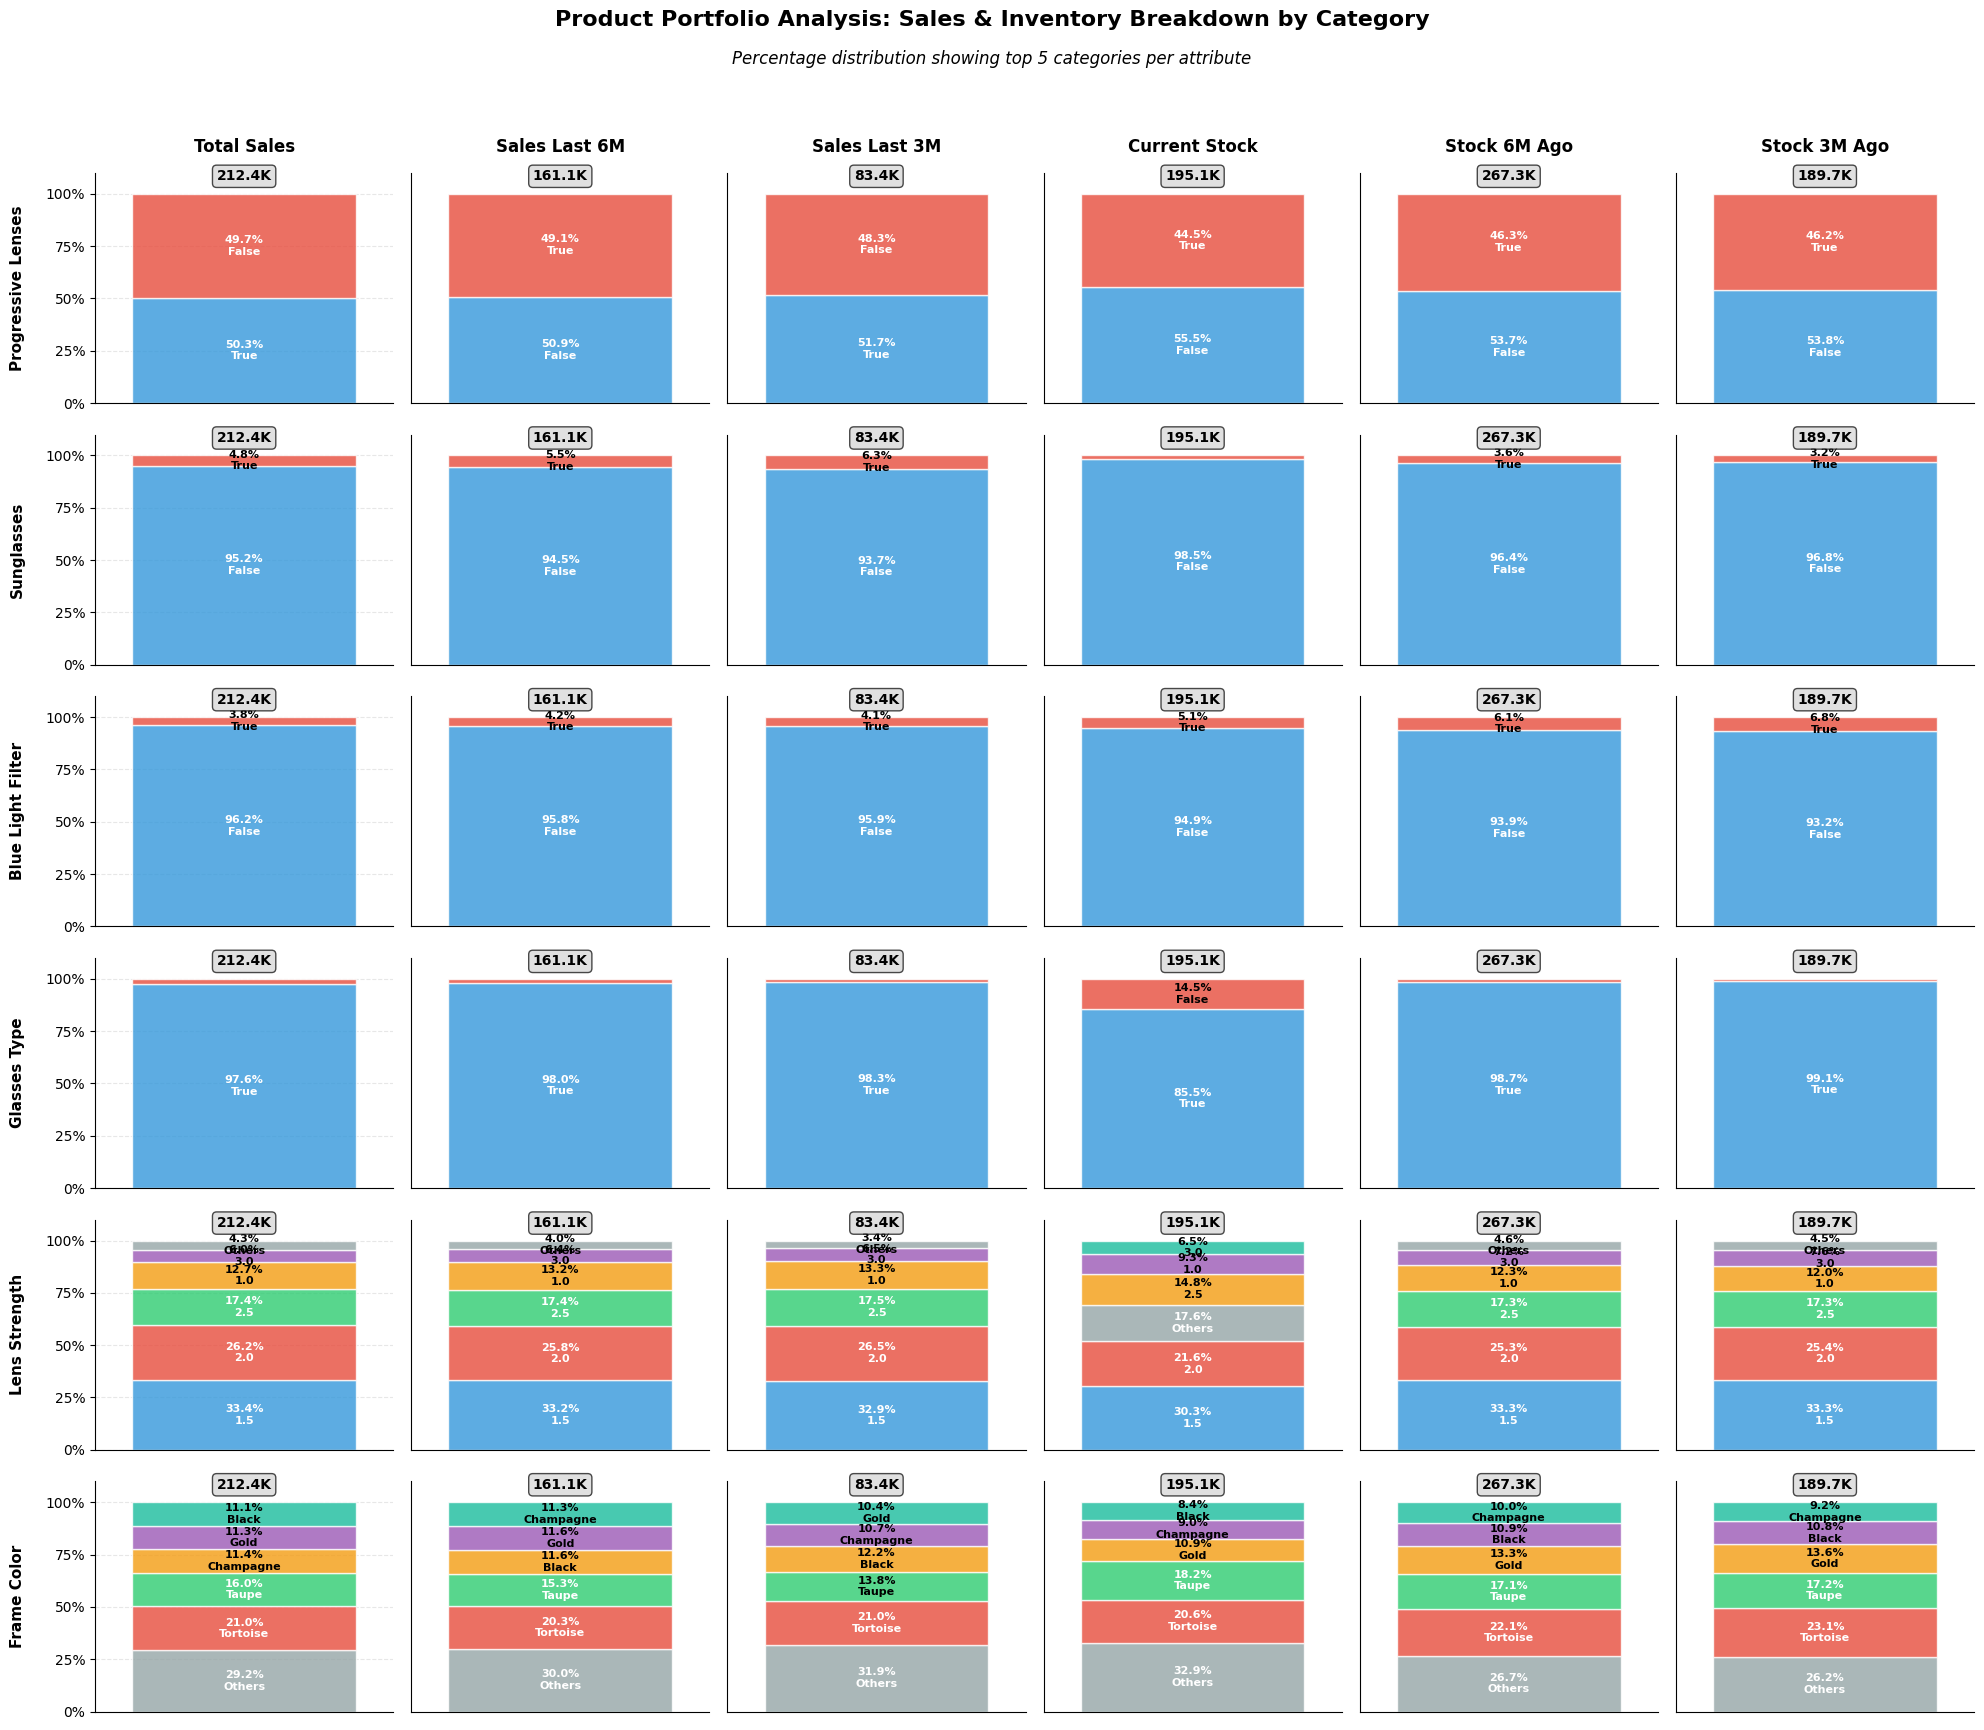


PRODUCT PORTFOLIO ANALYSIS SUMMARY

OVERALL METRICS:
  • Total Sales: 212.4K
  • Sales Last 6M: 161.1K
  • Sales Last 3M: 83.4K
  • Current Stock: 195.1K
  • Stock 6M Ago: 267.3K
  • Stock 3M Ago: 189.7K

TOP PERFORMERS BY ATTRIBUTE:

Progressive Lenses:
  1. True: 106.8K (50.3%)
  2. False: 105.7K (49.7%)

Sunglasses:
  1. False: 202.1K (95.2%)
  2. True: 10.3K (4.8%)

Blue Light Filter:
  1. False: 204.5K (96.2%)
  2. True: 8.0K (3.8%)

Glasses Type:
  1. True: 207.4K (97.6%)
  2. False: 5.1K (2.4%)

Lens Strength:
  1. 1.5: 70.9K (33.4%)
  2. 2.0: 55.6K (26.2%)
  3. 2.5: 37.0K (17.4%)
  4. 1.0: 27.0K (12.7%)
  5. 3.0: 12.8K (6.0%)

Frame Color:
  1. Tortoise: 44.6K (21.0%)
  2. Taupe: 34.0K (16.0%)
  3. Champagne: 24.2K (11.4%)
  4. Gold: 23.9K (11.3%)
  5. Black: 23.7K (11.1%)

GROWTH TRENDS:
  • 3M vs Previous 3M Sales Growth: 7.4%
  • Inventory Change (6M): -27.0%


In [57]:
# Enhanced metrics with better descriptions
metrics = {
    "Total Sales": "total_quantity_sold",
    "Sales Last 6M": "sales_last_6m", 
    "Sales Last 3M": "sales_last_3m",
    "Current Stock": "unit_quantity",
    "Stock 6M Ago": "inventory_6m_ago",
    "Stock 3M Ago": "inventory_3m_ago"
}

attributes = ["is_progressive", "is_sun", "is_blue_light", "is_glasses", "strength", "color"]

# Create figure with transposed layout (attributes as rows, metrics as columns)
fig, axes = plt.subplots(
    nrows=len(attributes), ncols=len(metrics),
    figsize=(20, 18),
    sharey=False
)

# ─────────────────────────── Enhanced color scheme ─────────────────────────────
def get_top5_colors():
    """Generate distinct colors for top 5 categories"""
    colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6', '#1abc9c', '#e67e22', '#34495e']
    return colors

def format_number(num):
    """Format large numbers for better readability"""
    if num >= 1000000:
        return f'{num/1000000:.1f}M'
    elif num >= 1000:
        return f'{num/1000:.1f}K'
    else:
        return f'{int(num)}'

# ─────────────────────────── Get top 5 categories for each attribute ───────────
def get_top5_categories(attr, reference_metric="total_quantity_sold"):
    """Get top 5 categories for an attribute based on reference metric"""
    top_categories = (sku_data
                     .assign(level=lambda d: d[attr].fillna("Other").astype(str))
                     .groupby("level")[reference_metric]
                     .sum()
                     .sort_values(ascending=False)
                     .head(5)
                     .index.tolist())
    return top_categories

# ─────────────────────────── Build enhanced grid ───────────────────────────────
attribute_titles = {
    'is_progressive': 'Progressive Lenses',
    'is_sun': 'Sunglasses',
    'is_blue_light': 'Blue Light Filter',
    'is_glasses': 'Glasses Type',
    'strength': 'Lens Strength',
    'color': 'Frame Color'
}

for r, attr in enumerate(attributes):
    # Get top 5 categories for this attribute
    top5_categories = get_top5_categories(attr)
    colors = get_top5_colors()
    
    for c, (metric_name, metric_col) in enumerate(metrics.items()):
        ax = axes[r, c]
        
        # -------- Aggregate data with top 5 filtering --------------------
        df_full = (sku_data
                  .assign(level=lambda d: d[attr].fillna("Other").astype(str))
                  .groupby("level")[metric_col]
                  .sum()
                  .reset_index())
        
        # Filter to top 5 categories + combine others
        df_top5 = df_full[df_full["level"].isin(top5_categories)].copy()
        df_others = df_full[~df_full["level"].isin(top5_categories)]
        
        if len(df_others) > 0:
            others_sum = df_others[metric_col].sum()
            if others_sum > 0:
                df_top5 = pd.concat([df_top5, 
                                   pd.DataFrame({"level": ["Others"], metric_col: [others_sum]})],
                                  ignore_index=True)
        
        # Sort by value for consistent ordering
        df_top5 = df_top5.sort_values(metric_col, ascending=False).reset_index(drop=True)
        
        # Calculate total and percentages
        total_value = df_top5[metric_col].sum()
        df_top5['percentage'] = (df_top5[metric_col] / total_value * 100) if total_value > 0 else 0
        
        # -------- Create percentage stacked bar --------------------------------
        bottom = 0
        
        for i, (_, row) in enumerate(df_top5.iterrows()):
            lvl = row["level"]
            val = row[metric_col]
            pct = row['percentage']
            
            # Use colors cyclically
            color = colors[i % len(colors)] if lvl != "Others" else '#95a5a6'
            
            # Create the percentage bar (always sum to 100%)
            bar_height = pct
            bar = ax.bar(0, bar_height, bottom=bottom,
                        color=color, edgecolor="white", linewidth=1,
                        alpha=0.8, width=0.6)
            
            # Add percentage labels for segments > 3%
            if pct > 3:
                label_y = bottom + bar_height/2
                ax.text(0, label_y, f'{pct:.1f}%\n{lvl}', 
                       ha='center', va='center', 
                       fontsize=8, fontweight='bold',
                       color='white' if pct > 15 else 'black')
            
            bottom += bar_height
        
        # -------- Add total quantity at top of bar --------------------------
        if total_value > 0:
            ax.text(0, 105, format_number(total_value), 
                   ha='center', va='bottom', 
                   fontsize=10, fontweight='bold',
                   bbox=dict(boxstyle="round,pad=0.3", facecolor='lightgray', alpha=0.7))
        
        # -------- Enhanced cosmetics -----------------------------------------
        if r == 0:
            ax.set_title(metric_name, fontsize=12, fontweight="bold", pad=15)
        
        if c == 0:
            ax.set_ylabel(attribute_titles.get(attr, attr), 
                         fontsize=11, fontweight='bold', rotation=90, labelpad=15)
        
        # Set consistent y-axis (0-100%)
        ax.set_ylim(0, 110)
        ax.set_xlim(-0.4, 0.4)
        
        # Remove x-axis labels and ticks
        ax.set_xticks([])
        
        # Add horizontal grid lines
        ax.grid(True, alpha=0.3, axis='y', linestyle='--')
        ax.set_axisbelow(True)
        
        # Add percentage markers on y-axis for first column
        if c == 0:
            ax.set_yticks([0, 25, 50, 75, 100])
            ax.set_yticklabels(['0%', '25%', '50%', '75%', '100%'])
        else:
            ax.set_yticks([])

# ─────────────────────────── Enhanced title and layout ─────────────────────────
fig.suptitle('Product Portfolio Analysis: Sales & Inventory Breakdown by Category', 
             fontsize=16, fontweight='bold', y=0.98)

# Add subtitle
fig.text(0.5, 0.95, 'Percentage distribution showing top 5 categories per attribute', 
         ha='center', fontsize=12, style='italic')

plt.tight_layout(rect=[0, 0.02, 1, 0.94])
plt.show()

# ─────────────────────────── Enhanced Summary Statistics ───────────────────────
print("\n" + "="*100)
print("PRODUCT PORTFOLIO ANALYSIS SUMMARY")
print("="*100)

# Overall totals
print(f"\nOVERALL METRICS:")
for metric_name, metric_col in metrics.items():
    total = sku_data[metric_col].sum()
    print(f"  • {metric_name}: {format_number(total)}")

# Top performers by attribute
print(f"\nTOP PERFORMERS BY ATTRIBUTE:")
for attr in attributes:
    print(f"\n{attribute_titles.get(attr, attr)}:")
    top5_categories = get_top5_categories(attr)
    
    attr_data = (sku_data
                .assign(level=lambda d: d[attr].fillna("Other").astype(str))
                .groupby("level")["total_quantity_sold"]
                .sum()
                .sort_values(ascending=False))
    
    for i, (category, sales) in enumerate(attr_data.head(5).items()):
        percentage = (sales / attr_data.sum()) * 100
        print(f"  {i+1}. {category}: {format_number(sales)} ({percentage:.1f}%)")

# Growth trends (comparing recent vs older periods)
print(f"\nGROWTH TRENDS:")
recent_sales = sku_data["sales_last_3m"].sum()
older_sales = sku_data["sales_last_6m"].sum() - recent_sales
if older_sales > 0:
    growth_rate = ((recent_sales - older_sales) / older_sales) * 100
    print(f"  • 3M vs Previous 3M Sales Growth: {growth_rate:.1f}%")

current_stock = sku_data["unit_quantity"].sum()
stock_6m_ago = sku_data["inventory_6m_ago"].sum()
if stock_6m_ago > 0:
    stock_change = ((current_stock - stock_6m_ago) / stock_6m_ago) * 100
    print(f"  • Inventory Change (6M): {stock_change:.1f}%")


In [ ]:
sku

In [30]:
# Current Inevntory and historical inventory

#sku_data.to_csv('sku_data.csv', index=False)

print("Sum of unit_quantity:", sku_data["unit_quantity"].sum())
print("Sum of total_quantity_sold:", sku_data["total_quantity_sold"].sum())
print("Sum of initial_inventory:", sku_data["initial_inventory"].sum())

Sum of unit_quantity: 195080
Sum of total_quantity_sold: 212436.0
Sum of initial_inventory: 318704.0


In [32]:
inspect_dataset(sku_data)


             sku                        name                id  \
0     AB10BBLK00    Abbey Blue-light Black 0  AB10BBLK00_20494   
1     AB10BBLK10    Abbey Blue-light Black 1  AB10BBLK10_20494   
2     AB10BBLK15  Abbey Blue-light Black 1.5  AB10BBLK15_20494   
3     AB10BBLK20    Abbey Blue-light Black 2  AB10BBLK20_20494   
4     AB10BBLK30    Abbey Blue-light Black 3  AB10BBLK30_20494   
...          ...                         ...               ...   
1262  WI80SBLK15         Wills Sun Black 1.5  WI80SBLK15_20494   
1263  WI80SBLK20           Wills Sun Black 2  WI80SBLK20_20494   
1264  WI80SBLK25         Wills Sun Black 2.5  WI80SBLK25_20494   
1265  WI80SNTP10      Wills Sun Navy Taupe 1  WI80SNTP10_20494   
1266  WI80SNTP20      Wills Sun Navy Taupe 2  WI80SNTP20_20494   

                  created_date  unit_quantity  awaiting  onhand  committed  \
0    2024-03-06 06:00:00+00:00            129         0     129          0   
1    2024-04-09 05:00:00+00:00              1     